# Imports: 

In [76]:
import csv, multiprocessing, pickle, wikipedia, requests, urllib.parse
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.shortest_paths.dense import floyd_warshall_predecessor_and_distance as fwpd
from gensim.models import Word2Vec, FastText, KeyedVectors
from nltk.corpus import wordnet as wn
from nltk.corpus.reader import WordNetError
from scipy.sparse.csgraph import floyd_warshall as scipy_fw
from bs4 import BeautifulSoup
from nltk.corpus import wordnet_ic
import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr

# Functions: 

In [77]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [78]:
#build networkxgraph
def MakeGraph(nodes, edges): 
    wiki_graph = nx.DiGraph()
    wiki_graph.add_nodes_from(nodes)
    wiki_graph.add_edges_from(edges)    
    return wiki_graph

#helper function to unpack tuple for use in multiprocessing
def DijkstraWeighted(in_tuple): 
    try: 
        source = in_tuple[0][1]['source']
        target = in_tuple[0][1]['target']
        graph = in_tuple[1]
        in_tuple[0][1]['dijkstra_weighted'] = nx.shortest_path(graph, source, target, weight='weight')
        in_tuple[0][1]['dijkstra_unweighted'] = nx.shortest_path(graph, source, target)
        return in_tuple[0][1]
    
    except nx.NetworkXNoPath as no_path: 
        print(no_path)
        in_tuple[0][1]['dijkstra_weighted'] = np.nan
        in_tuple[0][1]['dijkstra_unweighted'] = np.nan
        return in_tuple[0][1]
    
    except nx.NodeNotFound as no_node: 
        print(no_node)
        in_tuple[0][1]['dijkstra_weighted'] = np.nan
        in_tuple[0][1]['dijkstra_unweighted'] = np.nan
        return in_tuple[0][1]

def DFDijkstraParallel(df, graph):
    partitions = multiprocessing.cpu_count()
    tuples_list = [(row, graph) for row in df.iterrows()]
    with multiprocessing.Pool(partitions) as pool: 
        series = pool.map(DijkstraWeighted, tuples_list)
        #transpose to get correct alignment of rows and columns
        return_df = pd.concat(series, axis=1).T
    
    return return_df
  
def ScipyShortestPaths(graph): 
    sp_graph = nx.to_scipy_sparse_matrix(graph)
    scipy_dist, scipy_pred = scipy_fw(sp_graph, return_predecessors=True, directed=True)
    
    dist_df = pd.DataFrame(scipy_dist, columns=graph.nodes(), index=graph.nodes())
    pred_df = pd.DataFrame(scipy_pred, columns=graph.nodes(), index=graph.nodes())
    
    #remap dist df from numeric indices to node names: 
    #special case for negative infinity
    remap = {-9999: np.nan}
    for i, node in enumerate(graph.nodes()): 
        remap[i] = node
    pred_df = pred_df.applymap(lambda x: remap[x])
    return (dist_df, pred_df)

#helper function to call scipy paths for both graphs so that it's comparable to dijkstra's
def ScipyTimeProfiler(unweighted, weighted): 
    unweighted_dist, unweighted_pred = ScipyShortestPaths(unweighted)
    weighted_dist, weighted_pred = ScipyShortestPaths(weighted)
    return (unweighted_dist, unweighted_pred, weighted_dist, weighted_pred)
    
#helper function for single-processing approach
def DijkstraHelper(graph, row):
    try: 
        return nx.shortest_path(graph, row.loc['source'], row.loc['target'], weight='weight')
    
    except nx.NetworkXNoPath as no_path: 
        print(no_path)
        return np.nan
    
    except nx.NodeNotFound as no_node: 
        print(no_node)
        return np.nan

#helper function for timing later
def DijkstraSingleProcess(full, wordnet, df): 
    df.loc[:, 'sp_unweight'] = df.apply(lambda x: DijkstraHelper(full, x), axis=1)
    df.loc[:, 'sp_wordnet'] = df.apply(lambda x: DijkstraHelper(wordnet, x), axis=1)
    return df

#for reconstructing paths using predecessors in F-W
def ReconstructPath(source, target, pred): 
    try: 
        if pred[target][source] is np.nan: 
            return []
        path = [target]
        while target != source: 
            target = pred[target][source]
            path.append(target)
        #reverse list
        return path[::-1]
    except KeyError:
        return np.nan
    except ValueError as v: 
        print(v)
        print(target, source)
        return np.nan            

def AddWordNetDistances(graph): 
    #operate on a deep copy of the graph
    graph = graph.copy()
    for edge in graph.edges(): 
        try: 
            #url decode both words: 
            edge1 = urllib.parse.unquote(edge[0])
            edge2 = urllib.parse.unquote(edge[1])
            
            word1 = wn.synset(edge1 + '.n.01')
            word2 = wn.synset(edge2 + '.n.01')
            
            #return reciprocal of similarity to get distance
            graph[edge[0]][edge[1]]['weight'] = 1/word1.lch_similarity(word2)
            
        except WordNetError as wne: 
            graph[edge[0]][edge[1]]['weight'] = 1
        
        except IndexError as ie:
            #set edge weight to 1: 
            graph[edge[0]][edge[1]]['weight'] = 1
    
    return graph

#function to drop nodes that aren't in wordnet
def DropWordNetNodes(in_graph): 
    #operate on a copy of the graph
    graph = in_graph.copy()
    drop_nodes = []
    
    #identify nodes that aren't in wordnet
    for node in graph.nodes(): 
        try: 
            parsed = urllib.parse.unquote(node)
            syn = wn.synset(parsed + '.n.01') 
        except WordNetError as wne: 
            drop_nodes.append(node)
    
    #drop nodes: 
    if len(drop_nodes) > 0: 
        print("Nodes before:", len(graph.nodes()), "Edges before:", len(graph.edges()))
        graph.remove_nodes_from(drop_nodes)
        print("Nodes after:", len(graph.nodes()), "Edges after:", len(graph.edges()))
  
    return graph


def PathLength(path, graph, weighted):
    try: 
        if weighted == False: 
            return len(path)-1

        else: 
            try: 
                length = 0
                for i in range(0, len(path)-1): 
                    length = length + graph[path[i]][path[i+1]]['weight']
                return length

            except KeyError as k: 
                return 9999
            
    except TypeError as t: 
        return 9999

#for reading in files in the SNAP format
def ReadSnap(filepath): 
    return_list = []
    with open(filepath, 'r') as file: 
        reader = csv.reader(file, delimiter='\t') 
        for row in reader: 
            if row and not row[0].startswith("#"): 
                return_list.append(row)
    return return_list

# Analyses: 

## File I/O: 

### Graph: 

In [79]:
#read in articles and links
articles = '/Users/xxxxxxxxx/Documents/SDS/Thesis/Wikispeedia/wikispeedia_paths-and-graph/articles.tsv'
    
in_nodes = []
with open(articles, 'r') as file: 
    reader = csv.reader(file, delimiter='\t') 
    for row in reader: 
        if row and not row[0].startswith("#"): 
            in_nodes.append(row)
               
#flatten to 1-d array
in_nodes = [edge[0] for edge in in_nodes] 
print("len(in_nodes):", len(in_nodes))
    
links = '/Users/xxxxxxxxxx/Documents/SDS/Thesis/Wikispeedia/wikispeedia_paths-and-graph/links.tsv'
    
in_edges = []
with open(links, 'r') as file: 
    reader = csv.reader(file, delimiter='\t') 
    for row in reader: 
        if row and not row[0].startswith("#"): 
            in_edges.append(row)

#cast to tuples for input above
in_edges = [tuple(vertex) for vertex in in_edges if len(vertex) == 2]
    
#read in shortest path distance matrix
snap_distance_matrix = '/Users/xxxxxxxxxx/Documents/SDS/Thesis/Wikispeedia/wikispeedia_paths-and-graph/shortest-path-distance-matrix.txt'
snap_distances = []
with open(snap_distance_matrix, 'r') as file: 
    reader = csv.reader(file, delimiter='\n') 
    for row in reader: 
        if row and not row[0].startswith("#"): 
            snap_distances.append(row)

len(in_nodes): 4604


### Human paths: 

In [80]:
#read in finished paths: 
finished_paths = '/Users/xxxxxxxxxx/Documents/SDS/Thesis/Wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv'
finished_list = ReadSnap(finished_paths)
f_headers = ['ip', 'timestamp', 'duration', 'path', 'rating'] 
finished = pd.DataFrame(finished_list, columns=f_headers)

#make duration and difficulty integers: 
finished['duration'] = finished['duration'].map(lambda x: int(x))
finished['rating'] = finished['rating'].map(lambda x: np.nan if x == "NULL" else int(x))

finished['source'] = finished['path'].map(lambda x: x.split(";")[0])
finished['target'] = finished['path'].map(lambda x: x.split(";")[-1])

#convert to list format for path length calculation, drop back-clicks for now
finished['backclicks'] = finished['path'].map(lambda x: "<" in x)
display(finished['backclicks'].value_counts())
finished = finished[finished['backclicks'] == False]
finished['path'] = finished['path'].map(lambda x: [y for y in x.split(";") if y != "<"])

display(finished.head())

#read in unfinished paths: 
unfinished_paths = '/Users/xxxxxxxxxxx/Documents/SDS/Thesis/Wikispeedia/wikispeedia_paths-and-graph/paths_unfinished.tsv'
unfinished_list = ReadSnap(unfinished_paths)
u_headers = ['ip', 'timestamp', 'duration', 'path', 'target', 'type'] 
unfinished = pd.DataFrame(unfinished_list, columns=u_headers)
unfinished['source'] = unfinished['path'].map(lambda x: x.split(";")[0])
unfinished['path'] = unfinished['path'].map(lambda x: [y for y in x.split(";") if y != "<"])



False    42323
True      8995
Name: backclicks, dtype: int64

,ip,timestamp,duration,path,rating,source,target,backclicks
0,6a3701d319fc3754,1297740409,166,"[14th_century, 15th_century, 16th_century, Pac...",NaN,14th_century,African_slave_trade,False
1,3824310e536af032,1344753412,88,"[14th_century, Europe, Africa, Atlantic_slave_...",3.0,14th_century,African_slave_trade,False
2,415612e93584d30e,1349298640,138,"[14th_century, Niger, Nigeria, British_Empire,...",NaN,14th_century,African_slave_trade,False
3,64dd5cd342e3780c,1265613925,37,"[14th_century, Renaissance, Ancient_Greece, Gr...",NaN,14th_century,Greece,False
4,015245d773376aab,1366730828,175,"[14th_century, Italy, Roman_Catholic_Church, H...",3.0,14th_century,John_F._Kennedy,False


## Moving to a smaller graph for testing: 

In [81]:
full_wiki = MakeGraph(in_nodes, in_edges)
print("Full wiki edges and nodes:", len(full_wiki.edges()), len(full_wiki.nodes()))

#filter graph to in_degree greater than threshold of 100
shorter_nodes = []
for node in full_wiki.nodes: 
    if full_wiki.in_degree(node) > 100: 
        shorter_nodes.append(node)
    
#induce subgraph on shorter nodes
small_wiki = full_wiki.subgraph(shorter_nodes)
print("Small wiki edges and nodes:", len(small_wiki.edges()), len(small_wiki.nodes()))

print("Full graph density:", nx.density(full_wiki))
print("Small graph density:", nx.density(small_wiki))

Full wiki edges and nodes: 119882 4604
Small wiki edges and nodes: 6398 223
Full graph density: 0.0056568894271159615
Small graph density: 0.12923686017856423


## Dropping nodes that aren't in Wordnet: 

In [82]:
#NOTE: to run the analyses with the full dataset, change "small_wiki" 
#below to "full_wiki" and then run the remainder of the code as is
dropped = DropWordNetNodes(small_wiki)

Nodes before: 223 Edges before: 6398
Nodes after: 196 Edges after: 5186


## Adding semantic distances: 

In [83]:
with_wordnet = AddWordNetDistances(dropped)

## Calculating human semantic distance traveled: 

In [84]:
#get human path lengths: 
finished['path_length_unweighted'] = finished['path'].map(lambda x: PathLength(x, with_wordnet, False))
finished['path_length_weighted'] = finished['path'].map(lambda x: PathLength(x, with_wordnet, True))

display(finished.shape)
finished = finished[finished['path_length_weighted'] != 9999]
display(finished.shape)
display(finished['path_length_weighted'].value_counts())

(42323, 10)

(572, 10)

0.493061    37
0.393860    27
0.867544    24
1.001473    23
2.430535    18
0.641789    17
0.694270    12
0.000000    11
0.806653    10
0.591130     9
1.075806     9
1.156073     9
3.489915     9
3.496615     8
3.005239     7
2.414110     7
1.882458     7
1.425343     6
1.803166     6
0.541763     6
1.261404     5
1.674197     5
2.851816     4
0.832684     4
1.360604     4
1.735088     4
2.907170     4
0.719097     4
2.782625     4
3.207321     4
            ..
2.830269     1
3.881742     1
2.730144     1
2.675670     1
3.802773     1
1.443333     1
2.174406     1
3.608890     1
2.919877     1
5.427390     1
2.136323     1
2.957147     1
2.326217     1
3.982976     1
1.035649     1
2.180455     1
3.729128     1
2.193686     1
1.695743     1
0.838049     1
2.455694     1
2.075205     1
1.390852     1
1.933755     1
1.427753     1
3.138130     1
2.548889     1
1.736265     1
2.323134     1
3.912010     1
Name: path_length_weighted, Length: 235, dtype: int64

In [85]:
#testing for shortest path length
print(PathLength(['Malaysia', 'Vietnam'], with_wordnet, True))
print(nx.shortest_path_length(with_wordnet, 'Malaysia', 'Vietnam', weight='weight'))
print(nx.shortest_path(with_wordnet, 'Malaysia', 'Vietnam', weight='weight'))
print(nx.shortest_path(with_wordnet, 'Malaysia', 'Vietnam'))

0.39385990198598914
0.39385990198598914
['Malaysia', 'Vietnam']
['Malaysia', 'Vietnam']


In [86]:
#create smaller version of paths for testing: 
#use map/lambda to get shortest path from each source node to each target node using networkx shortest paths
small_f = finished.sample(300)
small_f.loc[:, 'sp_unweight'] = small_f.apply(lambda x: nx.shortest_path(full_wiki, x.loc['source'], x.loc['target'], weight='weight'), axis=1)
small_f.loc[:, 'sp_wordnet'] = small_f.apply(lambda x: nx.shortest_path(with_wordnet, x['source'], x['target'], weight='weight'), axis=1)
small_f.loc[:, 'path_match'] = small_f.apply(lambda x: x.sp_unweight == x.sp_wordnet, axis=1)

display(small_f['path_match'].value_counts())

False    152
True     148
Name: path_match, dtype: int64

### Parallelized Dijkstra: 

In [87]:
dijkstra = DFDijkstraParallel(finished, with_wordnet)
display(dijkstra.head())

Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G


,ip,timestamp,duration,path,rating,source,target,backclicks,path_length_unweighted,path_length_weighted,dijkstra_weighted,dijkstra_unweighted
205,5590014e126275b4,1231140166,162,"[Africa, Mediterranean_Sea, Europe, United_Kin...",NaN,Africa,England,False,4,2.85873,"[Africa, Europe, England]","[Africa, Middle_Ages, England]"
209,1d7a86e8252ac89d,1344803646,65,"[Africa, Europe, United_Kingdom, Great_Britain...",NaN,Africa,England,False,4,2.02937,"[Africa, Europe, England]","[Africa, Middle_Ages, England]"
210,221fbacf705b37fa,1345045167,44,"[Africa, World_War_II, United_Kingdom, England]",NaN,Africa,England,False,3,2.90717,"[Africa, Europe, England]","[Africa, Middle_Ages, England]"
212,60aacdb56cc721c5,1345252394,51,"[Africa, World_War_II, United_Kingdom, England]",NaN,Africa,England,False,3,2.90717,"[Africa, Europe, England]","[Africa, Middle_Ages, England]"
214,02f485117f49cd8a,1346036346,45,"[Africa, English_language, England]",NaN,Africa,England,False,2,2.41411,"[Africa, Europe, England]","[Africa, Middle_Ages, England]"


In [88]:
#NOTE for evaluators: The output below is for the arbitrarily small test graph.
#To get reported results for the full graph, replace previous occurrences of small_wiki with full_wiki and rerun
dijkstra['dijkstra_length_unweighted'] = dijkstra['dijkstra_unweighted'].map(lambda x: PathLength(x, with_wordnet, False))
dijkstra['dijkstra_length_weighted'] = dijkstra['dijkstra_weighted'].apply(lambda x: PathLength(x, with_wordnet, True))

dijkstra['duration'] = dijkstra['duration'].map(lambda x: float(x))
dijkstra['path_length_unweighted'] = dijkstra['path_length_unweighted'].map(lambda x: float(x))
dijkstra['path_length_weighted'] = dijkstra['path_length_weighted'].map(lambda x: float(x))
dijkstra['rating'] = dijkstra['rating'].map(lambda x: float(x))

display(dijkstra.describe())

dijkstra.corr()

,duration,rating,path_length_unweighted,path_length_weighted,dijkstra_length_unweighted,dijkstra_length_weighted
count,572.000000,237.000000,572.000000,572.000000,572.000000,572.000000
mean,43.583916,1.873418,2.220280,1.874446,159.029720,158.496305
std,48.560486,1.393390,1.197081,1.224274,1245.205044,1245.272474
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,1.000000,1.000000,0.826176,1.000000,0.719097
50%,28.000000,1.000000,2.000000,1.746700,2.000000,1.200513
75%,59.000000,2.000000,3.000000,2.668547,2.000000,1.637065
max,403.000000,5.000000,7.000000,5.974292,9999.000000,9999.000000


,duration,rating,path_length_unweighted,path_length_weighted,dijkstra_length_unweighted,dijkstra_length_weighted
duration,1.000000,-0.053846,0.573211,0.531492,-0.113281,-0.113373
rating,-0.053846,1.000000,-0.044960,-0.084681,-0.090640,-0.132501
path_length_unweighted,0.573211,-0.044960,1.000000,0.895510,-0.234282,-0.234410
path_length_weighted,0.531492,-0.084681,0.895510,1.000000,-0.193328,-0.193425
dijkstra_length_unweighted,-0.113281,-0.090640,-0.234282,-0.193328,1.000000,1.000000
dijkstra_length_weighted,-0.113373,-0.132501,-0.234410,-0.193425,1.000000,1.000000


In [89]:
display(dijkstra['path_length_weighted'].value_counts())
display(finished.shape)

0.493061    37
0.393860    27
0.867544    24
1.001473    23
2.430535    18
0.641789    17
0.694270    12
0.000000    11
0.806653    10
0.591130     9
1.075806     9
1.156073     9
3.489915     9
3.496615     8
3.005239     7
2.414110     7
1.882458     7
1.425343     6
1.803166     6
0.541763     6
1.261404     5
1.674197     5
2.851816     4
0.832684     4
1.360604     4
1.735088     4
2.907170     4
0.719097     4
2.782625     4
3.207321     4
            ..
2.830269     1
3.881742     1
2.730144     1
2.675670     1
3.802773     1
1.443333     1
2.174406     1
3.608890     1
2.919877     1
5.427390     1
2.136323     1
2.957147     1
2.326217     1
3.982976     1
1.035649     1
2.180455     1
3.729128     1
2.193686     1
1.695743     1
0.838049     1
2.455694     1
2.075205     1
1.390852     1
1.933755     1
1.427753     1
3.138130     1
2.548889     1
1.736265     1
2.323134     1
3.912010     1
Name: path_length_weighted, Length: 235, dtype: int64

(572, 10)

In [44]:
%prun DFDijkstraParallel(finished, with_wordnet)

Source Chemistry not in G
Source Chemistry not in G
Source Chemistry not in G
Source Chemistry not in G
Source Chemistry not in G
Source Chemistry not in G
Source Chemistry not in G
Source Chemistry not in G
Source Chemistry not in G
Source Chemistry not in G
No path to Anaconda.
No path to Fertilizer.
No path to Fresh_water.
No path to Physical_science.
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
No path to Physical_science.
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
No path to Physical_science.
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
No path to Prague.
Source 14th_century not in G
Source 14th_cen

No path to Togo.
Source Achilles_tendon not in G
No path to Togo.
Source Achilles_tendon not in G
Source Achilles_tendon not in G
No path to Jordan.
No path to Microsoft.
No path to Jordan.
No path to The_Hobbit.
No path to Togo.
Source Achilles_tendon not in G
Source Achilles_tendon not in G
No path to Jordan.
Source Achilles_tendon not in G
Source Achilles_tendon not in G
No path to The_Hobbit.
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
No path to Togo.
Source Achilles_tendon not in G
No path to Jordan.
No path to Crimean_War.
No path to Togo.
No path to Darmstadtium.
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
No path to Zambezi.
No path to Kuiper_belt.
No path to AIDS.
No path to Guinea.
No path to Monaco_Grand_Prix.
No path to Guinea.
No path to Monaco_Grand_Prix.
No path to Piano.
No path to Google.
No path to Penguin.
No path to Google.
No path

Source National_Hockey_League not in G
Source National_Hockey_League not in G
No path to Differential_equation.
Source National_Hockey_League not in G
Source National_Hockey_League not in G
Source National_Hockey_League not in G
No path to Mars.
Source Climate_change not in G
Source Climate_change not in G
No path to Mars.
Source Climate_change not in G
No path to Differential_equation.
Source Climate_change not in G
Source Climate_change not in G
Source National_Hockey_League not in G
Source Climate_change not in G
Source Climate_change not in G
Source National_Hockey_League not in G
Source Climate_change not in G
Source National_Hockey_League not in G
Source Climate_change not in G
Source NATO not in G
Source Climate_change not in G
Source Climate_change not in G
Source NATO not in G
Source Climate_change not in G
Source NATO not in G
No path to Mars.
No path to Hampstead_Heath.
Source NATO not in G
No path to Mars.
Source NATO not in G
No path to Hampstead_Heath.
Source NATO not in 

Source Solomon_Islands not in G
Source Computer not in G
No path to Nutrition.
Source Vanuatu not in G
Source Computer not in G
Source Vanuatu not in G
Source Computer not in G
Source Vanuatu not in G
Source AIDS not in G
Source Computer not in G
Source Political_integration_of_India not in G
Source Sri_Lankan_Civil_War not in G
Source Computer not in G
Source Sri_Lankan_Civil_War not in G
Source AIDS not in G
Source Computer not in G
Source Sri_Lankan_Civil_War not in G
No path to Robert_Schumann.
Source Computer not in G
Source AIDS not in G
Source Sri_Lankan_Civil_War not in G
Source Computer not in G
Source Sri_Lankan_Civil_War not in G
Source AIDS not in G
Source Computer not in G
Source Sri_Lankan_Civil_War not in G
Source Computer not in G
Source AIDS not in G
No path to New_England_Patriots.
Source AIDS not in G
Source AIDS not in G
No path to George_VI_of_the_United_Kingdom.
Source AIDS not in G
Source AIDS not in G
Source AIDS not in G
No path to Zebra.
Source AIDS not in G
S

Source Fermi_paradox not in G
Source Aircraft not in G
Source Aircraft not in G
Source Continent not in G
Source Fermi_paradox not in G
Source Fermi_paradox not in G
Source Aircraft not in G
No path to United_States_Constitution.
Source Democratic_Action_Party not in G
Source Democratic_Action_Party not in G
Source Democratic_Action_Party not in G
Source Continent not in G
Source Democratic_Action_Party not in G
Source Democratic_Action_Party not in G
Source Aircraft not in G
Source Democratic_Action_Party not in G
Source Continent not in G
Source Aircraft not in G
Source Democratic_Action_Party not in G
Source Continent not in G
Source Democratic_Action_Party not in G
Source Democratic_Action_Party not in G
Source Aircraft not in G
Source Continent not in G
Source Democratic_Action_Party not in G
Source Aircraft not in G
Source Continent not in G
Source Aircraft not in G
Source Democratic_Action_Party not in G
Source Continent not in G
Source Aircraft not in G
Source Continent not in 

No path to Kuwait_City.
No path to Japanese_yen.
No path to Marxism.
No path to Kuwait_City.
No path to Diego_Maradona.
No path to Beet.
No path to Kuwait_City.
No path to Elementary_arithmetic.
No path to Pollinator_decline.
No path to Kuwait_City.
Source Cinema_of_the_United_States not in G
No path to Elementary_arithmetic.
No path to Kuwait_City.
Source Cinema_of_the_United_States not in G
Source Cinema_of_the_United_States not in G
Source Cinema_of_the_United_States not in G
Source Cinema_of_the_United_States not in G
No path to Kuwait_City.
Source Cinema_of_the_United_States not in G
Source Cinema_of_the_United_States not in G
No path to Kuwait_City.
Source Star_Wars_Episode_IV__A_New_Hope not in G
Source Star_Wars_Episode_IV__A_New_Hope not in G
Source Star_Wars_Episode_IV__A_New_Hope not in G
No path to History_of_democracy.
No path to Kuwait_City.
No path to Globular_cluster.
No path to Windows_Vista.
Source Dill not in G
No path to Hip_hop_music.
Source Star_Wars_Episode_IV__A

Source Darth_Vader not in G
Source Dog not in G
Source Organization not in G
Source Darth_Vader not in G
Source Dog not in G
Source Dog not in G
Source Darth_Vader not in G
No path to Eastern_Orthodox_Church.
Source Dog not in G
No path to San_Francisco%2C_California.
No path to Eastern_Orthodox_Church.
Source Dog not in G
Source Darth_Vader not in G
Source Darth_Vader not in G
No path to Eastern_Orthodox_Church.
Source Dog not in G
Source Darth_Vader not in G
Source Darth_Vader not in G
Source Dog not in G
No path to Dublin.
Source Dog not in G
Source Darth_Vader not in G
Source Dog not in G
Source Darth_Vader not in G
No path to Eastern_Orthodox_Church.
Source Dog not in G
Source Darth_Vader not in G
Source Dog not in G
Source Darth_Vader not in G
Source Dog not in G
Source Darth_Vader not in G
Source Darth_Vader not in G
Source Dog not in G
No path to Eastern_Orthodox_Church.
No path to Dublin.
Source Dog not in G
Source Dog not in G
Source Darth_Vader not in G
Source Darth_Vader no

Source Dominican_Republic not in G
No path to FIFA.
Source Dominican_Republic not in G
Source Dominican_Republic not in G
No path to Calculus.
Source Dominican_Republic not in G
Source Dominican_Republic not in G
Source Dominican_Republic not in G
Source Archbishop_of_Canterbury not in G
Source Dove not in G
Source Dove not in G
Source Archbishop_of_Canterbury not in G
No path to Calculus.
No path to FIFA.
Source Dove not in G
Source Archbishop_of_Canterbury not in G
Source Dove not in G
Source Archbishop_of_Canterbury not in G
Source Dove not in G
Source Archbishop_of_Canterbury not in G
No path to Piano.
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Dove not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Dove not in G
Source Archbishop_of_Canterbury not in G
No path to Piano

Source Poetry not in G
Source Poetry not in G
Source Poetry not in G
Source Poetry not in G
Source Poetry not in G
No path to United_States_Constitution.
No path to Clone_Wars_%28Star_Wars%29.
Source History not in G
Source History not in G
No path to All_Blacks.
Source History not in G
Source History not in G
Source History not in G
Source Poetry not in G
Source History not in G
Source History not in G
No path to Nile.
Source History not in G
Source History not in G
Source Poetry not in G
Source History not in G
Source Poetry not in G
No path to Celtic_Park.
Source Poetry not in G
No path to Lake_Victoria.
Source Poetry not in G
Source Police_state not in G
No path to Celtic_Park.
Source Police_state not in G
Source Police_state not in G
No path to History_of_the_Internet.
Source Police_state not in G
Source Police_state not in G
No path to Double_bass.
Source History not in G
No path to Juice.
Source Police_state not in G
Source Police_state not in G
Source History not in G
Source Po

Source ASCII not in G
Source Rain not in G
Source Rain not in G
Source Rain not in G
No path to James_Callaghan.
No path to Anne_Frank.
Source Rain not in G
Source Rain not in G
Source ASCII not in G
Source Rain not in G
Source ASCII not in G
Source Technology not in G
Source ASCII not in G
Source Technology not in G
No path to Anne_Frank.
Source ASCII not in G
Source Technology not in G
Source Technology not in G
Source ASCII not in G
Source Technology not in G
Source ASCII not in G
Source Technology not in G
Source ASCII not in G
Source Technology not in G
Source ASCII not in G
Source Technology not in G
No path to PONG.
Source ASCII not in G
Source Psychology not in G
Source Psychology not in G
Source ASCII not in G
Source Information not in G
Source Psychology not in G
Source ASCII not in G
Source Psychology not in G
Source ASCII not in G
Source Information not in G
Source Psychology not in G
Source ASCII not in G
Source Psychology not in G
Source ASCII not in G
Source Psychology n

No path to Rainforest.
Source Energy not in G
Source Energy not in G
Source Energy not in G
No path to Seed.
Source Energy not in G
Source Energy not in G
No path to Erie_Canal.
No path to Seed.
No path to Erie_Canal.
Source Energy not in G
Source Energy not in G
Source Energy not in G
No path to Seed.
Source Energy not in G
Source Energy not in G
Source Energy not in G
No path to Che_Guevara.
Source Energy not in G
No path to Erie_Canal.
Source Energy not in G
Source Engineering not in G
No path to Niagara_Falls.
Source Engineering not in G
No path to Red_Kite.
No path to Erie_Canal.
Source Engineering not in G
No path to Vitamin.
Source Engineering not in G
No path to Chad.
Source Engineering not in G
No path to Vitamin.
Source Engineering not in G
Source Engineering not in G
No path to Sistine_Chapel_ceiling.
Source Engineering not in G
No path to Spyware.
Source Engineering not in G
No path to Trench_warfare.
No path to Baseball.
No path to Spyware.
No path to Woodrow_Wilson.
No pa

Source Automobile not in G
No path to Greenland.
Source Organism not in G
No path to Blitzkrieg.
Source Organism not in G
Source Organism not in G
Source Automobile not in G
Source Organism not in G
Source Organism not in G
Source Automobile not in G
Source Organism not in G
Source Auto_racing not in G
Source Organism not in G
Source Organism not in G
Source Auto_racing not in G
Source Organism not in G
Source Auto_racing not in G
No path to Mark_Twain.
Source Auto_racing not in G
Source Auto_racing not in G
Source Auto_racing not in G
No path to Windsor_Castle.
Source Auto_racing not in G
Source Saffron not in G
Source Auto_racing not in G
Source Saffron not in G
Source Saffron not in G
Source Auto_racing not in G
Source Auto_racing not in G
Source Saffron not in G
Source Saffron not in G
Source Auto_racing not in G
Source Saint_Lucia not in G
Source Auto_racing not in G
Source Auto_racing not in G
Source Saint_Lucia not in G
Source Organism not in G
Source Organism not in G
Source Or

Source Niagara_Falls not in G
Source Scooby-Doo not in G
Source Niagara_Falls not in G
Source Baruch_Spinoza not in G
Source Niagara_Falls not in G
Source Baruch_Spinoza not in G
Source Scooby-Doo not in G
Source Batman not in G
Source Nikola_Tesla not in G
Source Nikola_Tesla not in G
Source Scooby-Doo not in G
Source Batman not in G
Source Nikola_Tesla not in G
Source Batman not in G
Source Nikola_Tesla not in G
Source Scooby-Doo not in G
Source Batman not in G
Source Nikola_Tesla not in G
Source Batman not in G
No path to Train.
Source Scooby-Doo not in G
Source Nikola_Tesla not in G
Source Scooby-Doo not in G
Source Nikola_Tesla not in G
No path to Train.
Source Nikola_Tesla not in G
Source Scooby-Doo not in G
Source Scooby-Doo not in G
Source Nikola_Tesla not in G
Source Batman not in G
Source Nikola_Tesla not in G
Source Scooby-Doo not in G
Source FIFA not in G
Source Scooby-Doo not in G
Source FIFA not in G
Source Scooby-Doo not in G
Source FIFA not in G
Source Scooby-Doo not in

Source Smog not in G
Source Batman not in G
No path to Radio_telescope.
Source Smog not in G
Source Batman not in G
Source Smog not in G
Source Batman not in G
Source Smog not in G
Source Smog not in G
Source Batman not in G
Source Batman not in G
Source Smog not in G
No path to French_Revolution.
Source Batman not in G
Source Smog not in G
Source Batman not in G
Source Smog not in G
No path to Condoleezza_Rice.
No path to Galileo_Galilei.
Source Batman not in G
No path to Nintendo_DS.
Source Smog not in G
Source Batman not in G
Source Smog not in G
Source Cattle not in G
Source Batman not in G
Source Cattle not in G
Source Smog not in G
Source Cattle not in G
Source Smog not in G
Source Batman not in G
Source Cattle not in G
Source Smog not in G
Source Batman not in G
Source Cattle not in G
Source Smog not in G
Source Cattle not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Cattle not in G
Source Smog not in G
Source Batman not in G
Source Cattle not

Source Batman not in G
No path to Deinonychus.
No path to Socrates.
Source Batman not in G
No path to Mecca.
Source Batman not in G
Source Batman not in G
No path to Mercia.
Source Batman not in G
No path to Mecca.
Source Batman not in G
Source Batman not in G
No path to American_English.
No path to Turkey_%28bird%29.
No path to Mecca.
Source Batman not in G
Source Batman not in G
Source Batman not in G
No path to Fr%C3%A9d%C3%A9ric_Chopin.
No path to Mecca.
Source Southern_Africa not in G
Source Batman not in G
No path to Jarvis_Island.
Source Falkland_Islands not in G
Source Southern_Africa not in G
Source Batman not in G
Source Falkland_Islands not in G
Source Batman not in G
Source Southern_Africa not in G
Source Falkland_Islands not in G
Source Southern_Africa not in G
Source Falkland_Islands not in G
Source Batman not in G
Source Batman not in G
Source Southern_Africa not in G
Source Falkland_Islands not in G
No path to Andrew_Robinson.
Source Batman not in G
Source Falkland_Isla

Source Star_anise not in G
Source Batman not in G
No path to Thorium.
Source Star_anise not in G
Source Batman not in G
Source Superman not in G
Source Batman not in G
Source Superman not in G
Source Batman not in G
No path to Periodic_table_%28large_version%29.
Source Superman not in G
Source Batman not in G
Source Superman not in G
Source Batman not in G
Source Superman not in G
Source Batman not in G
Source Superman not in G
No path to Canberra.
Source First_Macedonian_War not in G
No path to Canberra.
Source First_Macedonian_War not in G
Source First_Macedonian_War not in G
Source First_Macedonian_War not in G
Source First_Macedonian_War not in G
Source Batman not in G
Source Superman not in G
Source First_Macedonian_War not in G
Source First_Macedonian_War not in G
Source Superman not in G
Source Batman not in G
No path to Canberra.
Source First_Macedonian_War not in G
Source First_Macedonian_War not in G
Source Batman not in G
Source Superman not in G
Source Batman not in G
No pa

Source Apatosaurus not in G
Source Flower not in G
No path to Luxembourg.
Source Apatosaurus not in G
Source Football_%28soccer%29 not in G
Source Apatosaurus not in G
Source Batman not in G
Source Apatosaurus not in G
Source Football_%28soccer%29 not in G
Source Batman not in G
Source Apatosaurus not in G
Source Football_%28soccer%29 not in G
Source Batman not in G
No path to Mount_Everest.
Source Force not in G
Source Batman not in G
Source Batman not in G
Source Apatosaurus not in G
Source Force not in G
Source Batman not in G
Source Batman not in G
Source Force not in G
Source Batman not in G
Source Force not in G
Source Apatosaurus not in G
Source Force not in G
Source Batman not in G
Source Batman not in G
Source Force not in G
Source Batman not in G
Source Force not in G
No path to Magma.
Source Batman not in G
Source Force not in G
Source Apatosaurus not in G
Source Batman not in G
Source Force not in G
Source Batman not in G
Source Apatosaurus not in G
Source Apatosaurus not i

Source The_Beatles not in G
Source Functional_programming not in G
Source Sputnik_1 not in G
Source Battle_of_Alesia not in G
Source Space_Race not in G
Source The_Beatles not in G
Source Functional_programming not in G
Source Space_Race not in G
Source Functional_programming not in G
Source The_Beatles not in G
Source Battle_of_Alesia not in G
Source Functional_programming not in G
Source The_Beatles not in G
Source Battle_of_Alesia not in G
Source Space_Race not in G
Source Space_Race not in G
Source Functional_programming not in G
Source The_Beatles not in G
Source Battle_of_Alesia not in G
Source Functional_programming not in G
Source Battle_of_Alesia not in G
Source The_Beatles not in G
Source Space_Race not in G
Source Battle_of_Alesia not in G
Source The_Beatles not in G
Source Battle_of_Alesia not in G
Source The_Beatles not in G
Source Space_Race not in G
Source Functional_programming not in G
Source The_Beatles not in G
Source Battle_of_Alesia not in G
Source Space_Race not i

Source Geology not in G
Source Pluto not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
Source Pluto not in G
Source Geology not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
Source Geology not in G
Source Pluto not in G
Source Pluto not in G
Source Geology not in G
Source Beer not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
Source Pluto not in G
Source Beer not in G
Source Pluto not in G
Source Geology not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
Source Beer not in G
Source Geology not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
Source Beer not in G
Source Geology not in G
Source Beer not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
Source Geology not in G
Source Beer not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
Source Geology not in G
Source Beer not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
Source Geology not in G
Source Beer not in G
Source The_Lord_of_the_Rings_film_trilogy not in G
S

Source Turkmenistan not in G
No path to Telephone.
No path to George_VI_of_the_United_Kingdom.
Source Turkmenistan not in G
No path to Owl.
No path to Barium.
No path to Peter_I_of_Russia.
Source Turkmenistan not in G
Source Santorini not in G
Source Turkmenistan not in G
Source Santorini not in G
Source Turkmenistan not in G
Source Santorini not in G
Source Turkmenistan not in G
No path to Barium.
Source Turkmenistan not in G
Source Santorini not in G
Source Santorini not in G
Source Turkmenistan not in G
Source Santorini not in G
Source Turkmenistan not in G
Source Turkmenistan not in G
Source Santorini not in G
Source Turkmenistan not in G
Source Turkmenistan not in G
Source Turks_and_Caicos_Islands not in G
No path to French_Revolution.
No path to Alcohol.
Source Turks_and_Caicos_Islands not in G
Source Turks_and_Caicos_Islands not in G
Source Turmeric not in G
Source Turmeric not in G
Source Turmeric not in G
Source Turmeric not in G
Source Turmeric not in G
No path to New_moon.
S

Source United_States_Declaration_of_Independence not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source Odyssey not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source Odyssey not in G
Source United_States_Declaration_of_Independence not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source Odyssey not in G
Source United_States_Declaration_of_Independence not in G
Source United_States_Declaration_of_Independence not in G
Source Odyssey not in G
Source Epic_of_G

Source Guitar not in G
Source Guitar not in G
No path to Tropical_cyclone.
Source Guitar not in G
Source Guitar not in G
Source Guitar not in G
No path to Tropical_cyclone.
No path to Great_white_shark.
Source Guitar not in G
No path to Edward_VII_of_the_United_Kingdom.
Source Guitar not in G
No path to Football.
No path to Great_white_shark.
No path to Extraterrestrial_life.
Source Haiti not in G
Source Haiti not in G
Source Haiti not in G
No path to Great_white_shark.
No path to Measles.
Source Haiti not in G
Source Haiti not in G
Source Haiti not in G
No path to London_Underground.
Source Haiti not in G
Source Haiti not in G
No path to Great_white_shark.
Source Haiti not in G
No path to London_Underground.
No path to Sucre.
Source Haiti not in G
Source Vietnam_War not in G
Source Vietnam_War not in G
No path to Great_white_shark.
No path to London_Underground.
Source Vietnam_War not in G
Source Vietnam_War not in G
Source Haiti not in G
Source Vietnam_War not in G
Source Haiti not i

No path to British_East_India_Company.
Source Barium not in G
No path to Great_white_shark.
Source Barium not in G
Source Hubble_Space_Telescope not in G
No path to Istanbul.
No path to Great_white_shark.
Source Barium not in G
Source Hubble_Space_Telescope not in G
Source Hubble_Space_Telescope not in G
No path to Great_white_shark.
No path to E._E._Cummings.
Source Hubble_Space_Telescope not in G
Source Hubble_Space_Telescope not in G
No path to Great_white_shark.
Source Hubble_Space_Telescope not in G
Source Hubble_Space_Telescope not in G
No path to Sodium_hydroxide.
Source Hubble_Space_Telescope not in G
Source Antoine_Lavoisier not in G
Source Walrus not in G
Source Hubble_Space_Telescope not in G
Source Hubble_Space_Telescope not in G
Source Walrus not in G
Source Antoine_Lavoisier not in G
Source Walrus not in G
Source Antoine_Lavoisier not in G
No path to Great_white_shark.
Source Walrus not in G
Source Walrus not in G
Source Antoine_Lavoisier not in G
Source Walrus not in G
S

Source Akkadian_Empire not in G
Source Wellington not in G
No path to Great_white_shark.
Source Franz_Schubert not in G
No path to Helium.
Source Wellington not in G
Source Franz_Schubert not in G
Source Wellington not in G
Source Franz_Schubert not in G
Source Wellington not in G
No path to Smog.
Source Franz_Schubert not in G
Source Wellington not in G
No path to Great_white_shark.
Source Franz_Schubert not in G
Source Western_Front_%28World_War_I%29 not in G
Source Western_Front_%28World_War_I%29 not in G
Source Franz_Schubert not in G
Source Western_Front_%28World_War_I%29 not in G
No path to Great_white_shark.
Source Western_Front_%28World_War_I%29 not in G
No path to Ocean.
Source Whale not in G
Source Whale not in G
No path to Great_white_shark.
Source Whale not in G
Source Whale not in G
No path to Swiss_Federal_Council.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Coccinellidae.
Source Whale not in G
No path to Coccinellidae.
Source Whale not in G
No 

No path to Karl_Popper.
No path to Rwanda.
No path to Thomas_Jefferson.
No path to Sand.
No path to New_Delhi.
No path to Thomas_Jefferson.
Source Inductance not in G
No path to Sand.
Source Industry not in G
No path to Beer.
Source Industry not in G
Source Industry not in G
No path to Thomas_Jefferson.
Source Industry not in G
No path to Bird_migration.
No path to Sand.
Source Industry not in G
No path to African_Great_Lakes.
Source Industry not in G
Source Industry not in G
Source Industry not in G
No path to Greenland.
No path to Vulgar_Latin.
Source Industry not in G
Source Industry not in G
Source Industry not in G
Source Industry not in G
No path to Linux.
Source Industry not in G
Source Industry not in G
No path to Muhammad.
No path to List_of_U.S._states_by_date_of_statehood.
No path to Niger.
No path to Dubai.
No path to List_of_U.S._states_by_date_of_statehood.
No path to Dubai.
No path to Cat.
No path to Penguin.
No path to Winston_Churchill.
No path to Dubai.
No path to Pro

Source Lung_cancer not in G
Source Lung_cancer not in G
Source Lung_cancer not in G
No path to George_V_of_the_United_Kingdom.
Source Lung_cancer not in G
Source Genetics not in G
No path to Firearm.
Source Genetics not in G
Source Genetics not in G
Source Genetics not in G
Source Genetics not in G
Source Genetics not in G
No path to George_V_of_the_United_Kingdom.
Source Genetics not in G
Source Graphic_novel not in G
No path to Football.
No path to George_V_of_the_United_Kingdom.
Source Graphic_novel not in G
Source Graphic_novel not in G
No path to George_V_of_the_United_Kingdom.
No path to Football.
Source Graphic_novel not in G
Source Graphic_novel not in G
No path to Korea.
Source Graphic_novel not in G
Source Graphic_novel not in G
Source Graphic_novel not in G
Source Graphic_novel not in G
No path to History_of_post-Soviet_Russia.
No path to Rosa_Parks.
Source Graphic_novel not in G
Source Pneumonia not in G
Source Graphic_novel not in G
Source Graphic_novel not in G
Source Pne

Source Brothers_Grimm not in G
Source Asteroid not in G
Source Brothers_Grimm not in G
Source Ichthyosaur not in G
Source Asteroid not in G
No path to Hippocrates.
Source Asteroid not in G
Source Brothers_Grimm not in G
Source Asteroid not in G
Source Brothers_Grimm not in G
No path to Heat.
Source Biology not in G
Source Asteroid not in G
Source Brothers_Grimm not in G
Source Asteroid not in G
No path to Heat.
Source Brothers_Grimm not in G
Source Asteroid not in G
Source Brothers_Grimm not in G
No path to Heat.
Source Asteroid not in G
Source Brothers_Grimm not in G
Source Asteroid not in G
Source Brothers_Grimm not in G
Source Brothers_Grimm not in G
Source Asteroid not in G
No path to Apricot.
Source Brothers_Grimm not in G
Source Asteroid not in G
Source Asteroid not in G
Source Brothers_Grimm not in G
Source Biology not in G
No path to Apricot.
Source Asteroid not in G
Source Brothers_Grimm not in G
Source Asteroid not in G
Source Brothers_Grimm not in G
No path to Toy_Story.
Sou

Source Jamaica not in G
Source Bermuda not in G
No path to Telephone.
Source Bermuda not in G
Source Asteroid not in G
Source Bermuda not in G
Source Asteroid not in G
Source Bermuda not in G
Source Asteroid not in G
Source Bermuda not in G
Source Asteroid not in G
Source Bermuda not in G
Source Asteroid not in G
Source Bermuda not in G
No path to Telephone.
Source Bermuda not in G
Source Asteroid not in G
Source Asteroid not in G
Source Bermuda not in G
No path to Telephone.
Source Commonwealth_Games not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
No path to Telephone.
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Commonwealth_Games not in G
Source Asteroid not in G
Source Commonwealth_Games not in G
Source Asteroid not in G
Source Commonwealth_Games not in G
Source Asteroid not in G
No path to Telephone.
Source Commonwealth_Games not in G
Source Asteroid not in G
Source Asteroid not in G
Source Commonwealth_Games

Source Asteroid not in G
Source Asteroid not in G
No path to Fermium.
Source Asteroid not in G
Source Asteroid not in G
Source Ordination_of_women not in G
Source Asteroid not in G
Source Ordination_of_women not in G
Source Ordination_of_women not in G
No path to Mozilla_Firefox.
Source Ordination_of_women not in G
Source Ordination_of_women not in G
No path to Einsteinium.
Source Anglicanism not in G
No path to Mozilla_Firefox.
Source Anglicanism not in G
Source Anglicanism not in G
No path to Seawater.
Source Anglicanism not in G
No path to Mozilla_Firefox.
Source Anglicanism not in G
Source Anglicanism not in G
No path to Sierra_Leone.
Source Anglicanism not in G
Source Anglicanism not in G
No path to Existentialism.
Source Race not in G
No path to Mozilla_Firefox.
Source Race not in G
Source Race not in G
Source Race not in G
No path to Mozilla_Firefox.
No path to Riyadh.
Source Race not in G
No path to Mozilla_Firefox.
Source Race not in G
Source Race not in G
No path to The_Canto

Source Timbuktu not in G
Source Kylie_Minogue not in G
Source Cat not in G
Source Timbuktu not in G
Source Kylie_Minogue not in G
Source Timbuktu not in G
Source Kylie_Minogue not in G
Source Cat not in G
Source Timbuktu not in G
Source Kylie_Minogue not in G
Source Cat not in G
Source Kylie_Minogue not in G
Source 16th_century not in G
Source Cat not in G
Source Kylie_Minogue not in G
Source 16th_century not in G
Source Kylie_Minogue not in G
Source Cat not in G
Source Lake_Tanganyika not in G
Source 16th_century not in G
Source 16th_century not in G
Source Cat not in G
Source Lake_Tanganyika not in G
Source 16th_century not in G
Source Lake_Tanganyika not in G
Source Cat not in G
Source Lake_Tanganyika not in G
Source Cat not in G
Source 16th_century not in G
Source Lake_Tanganyika not in G
Source Lake_Tanganyika not in G
Source Cat not in G
Source 16th_century not in G
Source Lake_Tanganyika not in G
Source Cat not in G
Source Lake_Tanganyika not in G
Source 16th_century not in G
So

Source Leaning_Tower_of_Pisa not in G
Source Cayman_Islands not in G
Source Asteroid not in G
Source Tropical_Storm_Zeta_%282005%29 not in G
Source Leaning_Tower_of_Pisa not in G
Source Cayman_Islands not in G
Source Asteroid not in G
Source Leaning_Tower_of_Pisa not in G
Source Cayman_Islands not in G
Source Asteroid not in G
Source Leaning_Tower_of_Pisa not in G
Source Leaning_Tower_of_Pisa not in G
Source Cayman_Islands not in G
No path to Ivory.
Source Asteroid not in G
Source Cayman_Islands not in G
Source Asteroid not in G
Source Cereal not in G
Source Asteroid not in G
Source Cereal not in G
Source Asteroid not in G
Source Cereal not in G
Source Asteroid not in G
No path to Nairobi.
Source Cereal not in G
Source Leaning_Tower_of_Pisa not in G
Source Asteroid not in G
Source Cereal not in G
Source Asteroid not in G
Source Cereal not in G
Source Asteroid not in G
Source Leaning_Tower_of_Pisa not in G
Source Cereal not in G
Source Asteroid not in G
Source Leaning_Tower_of_Pisa not 

Source Literature not in G
Source Asteroid not in G
Source Asteroid not in G
Source Literature not in G
Source Asteroid not in G
Source Literature not in G
Source Literature not in G
No path to Lemon.
Source Asteroid not in G
Source Literature not in G
Source Asteroid not in G
Source Literature not in G
No path to Lemon.
Source Asteroid not in G
Source Literature not in G
Source Literature not in G
Source Asteroid not in G
Source Loch_Ness not in G
Source Asteroid not in G
Source Asteroid not in G
Source Loch_Ness not in G
Source Loch_Ness not in G
Source Asteroid not in G
No path to Lemon.
Source Loch_Ness not in G
Source Asteroid not in G
Source Asteroid not in G
Source Loch_Ness not in G
Source Asteroid not in G
Source Loch_Ness not in G
No path to Lemon.
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Loch_Ness not in G
Source Asteroid not in G
Source Asteroid not in G
No path to Lemon.
Source Loch_Ness not in G
Source Aste

Source Piano not in G
Source Manchester not in G
Source Piano not in G
Source Manchester not in G
Source Piano not in G
Source Asteroid not in G
Source Piano not in G
Source Manchester not in G
Source Asteroid not in G
Source Manchester not in G
Source Asteroid not in G
Source Piano not in G
Source Asteroid not in G
Source Piano not in G
Source Manchester not in G
Source Asteroid not in G
Source Manchester not in G
Source Piano not in G
Source Manchester not in G
Source Asteroid not in G
Source Piano not in G
Source Asteroid not in G
Source Piano not in G
Source Manchester not in G
Source Manchester not in G
Source Asteroid not in G
Source Piano not in G
Source Manchester not in G
Source Asteroid not in G
Source Piano not in G
Source Asteroid not in G
Source Manchester not in G
Source Musical_instrument not in G
Source Asteroid not in G
Source Manchester not in G
Source Musical_instrument not in G
Source Asteroid not in G
Source Asteroid not in G
Source Musical_instrument not in G
Sour

No path to West_Flemish.
Source Asteroid not in G
Source Asteroid not in G
Source Mauritius not in G
No path to Olympic_Games.
Source Mauritius not in G
Source Asteroid not in G
Source Mauritius not in G
Source Mauritius not in G
Source Asteroid not in G
Source Medicine not in G
Source Medicine not in G
Source Medicine not in G
Source Asteroid not in G
Source Medicine not in G
Source Medicine not in G
Source Asteroid not in G
Source Medieval_literature not in G
Source Asteroid not in G
Source Medieval_literature not in G
Source Asteroid not in G
Source Medieval_literature not in G
Source Medieval_literature not in G
Source Asteroid not in G
No path to Sea.
Source Asteroid not in G
Source Asteroid not in G
No path to Sea.
Source Asteroid not in G
Source Asteroid not in G
No path to Sea.
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Medieval_literature not in G
No path to Arctic_Circle.
Source Asteroid not in G
Source Asteroid not in G
Source Medieval_

Source Asteroid not in G
Source Invasion_of_Grenada not in G
Source Asteroid not in G
Source Invasion_of_Grenada not in G
Source Invasion_of_Grenada not in G
Source Asteroid not in G
Source Invasion_of_Grenada not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
No path to Congo_River.
Source Asteroid not in G
Source Invasion_of_Grenada not in G
Source Asteroid not in G
Source Invasion_of_Grenada not in G
Source Asteroid not in G
Source Asteroid not in G
Source Invasion_of_Grenada not in G
Source Asteroid not in G
Source Invasion_of_Grenada not in G
Source Asteroid not in G
Source Invasion_of_Grenada not in G
Source Asteroid not in G
No path to Google.
Source Sport not in G
Source Sport not in G
Source Asteroid not in G
Source Socrates not in G
Source Sport not in G
Source Socrates not in G
Source Sport not in G
No path to Google.
Source Socrates not in G
Source Sport not in G
Source Kakapo not in G
Source Socrates not in G
Source Kakapo not in G
Source S

Source Imperative_programming not in G
Source Muscat%2C_Oman not in G
Source Imperative_programming not in G
Source Doctor_Who not in G
Source Arnold_Schwarzenegger not in G
Source Royal_Dutch_Shell not in G
No path to Wasabi.
Source Doctor_Who not in G
Source Arnold_Schwarzenegger not in G
Source Doctor_Who not in G
No path to List_of_Prime_Ministers_of_the_United_Kingdom.
Source Royal_Dutch_Shell not in G
Source Doctor_Who not in G
Source Arnold_Schwarzenegger not in G
Source Doctor_Who not in G
Source Royal_Dutch_Shell not in G
Source Arnold_Schwarzenegger not in G
Source Doctor_Who not in G
No path to List_of_Prime_Ministers_of_the_United_Kingdom.
Source Doctor_Who not in G
Source Royal_Dutch_Shell not in G
Source Arnold_Schwarzenegger not in G
Source Doctor_Who not in G
Source Bull_shark not in G
Source Arnold_Schwarzenegger not in G
Source Doctor_Who not in G
Source Bull_shark not in G
Source Doctor_Who not in G
Source Arnold_Schwarzenegger not in G
Source Doctor_Who not in G
Sou

Source North_Sea not in G
Source Water_purification not in G
Source Lake_Baikal not in G
Source North_Sea not in G
No path to Stonehenge.
Source North_Sea not in G
Source Lake_Baikal not in G
Source Drinking_water not in G
Source Abstract_art not in G
Source North_Sea not in G
No path to Stonehenge.
Source Drinking_water not in G
Source Abstract_art not in G
Source North_Sea not in G
Source Drinking_water not in G
No path to Stonehenge.
Source North_Sea not in G
Source Drinking_water not in G
Source North_Sea not in G
No path to Sputnik_program.
Source Drinking_water not in G
Source North_Sea not in G
Source Abstract_art not in G
Source Drinking_water not in G
Source North_Sea not in G
Source Drinking_water not in G
No path to Bromine.
Source North_Sea not in G
Source Drinking_water not in G
Source North_Sea not in G
Source Abstract_art not in G
Source Drinking_water not in G
Source North_Sea not in G
Source Drinking_water not in G
Source Saturn not in G
Source Abstract_art not in G
So

Source Thomas_More not in G
No path to Computer.
Source Demosthenes not in G
Source Zimbabwe not in G
Source Demosthenes not in G
Source Essential_oil not in G
No path to Ethanol.
Source Essential_oil not in G
Source Mercury_%28element%29 not in G
Source Essential_oil not in G
Source Mercury_%28element%29 not in G
No path to Computer.
Source Essential_oil not in G
Source Mercury_%28element%29 not in G
No path to Ethanol.
Source Mercury_%28element%29 not in G
Source Essential_oil not in G
Source Deity not in G
Source Essential_oil not in G
No path to Computer.
Source Essential_oil not in G
Source Deity not in G
Source Essential_oil not in G
Source Deity not in G
No path to Apple.
Source Essential_oil not in G
Source Deity not in G
No path to Visual_arts.
Source Deity not in G
Source Essential_oil not in G
Source Essential_oil not in G
Source Deity not in G
No path to Brighton.
No path to Mexico_City.
Source Essential_oil not in G
Source Deity not in G
No path to Cactus.
No path to Mexic

Source Physical_science not in G
Source Telephone not in G
Source Archaeopteryx not in G
Source Cambrian_explosion not in G
Source Physical_science not in G
Source Telephone not in G
Source Cambrian_explosion not in G
Source Archaeopteryx not in G
Source Cambrian_explosion not in G
Source Archaeopteryx not in G
Source Physical_science not in G
Source Telephone not in G
Source Archaeopteryx not in G
Source Cambrian_explosion not in G
Source Physical_science not in G
Source Telephone not in G
Source Cambrian_explosion not in G
Source Archaeopteryx not in G
Source Physical_science not in G
Source Cambrian_explosion not in G
Source Electromagnetic_radiation not in G
Source Telephone not in G
Source Cambrian_explosion not in G
Source Electromagnetic_radiation not in G
Source Telephone not in G
Source Physical_science not in G
Source Cambrian_explosion not in G
Source Electromagnetic_radiation not in G
Source Charles_Darwin not in G
Source Physical_science not in G
Source Telephone not in G


Source British_Isles not in G
Source Bread not in G
No path to Erbium.
Source British_Isles not in G
Source Bread not in G
Source Bread not in G
Source British_Isles not in G
No path to Autumn.
Source Bread not in G
Source Bread not in G
Source British_Isles not in G
Source Bread not in G
Source British_Isles not in G
No path to Autumn.
Source Bread not in G
Source Bread not in G
Source British_Isles not in G
Source Textile not in G
Source Bread not in G
Source British_Isles not in G
Source Bread not in G
Source Clothing not in G
Source Bread not in G
Source Saxophone not in G
Source Bread not in G
Source Clothing not in G
Source Saxophone not in G
Source Bread not in G
Source Clothing not in G
Source Saxophone not in G
Source Bread not in G
Source Bread not in G
Source Saxophone not in G
Source Clothing not in G
Source Bread not in G
Source Saxophone not in G
No path to Barcelona.
Source Bread not in G
Source Clothing not in G
Source Bread not in G
Source Clothing not in G
Source Saxo

Source Steam_engine not in G
Source William_IV_of_the_United_Kingdom not in G
No path to Emotion.
Source The_Merchant_of_Venice not in G
Source Mechanical_work not in G
Source The_Merchant_of_Venice not in G
Source Mechanical_work not in G
No path to Emotion.
Source The_Merchant_of_Venice not in G
Source William_IV_of_the_United_Kingdom not in G
Source The_Merchant_of_Venice not in G
Source Mechanical_work not in G
Source The_Merchant_of_Venice not in G
No path to Sodium.
Source Mechanical_work not in G
Source The_Merchant_of_Venice not in G
Source Mechanical_work not in G
Source The_Merchant_of_Venice not in G
Source Mechanical_work not in G
Source William_IV_of_the_United_Kingdom not in G
Source Wood not in G
Source William_IV_of_the_United_Kingdom not in G
Source Wood not in G
Source William_IV_of_the_United_Kingdom not in G
Source Wood not in G
Source William_IV_of_the_United_Kingdom not in G
Source Wood not in G
Source William_IV_of_the_United_Kingdom not in G
No path to Prime_Min

Source George_Washington not in G
Source Tin_whistle not in G
Source Roan_Antelope not in G
Source George_Washington not in G
Source Roan_Antelope not in G
Source Tin_whistle not in G
No path to Climate_change.
Source George_Washington not in G
Source Comoros not in G
Source George_Washington not in G
Source Sub-Saharan_Africa not in G
Source Tin_whistle not in G
Source George_Washington not in G
Source Cultivar not in G
Source Tin_whistle not in G
Source Cultivar not in G
Source George_Washington not in G
Source Mining not in G
Source Cultivar not in G
Source George_Washington not in G
No path to Climate_change.
Source Cultivar not in G
Source Mining not in G
Source Cultivar not in G
Source Mining not in G
Source Church_of_England not in G
Source Mining not in G
Source Seed not in G
Source Church_of_England not in G
Source Seed not in G
Source Mining not in G
Source Seed not in G
Source Mining not in G
Source Seed not in G
Source Mining not in G
No path to Dinosaur.
Source Church_of_E

Source The_Broads not in G
Source Bontebok not in G
Source Bontebok not in G
Source The_Broads not in G
Source Bontebok not in G
Source The_Broads not in G
Source Food not in G
Source Tooth_development not in G
Source Francis_Crick not in G
Source Food not in G
Source The_Broads not in G
Source Francis_Crick not in G
Source Food not in G
Source Francis_Crick not in G
Source Food not in G
Source Francis_Crick not in G
Source The_Broads not in G
Source Francis_Crick not in G
Source Food not in G
Source Tooth_development not in G
Source Francis_Crick not in G
Source Food not in G
Source The_Broads not in G
Source Francis_Crick not in G
Source Food not in G
Source Ultimatum_game not in G
Source The_Broads not in G
Source Food not in G
Source Ultimatum_game not in G
Source Tooth_development not in G
Source Ultimatum_game not in G
Source Food not in G
Source Mallard not in G
Source Ultimatum_game not in G
Source Food not in G
Source Tooth_development not in G
Source Mallard not in G
Source U

Source Sahara not in G
Source Fiction not in G
Source Alphabet not in G
Source Fiction not in G
Source Alphabet not in G
Source Alphabet not in G
Source Fiction not in G
No path to AIDS.
Source Alphabet not in G
Source Fiction not in G
Source Fiction not in G
Source Alphabet not in G
No path to Niger_River.
Source Alphabet not in G
Source Fiction not in G
No path to Zinc.
Source Fiction not in G
Source Alphabet not in G
Source Alphabet not in G
Source Fiction not in G
No path to Whale.
Source Alphabet not in G
Source Fiction not in G
No path to Liberal_democracy.
Source Alphabet not in G
Source Fiction not in G
Source Alphabet not in G
Source Fiction not in G
No path to Whale.
Source Alphabet not in G
Source Fiction not in G
Source Alphabet not in G
No path to Liberal_democracy.
Source Fiction not in G
Source Fiction not in G
Source Alphabet not in G
No path to Whale.
Source Alphabet not in G
Source Fiction not in G
Source Alphabet not in G
Source Hurricane_Camille not in G
Source Hurr

Source Weed not in G
Source Alcohol not in G
Source Apple not in G
No path to Prague.
Source Alcohol not in G
Source Weed not in G
Source Weed not in G
Source Alcohol not in G
Source Weed not in G
Source Alcohol not in G
No path to Limerick.
Source Weed not in G
Source Alcohol not in G
Source Apple not in G
Source Weed not in G
Source Alcohol not in G
Source Apple not in G
Source Alcohol not in G
Source Weed not in G
Source Alcohol not in G
Source Weed not in G
Source Apple not in G
Source Alcohol not in G
Source Weed not in G
Source Alcohol not in G
Source Weed not in G
Source Apple not in G
Source Alcohol not in G
Source Weed not in G
Source Apple not in G
No path to Michigan_State_University.
Source Alcohol not in G
Source Weed not in G
Source Weed not in G
Source Alcohol not in G
Source Weed not in G
Source Apple not in G
Source Weed not in G
Source Apple not in G
Source Apple not in G
Source Weed not in G
Source Alcohol not in G
Source Spanish_language not in G
Source Spanish_lang

Source Pope_Pius_XII not in G
Source Doom not in G
Source Euclid not in G
Source Doom not in G
Source Rice not in G
Source Pope_Pius_XII not in G
Source Doom not in G
Source Euclid not in G
Source Doom not in G
Source M1_motorway not in G
Source Euclid not in G
Source Doom not in G
Source Rice not in G
Source M1_motorway not in G
Source Doom not in G
Source Euclid not in G
Source Rice not in G
Source M1_motorway not in G
Source Euclid not in G
Source Doom not in G
Source Doom not in G
Source Euclid not in G
Source M1_motorway not in G
Source Vasco_da_Gama not in G
Source Doom not in G
Source M1_motorway not in G
Source Euclid not in G
Source Oregano not in G
Source Doom not in G
Source Oregano not in G
Source M1_motorway not in G
Source Euclid not in G
Source Doom not in G
Source Doom not in G
Source Euclid not in G
Source Oregano not in G
Source M1_motorway not in G
Source Doom not in G
Source M1_motorway not in G
Source Euclid not in G
Source Oregano not in G
Source Doom not in G
Sou

Source Michael_Ramsey not in G
Source Ecuador not in G
Source Michael_Ramsey not in G
Source Joan_of_Arc not in G
Source Ecuador not in G
Source Anglican_Communion not in G
Source Political_philosophy not in G
Source Ecuador not in G
Source Anglican_Communion not in G
Source Ecuador not in G
Source Ecuador not in G
Source Joan_of_Arc not in G
Source Anglican_Communion not in G
Source Ecuador not in G
Source Radon not in G
Source Joan_of_Arc not in G
Source United_States_Senate not in G
Source Voltaire not in G
Source Radon not in G
Source Voltaire not in G
Source Radon not in G
Source United_States_Senate not in G
Source Ecuador not in G
Source Radon not in G
Source Voltaire not in G
Source Voltaire not in G
Source Radium not in G
Source Radium not in G
Source United_States_Senate not in G
Source Voltaire not in G
Source Ecuador not in G
Source Radium not in G
Source Voltaire not in G
Source Radium not in G
Source Voltaire not in G
Source Voltaire not in G
Source Radium not in G
Source

No path to Andrew_Jackson.
Source DVD not in G
Source Holy_Roman_Empire not in G
Source DVD not in G
Source Pyramid not in G
Source Holy_Roman_Empire not in G
No path to Andrew_Jackson.
Source DVD not in G
Source Holy_Roman_Empire not in G
Source Pyramid not in G
Source DVD not in G
Source Holy_Roman_Empire not in G
Source Pyramid not in G
Source DVD not in G
Source Holy_Roman_Empire not in G
Source Pyramid not in G
Source Holy_Roman_Empire not in G
Source DVD not in G
Source Holy_Roman_Empire not in G
Source DVD not in G
Source Pyramid not in G
No path to Australian_Open.
Source Holy_Roman_Empire not in G
Source DVD not in G
Source Pyramid not in G
Source Holy_Roman_Empire not in G
Source Holy_Roman_Empire not in G
Source DVD not in G
Source Holy_Roman_Empire not in G
Source Pyramid not in G
Source DVD not in G
Source Holy_Roman_Empire not in G
Source Pyramid not in G
Source DVD not in G
No path to Rock_of_Gibraltar.
Source Brain not in G
Source Pyramid not in G
Source DVD not in G
So

Source Jet_engine not in G
Source Pyramid not in G
Source Jet_engine not in G
Source French_language not in G
Source Jet_engine not in G
Source Brain not in G
Source Jet_engine not in G
Source Brain not in G
Source French_language not in G
Source Jet_engine not in G
Source Brain not in G
Source French_language not in G
Source Pyramid not in G
Source Jet_engine not in G
Source Jet_engine not in G
Source Pyramid not in G
Source French_language not in G
Source Brain not in G
Source Pyramid not in G
Source French_language not in G
Source Brain not in G
Source Mao_Zedong not in G
Source Pyramid not in G
Source French_language not in G
Source Brain not in G
Source Pyramid not in G
Source Mao_Zedong not in G
Source French_language not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source French_language not in G
Source Pyramid not in G
Source Brain not in G
Source Electronics not in G
Source Mao_Zedong not in G
Source Pyramid not in G
Source Brain not in G
Source Pyr

Source Sodium not in G
Source Pyramid not in G
No path to Gadolinium.
Source Brain not in G
Source Sodium not in G
Source Brain not in G
Source Sodium not in G
Source Pyramid not in G
Source Sodium not in G
Source Brain not in G
Source Pyramid not in G
No path to Gadolinium.
Source Sodium not in G
Source Pyramid not in G
Source Sodium not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Sodium not in G
Source Brain not in G
No path to 7th_century.
Source Pyramid not in G
Source Sodium not in G
Source Pyramid not in G
Source Nutrition not in G
Source Brain not in G
Source Pyramid not in G
No path to 7th_century.
Source Nutrition not in G
Source Brain not in G
Source Pyramid not in G
Source Nutrition not in 

Source Pyramid not in G
Source Crystal not in G
Source Pyramid not in G
Source Fennel not in G
Source Brain not in G
Source Pyramid not in G
Source Crystal not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Crystal not in G
Source Pyramid not in G
Source Brain not in G
Source Fennel not in G
Source Pyramid not in G
Source Crystal not in G
Source Brain not in G
Source Pyramid not in G
Source Crystal not in G
Source Fennel not in G
Source Brain not in G
Source Pyramid not in G
Source Crystal not in G
Source Rock_Bunting not in G
Source Pyramid not in G
Source Brain not in G
Source Crystal not in G
Source Pyramid not in G
Source Khudai_Khidmatgar not in G
Source Brain not in G
Source Pyramid not in G
Source Khudai_Khidmatgar not in G
Source Crystal not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Khudai_Khidmatgar not in G
Source Crystal not in G
Source Brain not in G
Sour

Source Pyramid not in G
Source Plate_tectonics not in G
Source Sumo not in G
Source Pyramid not in G
Source Plate_tectonics not in G
Source Sumo not in G
Source Plate_tectonics not in G
Source Pyramid not in G
Source Plate_tectonics not in G
Source Pyramid not in G
Source Brain not in G
Source Sumo not in G
Source Plate_tectonics not in G
Source Pyramid not in G
Source History_of_slavery not in G
Source Pyramid not in G
Source Sumo not in G
Source Brain not in G
Source Pyramid not in G
Source History_of_slavery not in G
Source Pyramid not in G
Source History_of_slavery not in G
Source Sumo not in G
Source History_of_slavery not in G
Source Brain not in G
Source Pyramid not in G
Source History_of_slavery not in G
Source Sumo not in G
Source Pyramid not in G
Source Brain not in G
Source Sumo not in G
Source Brain not in G
Source History_of_slavery not in G
Source Sumo not in G
Source Pyramid not in G
Source Brain not in G
Source Sumo not in G
Source Pyramid not in G
Source Brain not in G

Source Brain not in G
Source Brain not in G
Source Cider not in G
Source Brain not in G
Source Cider not in G
Source Brain not in G
Source Cider not in G
Source Cider not in G
Source Brain not in G
Source Brain not in G
Source Plum not in G
Source Brain not in G
Source Plum not in G
No path to Heracles.
Source Plum not in G
No path to Heracles.
Source Plum not in G
Source Brain not in G
Source Plum not in G
No path to Titanium.
Source Brain not in G
Source Brain not in G
Source Plum not in G
Source Brain not in G
Source Plum not in G
No path to Agamemnon.
Source Brain not in G
Source Plum not in G
Source Brain not in G
Source Plum not in G
No path to Royal_Marines.
Source Brain not in G
Source Plum not in G
No path to Phosphorus_tribromide.
Source Brain not in G
No path to Emirate.
Source Swastika not in G
Source Brain not in G
Source Swastika not in G
Source Plum not in G
Source Swastika not in G
Source Brain not in G
No path to Thomas_Samuel_Kuhn.
Source Brain not in G
Source Swastik

Source Brain not in G
Source Blood_type not in G
Source Fine_art not in G
Source Weather_forecasting not in G
Source Brain not in G
Source Blood_type not in G
Source Fine_art not in G
Source Weather_forecasting not in G
Source Blood_type not in G
Source Brain not in G
Source Fine_art not in G
Source Blood_type not in G
Source Brain not in G
Source Fine_art not in G
Source Weather_forecasting not in G
Source Blood_type not in G
Source Weather_forecasting not in G
Source Brain not in G
Source Fine_art not in G
Source Fine_art not in G
Source Weather_forecasting not in G
Source Weather_forecasting not in G
Source Fine_art not in G
Source Brain not in G
Source Blood_type not in G
Source Napster not in G
Source Fine_art not in G
Source Blood_type not in G
Source Napster not in G
Source Brain not in G
Source Fine_art not in G
Source Blood_type not in G
Source Napster not in G
Source Brain not in G
Source The_Brothers_Karamazov not in G
Source Napster not in G
Source Blood_type not in G
Sourc

Source Brain not in G
No path to Biosphere.
Source Brain not in G
Source Brain not in G
No path to Animal_rights.
No path to John_Tyler.
No path to Irrigation.
Source Brain not in G
No path to Adam_Smith.
Source Brain not in G
No path to Milk.
Source Brain not in G
Source Brain not in G
No path to San_Marino.
Source Brain not in G
No path to Red_giant.
Source Brain not in G
Source Photon not in G
No path to Adam_Smith.
Source Brain not in G
Source Photon not in G
No path to Scots_language.
Source Brain not in G
Source Photon not in G
Source Brain not in G
Source Halfbeak not in G
Source Halfbeak not in G
No path to Osama_bin_Laden.
Source Halfbeak not in G
Source Photon not in G
Source Qur%27an not in G
No path to Theatre.
Source Qur%27an not in G
Source Photon not in G
Source Brain not in G
Source Qur%27an not in G
Source Qur%27an not in G
Source Brain not in G
Source Photon not in G
Source Thomas_Hobbes not in G
Source Photon not in G
Source Brain not in G
No path to Theatre.
Source 

Source Civil_society not in G
No path to Ordinary_differential_equation.
Source Aksumite_currency not in G
Source Brain not in G
Source Aksumite_currency not in G
Source Aksumite_currency not in G
Source Brain not in G
Source Civil_society not in G
Source Aksumite_currency not in G
No path to Ordinary_differential_equation.
Source Brain not in G
Source Civil_society not in G
Source Boyle_Roche not in G
Source Brain not in G
Source Dublin not in G
Source Civil_society not in G
No path to Ordinary_differential_equation.
Source Brain not in G
Source Civil_society not in G
Source Brain not in G
Source Kubla_Khan not in G
Source Brain not in G
Source Kubla_Khan not in G
Source Brain not in G
Source Dublin not in G
Source Kubla_Khan not in G
Source Dublin not in G
Source Kubla_Khan not in G
Source Brain not in G
No path to Ordinary_differential_equation.
Source Kubla_Khan not in G
Source Brain not in G
Source Dublin not in G
Source Kubla_Khan not in G
Source Brain not in G
Source Cubism not 

Source Brain not in G
Source List_of_rivers_by_length not in G
Source List_of_rivers_by_length not in G
No path to Cardiff.
Source Tooth_enamel not in G
Source Brain not in G
Source Tooth_enamel not in G
Source List_of_rivers_by_length not in G
Source Tooth_enamel not in G
Source List_of_rivers_by_length not in G
Source Brain not in G
Source Tooth_enamel not in G
Source List_of_rivers_by_length not in G
Source Brain not in G
Source Seoul not in G
Source Tooth_enamel not in G
Source Seoul not in G
Source Tooth_enamel not in G
Source Brain not in G
No path to History_of_democracy.
Source Seoul not in G
Source Tooth_enamel not in G
Source Brain not in G
Source Seoul not in G
Source Tooth_enamel not in G
Source Brain not in G
Source Tooth_enamel not in G
Source Seoul not in G
Source Brain not in G
Source Tooth_enamel not in G
No path to Penguin.
Source Tooth_enamel not in G
Source Brain not in G
Source Brain not in G
Source Tooth_enamel not in G
Source Seoul not in G
Source Brain not in G


Source Brain not in G
Source Peter_Paul_Rubens not in G
Source Brain not in G
Source Precambrian not in G
Source Peter_Paul_Rubens not in G
Source Brain not in G
Source Precambrian not in G
Source Peter_Paul_Rubens not in G
Source Brain not in G
No path to The_Last_Supper_%28Leonardo%29.
Source Peter_Paul_Rubens not in G
Source Brain not in G
Source Precambrian not in G
Source Peter_Paul_Rubens not in G
Source Brain not in G
Source Precambrian not in G
Source Brain not in G
Source Peter_Paul_Rubens not in G
Source Precambrian not in G
Source Peter_Paul_Rubens not in G
Source Brain not in G
No path to Canadian_Charter_of_Rights_and_Freedoms.
Source Allosaurus not in G
Source Allosaurus not in G
Source Btrieve not in G
Source Allosaurus not in G
Source Btrieve not in G
No path to Emanuel_Swedenborg.
Source Allosaurus not in G
Source Btrieve not in G
Source Brain not in G
Source Allosaurus not in G
Source Btrieve not in G
Source Allosaurus not in G
Source Btrieve not in G
Source Brain not

Source Vinaya not in G
Source Louis_Pasteur not in G
Source Rainbow not in G
Source Louis_Pasteur not in G
Source Sermon_on_the_Mount not in G
Source Rainbow not in G
Source Francis_Bacon not in G
Source Francis_Bacon not in G
Source Sermon_on_the_Mount not in G
Source Francis_Bacon not in G
Source Sermon_on_the_Mount not in G
Source Francis_Bacon not in G
Source Francis_Bacon not in G
Source Francis_Bacon not in G
Source Sermon_on_the_Mount not in G
Source Louis_Pasteur not in G
Source Bean not in G
Source Rainbow not in G
Source Sermon_on_the_Mount not in G
Source Bean not in G
Source Bean not in G
Source Sermon_on_the_Mount not in G
Source Bean not in G
Source Rainbow not in G
Source Louis_Pasteur not in G
Source Sermon_on_the_Mount not in G
Source Rainbow not in G
Source Louis_Pasteur not in G
Source Sermon_on_the_Mount not in G
Source Rainbow not in G
Source Louis_Pasteur not in G
Source Bean not in G
Source Sermon_on_the_Mount not in G
Source Louis_Pasteur not in G
Source Sermon_

No path to Proton.
Source Pea not in G
Source Equal_Protection_Clause not in G
No path to Proton.
Source Equal_Protection_Clause not in G
Source Tennis not in G
Source Equal_Protection_Clause not in G
Source Tennis not in G
No path to Rio_de_Janeiro.
Source Equal_Protection_Clause not in G
Source Tennis not in G
Source Tennis not in G
No path to Dmitri_Mendeleev.
Source Equal_Protection_Clause not in G
Source Tennis not in G
Source Equal_Protection_Clause not in G
No path to Dmitri_Mendeleev.
No path to Monaco_Grand_Prix.
Source Tennis not in G
Source Equal_Protection_Clause not in G
Source Tennis not in G
Source Tennis not in G
Source Equal_Protection_Clause not in G
Source Tennis not in G
Source Equal_Protection_Clause not in G
No path to The_Legend_of_Zelda_series.
Source Tennis not in G
Source Tennis not in G
Source Property not in G
Source Sunset_Boulevard_%281950_film%29 not in G
Source Tennis not in G
No path to Niobium.
Source Property not in G
Source Property not in G
Source T

Source Stingray not in G
Source Granite not in G
Source Stingray not in G
Source Stingray not in G
Source Granite not in G
Source Stingray not in G
Source Temperate not in G
Source Granite not in G
Source Dominica not in G
Source Granite not in G
Source Dominica not in G
Source Granite not in G
Source Temperate not in G
Source Pottery not in G
Source Dominica not in G
Source Granite not in G
Source Dominica not in G
Source Temperate not in G
Source Dominica not in G
Source Granite not in G
Source Temperate not in G
Source Pottery not in G
Source Temperate not in G
Source Pottery not in G
Source Granite not in G
Source Pottery not in G
Source Temperate not in G
Source Granite not in G
Source Clay not in G
Source Dominica not in G
Source Weather not in G
Source Clay not in G
Source Thrasybulus not in G
Source Weather not in G
Source Clay not in G
Source Weather not in G
Source Thrasybulus not in G
Source Mesopotamia not in G
Source Weather not in G
Source Mesopotamia not in G
Source Thra

Source Tajikistan not in G
Source Malta not in G
Source Tokyo not in G
Source Tajikistan not in G
Source Kigo not in G
Source Tajikistan not in G
Source Malta not in G
Source Tokyo not in G
Source Malta not in G
Source Tokyo not in G
Source Tokyo not in G
Source Malta not in G
Source Kigo not in G
Source Malta not in G
Source Tokyo not in G
Source Aral_Sea not in G
Source European_Space_Agency not in G
Source Hurricane_John_%282006%29 not in G
Source Tokyo not in G
Source Aral_Sea not in G
Source Tokyo not in G
Source European_Space_Agency not in G
Source Aral_Sea not in G
Source Tokyo not in G
Source European_Space_Agency not in G
Source European_Space_Agency not in G
Source Day not in G
Source Hurricane_John_%282006%29 not in G
Source European_Goldfinch not in G
Source Day not in G
Source European_Space_Agency not in G
Source European_Goldfinch not in G
Source European_Space_Agency not in G
Source Day not in G
Source Hurricane_John_%282006%29 not in G
Source European_Goldfinch not in

Source Police not in G
Source Bangalore not in G
Source Police not in G
Source Bangalore not in G
Source Police not in G
Source Bangalore not in G
Source Police not in G
Source Bangalore not in G
Source Police not in G
Source Police not in G
Source The_Rolling_Stones not in G
Source Cloud not in G
Source Police not in G
Source The_Rolling_Stones not in G
Source Cloud not in G
Source Police not in G
Source Cloud not in G
Source Police not in G
Source The_Rolling_Stones not in G
Source Cloud not in G
Source The_Rolling_Stones not in G
Source Cloud not in G
Source Police not in G
Source Federal_Bureau_of_Investigation not in G
Source The_Rolling_Stones not in G
Source Cloud not in G
Source Federal_Bureau_of_Investigation not in G
Source Winter not in G
Source The_Rolling_Stones not in G
Source Federal_Bureau_of_Investigation not in G
Source Winter not in G
Source The_Rolling_Stones not in G
Source The_Rolling_Stones not in G
Source Federal_Bureau_of_Investigation not in G
Source Winter no

Source Guinea-Bissau not in G
Source Viking not in G
Source Guinea-Bissau not in G
Source Guinea-Bissau not in G
Source Guinea-Bissau not in G
Source Viking not in G
Source Viking not in G
Source Guinea-Bissau not in G
Source Guinea-Bissau not in G
Source Viking not in G
Source Guinea-Bissau not in G
Source Viking not in G
Source Ice not in G
Source Lipid not in G
Source Ice not in G
Source Lipid not in G
Source Ice not in G
Source Lipid not in G
Source Spacecraft_propulsion not in G
Source Mars_Reconnaissance_Orbiter not in G
Source Mars_Reconnaissance_Orbiter not in G
Source Mars_Reconnaissance_Orbiter not in G
Source Lipid not in G
Source Mars_Reconnaissance_Orbiter not in G
Source Ice not in G
Source Mars_Reconnaissance_Orbiter not in G
Source Chemical_synapse not in G
Source Mars_Reconnaissance_Orbiter not in G
Source Chemical_synapse not in G
Source Mars_Reconnaissance_Orbiter not in G
Source Chemical_synapse not in G
Source Mars_Reconnaissance_Orbiter not in G
Source Ice not in 

Source Amazon_Rainforest not in G
Source Nuclear_power not in G
Source Amazon_Rainforest not in G
Source Nuclear_power not in G
Source Amazon_Rainforest not in G
Source Nuclear_power not in G
Source Amazon_Rainforest not in G
Source Nuclear_power not in G
Source Amazon_Rainforest not in G
Source Postage_stamp not in G
Source Nuclear_power not in G
Source Nuclear_power not in G
Source Amazon_Rainforest not in G
Source Edinburgh not in G
Source Amazon_Rainforest not in G
Source Edinburgh not in G
Source Amazon_Rainforest not in G
Source Postage_stamp not in G
Source Edinburgh not in G
Source Postage_stamp not in G
Source Postage_stamp not in G
Source Edinburgh not in G
Source Amazon_Rainforest not in G
Source Postage_stamp not in G
Source Edinburgh not in G
Source Postage_stamp not in G
Source Severn_crossing not in G
Source Postage_stamp not in G
Source Amazon_Rainforest not in G
Source Postage_stamp not in G
Source Severn_crossing not in G
Source Postage_stamp not in G
Source Amazon_Ra

No path to Medicine.
Source Wave not in G
Source Portuguese_language not in G
Source Wave not in G
Source Wave not in G
Source Portuguese_language not in G
Source Wave not in G
Source Portuguese_language not in G
No path to Medicine.
Source Wave not in G
Source Portuguese_language not in G
Source Nicaragua not in G
Source Last_Supper not in G
Source Last_Supper not in G
Source Nicaragua not in G
Source Nicaragua not in G
Source Last_Supper not in G
No path to Turmeric.
Source Nicaragua not in G
Source Last_Supper not in G
Source Jersey_Zoological_Park not in G
No path to Turmeric.
Source Last_Supper not in G
Source Jersey_Zoological_Park not in G
Source Last_Supper not in G
Source Jersey_Zoological_Park not in G
Source Last_Supper not in G
Source Jersey_Zoological_Park not in G
Source Last_Supper not in G
Source Jersey_Zoological_Park not in G
No path to Marseille.
Source Jersey_Zoological_Park not in G
Source Last_Supper not in G
Source Yeast not in G
Source Yeast not in G
No path to 

Source Sharon_Tate not in G
Source Goose not in G
Source Selenium not in G
Source Goose not in G
Source Selenium not in G
Source Selenium not in G
Source Goose not in G
Source Gentoo_penguin not in G
Source Gentoo_penguin not in G
No path to Fidel_Castro.
Source Goose not in G
Source Goose not in G
Source Goose not in G
Source Goose not in G
Source Hymenoptera not in G
Source Goose not in G
Source Goose not in G
No path to Henry_Ford.
Source Goose not in G
Source Hymenoptera not in G
Source Hymenoptera not in G
Source Goose not in G
Source Goose not in G
Source Hymenoptera not in G
Source Goose not in G
No path to Nintendo.
Source Tobacco_smoking not in G
Source Hymenoptera not in G
Source Goose not in G
Source Thomas_Edison not in G
Source Hymenoptera not in G
Source Goose not in G
Source Thomas_Edison not in G
Source Hymenoptera not in G
Source Goose not in G
Source Thomas_Edison not in G
Source Hymenoptera not in G
Source Canada_Goose not in G
Source Thomas_Edison not in G
Source Tr

No path to Himalayas.
Source 2nd_century not in G
Source Spherical_aberration not in G
Source 2nd_century not in G
Source Spherical_aberration not in G
Source 2nd_century not in G
Source Spherical_aberration not in G
No path to Weed.
Source 2nd_century not in G
Source Spherical_aberration not in G
Source 2nd_century not in G
No path to Sony.
Source Spherical_aberration not in G
Source 2nd_century not in G
Source Spherical_aberration not in G
Source 3rd_century not in G
No path to Mount_Kilimanjaro.
Source Spherical_aberration not in G
Source 3rd_century not in G
No path to Semiconductor_device.
Source Spherical_aberration not in G
Source 3rd_century not in G
Source Spherical_aberration not in G
Source 3rd_century not in G
Source Spherical_aberration not in G
Source 3rd_century not in G
Source Globe_Theatre not in G
Source 4th_century not in G
Source Globe_Theatre not in G
Source 4th_century not in G
Source Globe_Theatre not in G
Source 4th_century not in G
Source Globe_Theatre not in G

Source Applied_mathematics not in G
Source Recorder not in G
Source Recorder not in G
Source Applied_mathematics not in G
Source Applied_mathematics not in G
Source Recorder not in G
Source Applied_mathematics not in G
Source Applied_mathematics not in G
Source Applied_mathematics not in G
Source Recorder not in G
Source Recorder not in G
Source One_Foot_in_the_Grave not in G
Source September_11%2C_2001_attacks not in G
Source Applied_mathematics not in G
Source Arts_and_crafts not in G
Source Applied_mathematics not in G
Source September_11%2C_2001_attacks not in G
Source Samuel_Beckett not in G
Source Arts_and_crafts not in G
Source Arts_and_crafts not in G
Source Arts_and_crafts not in G
Source Samuel_Beckett not in G
Source Samuel_Beckett not in G
Source Arts_and_crafts not in G
Source Samuel_Beckett not in G
Source Arts_and_crafts not in G
Source Samuel_Beckett not in G
Source Arts_and_crafts not in G
Source Famine not in G
Source Famine not in G
Source Famine not in G
Source Fami

Source Watch not in G
Source Keira_Knightley not in G
Source Music_of_the_United_States not in G
Source Watch not in G
Source Keira_Knightley not in G
Source Music_of_the_United_States not in G
Source Watch not in G
Source Keira_Knightley not in G
Source Music_of_the_United_States not in G
Source Water_Buffalo not in G
Source Fatty_acid not in G
Source Music_of_the_United_States not in G
Source Fatty_acid not in G
Source Fatty_acid not in G
Source Water_Buffalo not in G
Source Music_of_the_United_States not in G
Source Fatty_acid not in G
Source Water_Buffalo not in G
Source Music_of_the_United_States not in G
Source Fatty_acid not in G
Source Water_Buffalo not in G
Source Music_of_the_United_States not in G
Source Fatty_acid not in G
Source Music_of_the_United_States not in G
Source Fatty_acid not in G
Source Fatty_acid not in G
Source Music_of_the_United_States not in G
Source Water_Buffalo not in G
Source Fatty_acid not in G
Source Water_Buffalo not in G
Source Music_of_the_United_S

Source Battle_of_Grunwald not in G
Source Chew_Valley_Lake not in G
No path to Budapest.
Source Battle_of_Grunwald not in G
Source Chew_Valley_Lake not in G
Source Battle_of_Grunwald not in G
Source Chew_Valley_Lake not in G
Source Chew_Valley_Lake not in G
Source Battle_of_Grunwald not in G
Source Battle_of_Hastings not in G
Source Pony not in G
Source Medieval_commune not in G
No path to History_of_Anglo-Saxon_England.
Source Medieval_commune not in G
Source Medieval_commune not in G
Source Portuguese_Communist_Party not in G
No path to Isaac.
Source The_Temptations not in G
Source Pony not in G
Source The_Temptations not in G
Source Battle_of_Hastings not in G
Source Pony not in G
No path to Isaac.
Source Battle_of_Hastings not in G
Source Pony not in G
Source The_Temptations not in G
Source Battle_of_Hastings not in G
Source Pony not in G
Source The_Temptations not in G
Source Pony not in G
Source The_Temptations not in G
Source Battle_of_Hastings not in G
Source Pony not in G
Sour

Source Battle_of_the_Bulge not in G
Source Almond not in G
Source Bertrand_Russell not in G
Source Battle_of_the_Bulge not in G
Source Bertrand_Russell not in G
Source Almond not in G
Source Battle_of_the_Bulge not in G
No path to Metric_expansion_of_space.
Source Battle_of_the_Bulge not in G
Source Bertrand_Russell not in G
Source Almond not in G
Source Bertrand_Russell not in G
No path to Camel.
Source Bertrand_Russell not in G
Source Bertrand_Russell not in G
Source Almond not in G
Source Battle_of_the_Eastern_Solomons not in G
Source Calvin_Coolidge not in G
Source Newmarket not in G
No path to Great_Spotted_Woodpecker.
Source Calvin_Coolidge not in G
Source Battle_of_the_Eastern_Solomons not in G
Source Calvin_Coolidge not in G
Source Newmarket not in G
Source Battle_of_the_Eastern_Solomons not in G
Source Battle_of_the_Little_Bighorn not in G
Source Battle_of_the_Little_Bighorn not in G
Source Newmarket not in G
Source Calvin_Coolidge not in G
Source Battle_of_the_Little_Bighorn 

Source Matter not in G
Source Semiconductor_device not in G
Source Behavioral_finance not in G
Source Sudoku not in G
Source Behavioral_finance not in G
Source Semiconductor_device not in G
Source Matter not in G
Source Sudoku not in G
Source Semiconductor_device not in G
Source Behavioral_finance not in G
Source Sudoku not in G
Source Matter not in G
Source Behavioral_finance not in G
Source Semiconductor_device not in G
Source Sudoku not in G
Source Matter not in G
Source Semiconductor_device not in G
Source James_Monroe not in G
Source Behavioral_finance not in G
Source Semiconductor_device not in G
Source Matter not in G
Source James_Monroe not in G
Source Behavioral_finance not in G
Source Semiconductor_device not in G
Source Behavioral_finance not in G
Source Semiconductor_device not in G
Source James_Monroe not in G
Source Matter not in G
Source Charlemagne not in G
Source Behavioral_finance not in G
Source Semiconductor_device not in G
Source Matter not in G
Source Semiconducto

Source Blackbird not in G
Source Carl_Sagan not in G
Source Tunis not in G
Source Tunis not in G
Source Bhutan not in G
Source Sandur not in G
Source Bicycle_Thieves not in G
Source Sandur not in G
Source Bicycle_Thieves not in G
Source Blackbird not in G
Source Carl_Sagan not in G
Source Sandur not in G
Source Bicycle_Thieves not in G
Source Bicycle_Thieves not in G
Source Sandur not in G
Source Blackbird not in G
Source Carl_Sagan not in G
Source Bicycle_Thieves not in G
Source Sandur not in G
Source Blackbird not in G
Source Fiji not in G
Source Las_Vegas%2C_Nevada not in G
Source Bicycle_Thieves not in G
Source Fiji not in G
Source Las_Vegas%2C_Nevada not in G
Source Blackbird not in G
Source Bicycle_Thieves not in G
Source Fiji not in G
Source Blackbird not in G
Source Fiji not in G
Source Blackbird not in G
Source Bicycle_Thieves not in G
Source International_human_rights_instruments not in G
Source Blackbird not in G
Source Las_Vegas%2C_Nevada not in G
Source International_human

Source Black-backed_Jackal not in G
Source Cheese not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Black-backed_Jackal not in G
Source 2004_Indian_Ocean_earthquake not in G
Source Cheese not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Cheese not in G
Source 2004_Indian_Ocean_earthquake not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Cheese not in G
Source Cheese not in G
Source 2004_Indian_Ocean_earthquake not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Black-backed_Jackal not in G
Source Cheese not in G
Source 2004_Indian_Ocean_earthquake not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Cheese not in G
Source Black-backed_Jackal not in G
Source 2004_Indian_Ocean_earthquake not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Cheese not in G
Source Black-backed_Jackal not in G
Source Cheese not in G
Source Refrigerator_car not in G
Source Fundamental_theorem_of_arithmetic not in G
Sourc

Source Honey not in G
Source Blacktip_reef_shark not in G
Source Honey not in G
Source History_of_computing_hardware not in G
Source Blacktip_reef_shark not in G
Source Honey not in G
Source George_H._W._Bush not in G
Source Honey not in G
Source Blacktip_reef_shark not in G
Source History_of_computing_hardware not in G
Source Blade_Runner not in G
Source Honey not in G
Source Blade_Runner not in G
Source Honey not in G
Source Drosera_anglica not in G
Source History_of_computing_hardware not in G
Source Honey not in G
Source Blade_Runner not in G
Source Honey not in G
Source Blade_Runner not in G
Source Drosera_anglica not in G
Source Honey not in G
Source Blade_Runner not in G
Source Californium not in G
Source Blade_Runner not in G
Source Californium not in G
Source Blade_Runner not in G
Source History_of_computing_hardware not in G
Source Californium not in G
Source String_theory not in G
Source Blade_Runner not in G
Source History_of_computing_hardware not in G
Source Californium n

Source Safflower not in G
Source Southampton not in G
Source Safflower not in G
Source Bluetooth not in G
Source J._M._W._Turner not in G
Source Safflower not in G
Source Bluetooth not in G
Source Southampton not in G
Source Safflower not in G
Source Bluetooth not in G
Source J._M._W._Turner not in G
Source Safflower not in G
Source Bluetooth not in G
Source Southampton not in G
Source A_Christmas_Carol not in G
Source Bluetooth not in G
Source Safflower not in G
Source A_Christmas_Carol not in G
Source Bluetooth not in G
Source Safflower not in G
Source Southampton not in G
Source Bluetooth not in G
Source DNA_repair not in G
Source RMS_Titanic not in G
Source DNA_repair not in G
Source A_Christmas_Carol not in G
Source RMS_Titanic not in G
Source RMS_Titanic not in G
Source DNA_repair not in G
Source A_Christmas_Carol not in G
Source Bluetooth not in G
Source A_Christmas_Carol not in G
Source RMS_Titanic not in G
Source Bluetooth not in G
Source DNA_repair not in G
Source A_Christmas

Source Buddhist_art not in G
Source Paprika not in G
Source Still_Game not in G
Source Buddhist_art not in G
Source Nationalism not in G
Source Paprika not in G
Source Still_Game not in G
Source Buddhist_art not in G
Source Nationalism not in G
Source Paprika not in G
Source Buddhist_art not in G
Source Still_Game not in G
Source Nationalism not in G
Source Buddhist_art not in G
Source Nationalism not in G
Source Paprika not in G
Source Buddhist_art not in G
Source Still_Game not in G
Source Still_Game not in G
Source Paprika not in G
Source Buddhist_art not in G
Source Inner_Hebrides not in G
Source Still_Game not in G
Source Inner_Hebrides not in G
Source Paprika not in G
Source Buddhist_art not in G
Source Still_Game not in G
Source Buenos_Aires not in G
Source Paprika not in G
Source Inner_Hebrides not in G
Source Still_Game not in G
Source Buenos_Aires not in G
Source Paprika not in G
Source Inner_Hebrides not in G
Source Still_Game not in G
Source Buenos_Aires not in G
Source Pap

Source Bede not in G
Source Bede not in G
Source Calligraphy not in G
Source Elementary_algebra not in G
Source Potassium_iodide not in G
Source Calligraphy not in G
Source Bede not in G
Source Elementary_algebra not in G
Source Bologna not in G
Source Calligraphy not in G
Source Elementary_algebra not in G
Source Bede not in G
Source Calligraphy not in G
Source Bologna not in G
Source Elementary_algebra not in G
Source Bede not in G
Source Bede not in G
Source Calligraphy not in G
Source Elementary_algebra not in G
Source Bologna not in G
Source Elementary_algebra not in G
Source Calligraphy not in G
Source Bede not in G
Source Bologna not in G
Source Elementary_algebra not in G
Source Santamar%C3%ADa_%28volcano%29 not in G
Source Bologna not in G
Source Elementary_algebra not in G
Source Bologna not in G
Source Bologna not in G
Source Santamar%C3%ADa_%28volcano%29 not in G
Source Elementary_algebra not in G
Source Bologna not in G
Source British_English not in G
Source Calligraphy no

Source Caravaggio not in G
Source Bill_Gates not in G
No path to Fossil_fuel.
Source Sino-Roman_relations not in G
Source Caravaggio not in G
Source Bill_Gates not in G
Source Tin%28II%29_chloride not in G
Source Bill_Gates not in G
Source Caravaggio not in G
Source Tin%28II%29_chloride not in G
Source Bill_Gates not in G
Source Carcinus_maenas not in G
No path to Fossil_fuel.
Source Tin%28II%29_chloride not in G
Source Bill_Gates not in G
Source Carcinus_maenas not in G
Source Tin%28II%29_chloride not in G
Source Bill_Gates not in G
Source Carcinus_maenas not in G
Source Stone_Age not in G
Source Bill_Gates not in G
Source Carcinus_maenas not in G
Source Stone_Age not in G
Source Carcinus_maenas not in G
Source Bill_Gates not in G
Source Stone_Age not in G
Source Carcinus_maenas not in G
Source Bill_Gates not in G
Source Stone_Age not in G
No path to 3rd_century.
Source Card_game not in G
Source Bill_Gates not in G
No path to Interpol.
Source Stone_Age not in G
Source Card_game not in

Source Tiger_Woods not in G
Source Celtic_F.C. not in G
Source Ethnic_group not in G
Source Celtic_F.C. not in G
Source Ethnic_group not in G
Source Ice_hockey not in G
Source Tiger_Woods not in G
Source Volga_River not in G
Source Celtic_F.C. not in G
Source Celtic_F.C. not in G
Source Volga_River not in G
Source Ice_hockey not in G
Source Tiger_Woods not in G
Source Cave not in G
Source Ice_hockey not in G
Source Tiger_Woods not in G
Source Celtic_F.C. not in G
Source Ice_hockey not in G
Source Tiger_Woods not in G
Source Ice_hockey not in G
Source Tiger_Woods not in G
Source Ice_hockey not in G
Source Tiger_Woods not in G
Source Celtic_F.C. not in G
Source Cave not in G
Source Ice_hockey not in G
Source Tiger_Woods not in G
Source Cave not in G
Source Celtic_F.C. not in G
Source Ice_hockey not in G
Source Tiger_Woods not in G
Source Cave not in G
Source Taiwan not in G
Source Ice_hockey not in G
Source Celtic_F.C. not in G
Source Cave not in G
Source Ice_hockey not in G
Source Taiwa

Source Chelsea_F.C. not in G
Source 1755_Lisbon_earthquake not in G
Source Constantine_II_of_Scotland not in G
Source Chelsea_F.C. not in G
Source 1755_Lisbon_earthquake not in G
Source Constantine_II_of_Scotland not in G
Source Chelsea_F.C. not in G
Source 1755_Lisbon_earthquake not in G
Source Constantine_II_of_Scotland not in G
No path to Jimmy_Carter.
Source Constantine_II_of_Scotland not in G
Source 1896_Summer_Olympics not in G
Source Chelsea_F.C. not in G
Source Constantine_II_of_Scotland not in G
Source 1896_Summer_Olympics not in G
Source Chelsea_F.C. not in G
Source Constantine_II_of_Scotland not in G
Source 1896_Summer_Olympics not in G
Source Chelsea_F.C. not in G
Source Chelsea_F.C. not in G
Source 1896_Summer_Olympics not in G
Source York not in G
No path to Ladysmith_Black_Mambazo.
Source York not in G
Source Chelsea_F.C. not in G
Source Chelsea_F.C. not in G
Source York not in G
Source 1896_Summer_Olympics not in G
Source Chelsea_F.C. not in G
Source Terrorism not in G


Source Chicken not in G
Source 47_Ursae_Majoris not in G
Source Flemish_dialects not in G
Source Flamingo not in G
Source Chicken not in G
Source Flemish_dialects not in G
Source Flamingo not in G
Source Chicken not in G
Source 47_Ursae_Majoris_b not in G
Source Hollandic not in G
Source Flamingo not in G
Source Chicken not in G
Source Flamingo not in G
Source Hollandic not in G
Source 47_Ursae_Majoris_b not in G
Source Chicken not in G
Source Flamingo not in G
Source Hollandic not in G
Source 47_Ursae_Majoris_b not in G
Source Hollandic not in G
Source Flamingo not in G
Source 47_Ursae_Majoris_b not in G
Source Hollandic not in G
Source Flamingo not in G
Source Flamingo not in G
Source Marxism not in G
Source 47_Ursae_Majoris_b not in G
Source Marxism not in G
Source Flamingo not in G
Source 47_Ursae_Majoris_b not in G
Source Marxism not in G
Source Flamingo not in G
Source 47_Ursae_Majoris_b not in G
Source Marxism not in G
Source Flamingo not in G
Source 47_Ursae_Majoris_b not in G


Source Stargate_SG-1 not in G
Source Myocardial_infarction not in G
Source Columba not in G
Source Stargate_SG-1 not in G
Source Myocardial_infarction not in G
Source Columbine_High_School_massacre not in G
Source Stargate_SG-1 not in G
Source Actinium not in G
Source Myocardial_infarction not in G
Source Columbine_High_School_massacre not in G
Source Stargate_SG-1 not in G
Source Columbine_High_School_massacre not in G
Source Myocardial_infarction not in G
Source Exploration_of_Mars not in G
Source Airship not in G
Source Columbine_High_School_massacre not in G
Source Actinium not in G
Source Exploration_of_Mars not in G
Source Airship not in G
Source Antwerp not in G
Source Columbine_High_School_massacre not in G
Source Airship not in G
Source Antwerp not in G
Source Columbine_High_School_massacre not in G
Source Actinium not in G
Source Airship not in G
Source Columbine_High_School_massacre not in G
Source Antwerp not in G
Source Airship not in G
Source Columbine_High_School_massacr

Source African_Wild_Dog not in G
Source Common_Tern not in G
Source Politics not in G
Source Lake_Edward not in G
Source African_Wild_Dog not in G
Source Politics not in G
Source Lake_Edward not in G
Source African_Wild_Dog not in G
Source Common_Tern not in G
Source Lake_Edward not in G
Source African_Wild_Dog not in G
Source Politics not in G
Source Common_Tern not in G
Source Lake_Edward not in G
Source African_Wild_Dog not in G
Source Common_Tern not in G
Source Politics not in G
Source Lake_Edward not in G
Source African_Wild_Dog not in G
Source Common_Tern not in G
Source Lake_Edward not in G
Source African_clawed_frog not in G
Source Politics not in G
Source Lake_Edward not in G
Source African_clawed_frog not in G
Source Common_Tern not in G
Source Lake_Edward not in G
Source African_clawed_frog not in G
Source Common_Tern not in G
Source Politics not in G
Source Lake_Edward not in G
Source African_clawed_frog not in G
Source Common_Tern not in G
Source Politics not in G
Source 

Source Consumer_protection not in G
Source Child not in G
Source Al_Jazeera not in G
Source The_Gambia not in G
Source Consumer_protection not in G
Source Child not in G
Source Al_Jazeera not in G
Source The_Gambia not in G
Source Consumer_protection not in G
Source Al_Jazeera not in G
Source Child not in G
Source The_Gambia not in G
Source Consumer_protection not in G
Source Child not in G
Source Al_Jazeera not in G
Source The_Gambia not in G
Source Child not in G
Source Al_Jazeera not in G
Source Consumer_protection not in G
Source Al_Jazeera not in G
Source Child not in G
Source The_Gambia not in G
Source Consumer_protection not in G
Source Al_Jazeera not in G
Source Child not in G
Source The_Gambia not in G
Source Child not in G
Source Consumer_protection not in G
Source Alberto_Santos-Dumont not in G
Source Great_Black-backed_Gull not in G
Source Child not in G
Source Alberto_Santos-Dumont not in G
Source Consumer_protection not in G
Source Consumer_protection not in G
Source Grea

Source Airbus not in G
Source Cuckmere_Haven not in G
No path to Vancouver.
Source Andromeda_Galaxy not in G
Source Airbus not in G
Source Cuckmere_Haven not in G
Source Andromeda_Galaxy not in G
Source French_Southern_and_Antarctic_Lands not in G
Source Cultural_diversity not in G
Source French_Southern_and_Antarctic_Lands not in G
Source Angel_shark not in G
No path to Jupiter.
Source French_Southern_and_Antarctic_Lands not in G
Source Cultural_diversity not in G
Source Angel_shark not in G
Source Cultural_diversity not in G
Source French_Southern_and_Antarctic_Lands not in G
No path to Jupiter.
Source Cultural_diversity not in G
Source French_Southern_and_Antarctic_Lands not in G
Source Angel_shark not in G
Source Cultural_diversity not in G
Source French_Southern_and_Antarctic_Lands not in G
Source Angel_shark not in G
Source Cyanocobalamin not in G
Source French_Southern_and_Antarctic_Lands not in G
Source Angel_shark not in G
Source Cyanocobalamin not in G
Source Colima_%28volcan

Source Danske_Statsbaner not in G
Source Goa not in G
Source Antananarivo not in G
Source Paraguay not in G
Source Goa not in G
Source Antananarivo not in G
Source Danske_Statsbaner not in G
Source Paraguay not in G
Source Antananarivo not in G
Source Goa not in G
Source Dark_Ages not in G
Source Paraguay not in G
Source Dark_Ages not in G
Source Goa not in G
Source Antananarivo not in G
Source Paraguay not in G
Source Goa not in G
Source Dark_Ages not in G
Source Antananarivo not in G
Source Goa not in G
Source Dark_Ages not in G
Source Antananarivo not in G
Source Goa not in G
Source Dark_Ages not in G
Source Antarctic_Treaty_System not in G
Source Paraguay not in G
Source Beach not in G
Source Paraguay not in G
Source Antarctic_Treaty_System not in G
Source Beach not in G
Source Henrik_Ibsen not in G
Source Antarctic_Treaty_System not in G
Source Dark_Ages not in G
Source Henrik_Ibsen not in G
Source Beach not in G
Source Henrik_Ibsen not in G
Source Dark_Ages not in G
Source Antarc

Source Dayuan not in G
Source Kookaburra not in G
Source Dante_Alighieri not in G
Source Death_Valley_National_Park not in G
Source Archaeoastronomy not in G
Source Kookaburra not in G
Source Dante_Alighieri not in G
Source Archaeoastronomy not in G
Source Death_Valley_National_Park not in G
Source Kookaburra not in G
Source Dante_Alighieri not in G
Source Arctic_Monkeys not in G
Source Death_Valley_National_Park not in G
Source Kookaburra not in G
Source Dante_Alighieri not in G
Source Death_Valley_National_Park not in G
Source Arctic_Monkeys not in G
Source Kookaburra not in G
Source Dante_Alighieri not in G
Source Death_Valley_National_Park not in G
Source Arctic_Monkeys not in G
Source Arctic_Monkeys not in G
Source Dante_Alighieri not in G
Source Kookaburra not in G
Source Death_Valley_National_Park not in G
Source Kookaburra not in G
Source Arctic_Monkeys not in G
Source Charles_Babbage not in G
Source Death_Valley_National_Park not in G
Source Arctic_Monkeys not in G
Source Kook

Source African_American_literature not in G
Source Armadillo not in G
Source Diamond_cut not in G
Source African_American_literature not in G
Source Gibraltar not in G
Source Armadillo not in G
Source Diamond_cut not in G
Source African_American_literature not in G
Source Gibraltar not in G
Source Diamond_cut not in G
Source Armadillo not in G
Source African_American_literature not in G
Source Gibraltar not in G
Source Diamond_cut not in G
Source Armadillo not in G
Source African_American_literature not in G
Source Gibraltar not in G
Source Gibraltar not in G
Source Diamond_cut not in G
Source African_American_literature not in G
Source Armadillo not in G
Source Gibraltar not in G
Source Diamond_cut not in G
Source Armadillo not in G
Source African_American_literature not in G
Source Armadillo not in G
Source African_American_literature not in G
Source Gibraltar not in G
Source Diamond_cut not in G
Source African_American_literature not in G
Source Armadillo not in G
Source Diamond_cut

Source Australian_English not in G
Source Thulium not in G
Source Extinct_birds not in G
Source Thulium not in G
Source Extinct_birds not in G
Source Douglas_Adams not in G
Source Australian_English not in G
Source Thulium not in G
Source Douglas_Adams not in G
Source Extinct_birds not in G
Source Australian_English not in G
Source Extinct_birds not in G
Source Erbium not in G
Source Douglas_Adams not in G
Source Erbium not in G
Source Douglas_Adams not in G
Source Erbium not in G
Source Extinct_birds not in G
Source Australian_English not in G
Source Erbium not in G
Source Extinct_birds not in G
Source Douglas_Adams not in G
Source Australian_English not in G
Source Extinct_birds not in G
Source Erbium not in G
Source Australian_Open not in G
Source Extinct_birds not in G
Source Holmium not in G
Source Dover not in G
Source Holmium not in G
Source Sputnik_program not in G
Source Dover not in G
Source Australian_Open not in G
Source Holmium not in G
Source Sputnik_program not in G
Sour

Source Autumn not in G
Source Durham_Cathedral not in G
Source Poverty not in G
Source Henry_VIII_of_England not in G
Source Poverty not in G
Source Durham_Cathedral not in G
Source Autumn not in G
Source Henry_VIII_of_England not in G
Source Poverty not in G
Source Poverty not in G
Source Autumn not in G
Source Henry_VIII_of_England not in G
Source Durham_Cathedral not in G
Source Poverty not in G
Source Henry_VIII_of_England not in G
Source Poverty not in G
Source Durham_Cathedral not in G
Source Autumn not in G
Source Poverty not in G
Source Henry_VIII_of_England not in G
Source Durian not in G
Source Autumn not in G
Source Poverty not in G
Source Henry_VIII_of_England not in G
Source Durian not in G
Source Oppression not in G
Source Autumn not in G
Source Oppression not in G
Source Elizabeth_I_of_England not in G
Source Durian not in G
Source Autumn not in G
Source Oppression not in G
Source Elizabeth_I_of_England not in G
Source Durian not in G
Source Autumn not in G
Source Oppres

Source Easter_Island not in G
Source Baboon not in G
Source Easter_Island not in G
Source Electronic_amplifier not in G
Source Baboon not in G
Source Easter_Island not in G
Source Baboon not in G
Source Radio_frequency not in G
Source Easter_Island not in G
Source Radio_frequency not in G
Source Easter_Island not in G
Source Baboon not in G
Source Eastern_Orthodox_Church not in G
Source Baboon not in G
Source Radio_frequency not in G
Source Eastern_Orthodox_Church not in G
Source Baboon not in G
Source Radio_frequency not in G
Source Eastern_Orthodox_Church not in G
Source Baboon not in G
Source Eastern_Orthodox_Church not in G
Source Colditz_Castle not in G
Source Eastern_Orthodox_Church not in G
Source Baboon not in G
Source Eastern_Orthodox_Church not in G
Source Geology_of_the_Grand_Canyon_area not in G
Source Eastern_Orthodox_Church not in G
Source Eastern_Orthodox_Church not in G
Source Geology_of_the_Grand_Canyon_area not in G
Source Baboon not in G
Source Economic_inequality no

Source Edward_Jenner not in G
Source Bandicoot not in G
Source Eocene not in G
Source Edward_Jenner not in G
Source Eocene not in G
Source Bandicoot not in G
Source Bandicoot not in G
Source Eocene not in G
Source Edward_Jenner not in G
Source Epaminondas not in G
Source Bandicoot not in G
Source Edward_Jenner not in G
Source Bandicoot not in G
Source Edward_Jenner not in G
Source Epaminondas not in G
Source Banknote not in G
Source Eric_Clapton not in G
Source Edward_Jenner not in G
Source Edward_Teller not in G
Source Banknote not in G
Source Eric_Clapton not in G
Source Edward_Teller not in G
Source Banknote not in G
Source Eric_Clapton not in G
Source Edward_Teller not in G
Source Banknote not in G
Source Eric_Clapton not in G
Source Edward_Teller not in G
Source Banknote not in G
Source Eric_Clapton not in G
Source Edward_Teller not in G
Source Banknote not in G
Source Eric_Clapton not in G
Source Banknote not in G
Source Edward_Teller not in G
Source Eric_Clapton not in G
Source 

Source Eurasian_Jay not in G
Source Election not in G
Source Election not in G
Source Eurovision_Song_Contest not in G
Source Eurovision_Song_Contest not in G
Source Election not in G
Source Election not in G
Source Eurovision_Song_Contest not in G
Source Evolutionarily_stable_strategy not in G
Source Electrical_resistance not in G
Source Evolutionarily_stable_strategy not in G
Source Electrical_resistance not in G
Source Electrical_resistance not in G
Source Evolutionarily_stable_strategy not in G
Source Electrical_resistance not in G
Source Evolutionarily_stable_strategy not in G
Source Electrical_resistance not in G
Source Evolutionarily_stable_strategy not in G
Source Electrical_resistance not in G
Source Evolutionarily_stable_strategy not in G
Source Existentialism not in G
Source Electrical_resistance not in G
Source Existentialism not in G
Source Electron_beam_welding not in G
Source Existentialism not in G
Source Electron_beam_welding not in G
Source Electron_beam_welding not i

Source Krill not in G
Source Feldspar not in G
Source Krill not in G
Source Emu not in G
Source Feldspar not in G
Source Krill not in G
Source Emu not in G
Source Krill not in G
Source Felice_Beato not in G
Source Emu not in G
Source Krill not in G
Source Emu not in G
Source Felice_Beato not in G
Source Krill not in G
Source Felice_Beato not in G
Source Emu not in G
Source Krill not in G
Source Felice_Beato not in G
Source Felice_Beato not in G
Source Krill not in G
Source Felice_Beato not in G
Source Krill not in G
Source Felix_Mendelssohn not in G
Source Felix_Mendelssohn not in G
Source Krypton not in G
Source Felix_Mendelssohn not in G
Source Krypton not in G
Source Fencing not in G
Source Krypton not in G
Source Fencing not in G
Source Krypton not in G
Source Fencing not in G
Source Krypton not in G
Source Fencing not in G
Source Krypton not in G
Source Fencing not in G
Source Krypton not in G
Source Ferdinandea not in G
Source Krypton not in G
Source Ferdinandea not in G
Source K

Source Flag_of_South_Africa not in G
Source Pericles not in G
Source Flag_of_South_Africa not in G
Source Pericles not in G
Source Lake_District not in G
Source Lake_District not in G
Source Pericles not in G
Source Flanders not in G
Source Pericles not in G
Source Lake_District not in G
Source Flanders not in G
Source Lake_District not in G
Source Pericles not in G
Source Flanders not in G
Source Pernicious_anemia not in G
Source Lake_District not in G
Source Flanders not in G
Source Pernicious_anemia not in G
Source Lake_Kariba not in G
Source Floppy_disk not in G
Source Lake_Kariba not in G
Source Pernicious_anemia not in G
Source Floppy_disk not in G
Source Persian_literature not in G
Source Lake_Kariba not in G
Source Floppy_disk not in G
Source Persian_literature not in G
Source Lake_Kariba not in G
Source Floppy_disk not in G
Source Floppy_disk not in G
Source Persian_literature not in G
Source Lake_Kariba not in G
Source Persian_literature not in G
Source Floppy_disk not in G
S

Source Francisco_Goya not in G
Source Laozi not in G
Source Francium not in G
Source Laozi not in G
Source Francium not in G
Source Photosynthetic_reaction_centre not in G
Source Laozi not in G
Source Francium not in G
Source Latvia not in G
Source Francium not in G
Source Photosynthetic_reaction_centre not in G
Source Latvia not in G
Source Francium not in G
Source Physical_paradox not in G
Source Physical_paradox not in G
Source Francium not in G
Source Latvia not in G
Source Latvia not in G
Source Physical_paradox not in G
Source Francium not in G
Source Physical_paradox not in G
Source Latvia not in G
Source Frankfurt not in G
Source Physical_paradox not in G
Source Frankfurt not in G
Source Latvia not in G
Source Physical_paradox not in G
Source Latvia not in G
Source Frankfurt not in G
Source Physical_paradox not in G
Source Frankfurt not in G
Source Latvia not in G
Source Physical_paradox not in G
Source Laurent_Fignon not in G
Source Frankfurt not in G
Source The_Cat_in_the_Hat

Source Lemon_myrtle not in G
Source Pikachu not in G
Source Fusarium not in G
Source The_Legend_of_Zelda_series not in G
Source Fusarium not in G
Source Pikachu not in G
Source Lemon_myrtle not in G
Source GDRT not in G
Source Pikachu not in G
Source The_Legend_of_Zelda_series not in G
Source Lemon_myrtle not in G
Source Pikachu not in G
Source The_Legend_of_Zelda_series not in G
Source Lemon_myrtle not in G
Source Pikachu not in G
Source The_Legend_of_Zelda_series not in G
Source GDRT not in G
Source The_Legend_of_Zelda_series not in G
Source Pikachu not in G
Source Gaborone not in G
Source Lemon_myrtle not in G
Source The_Legend_of_Zelda_series not in G
Source Pikachu not in G
Source Lemon_myrtle not in G
Source Pikachu not in G
Source The_Legend_of_Zelda_series not in G
Source Galah not in G
Source Leo_Tolstoy not in G
Source The_Legend_of_Zelda_series not in G
Source Leo_Tolstoy not in G
Source Pikachu not in G
Source Galah not in G
Source Pikachu not in G
Source Galah not in G
Sou

Source Gas_turbine-electric_locomotive not in G
Source The_Supremes not in G
Source Gas_turbine-electric_locomotive not in G
Source Lille not in G
Source Planetary_nebula not in G
Source The_Supremes not in G
Source Lille not in G
Source Planetary_nebula not in G
Source Gas_turbine-electric_locomotive not in G
Source The_Supremes not in G
Source Lille not in G
Source Gas_turbine-electric_locomotive not in G
Source The_Supremes not in G
Source Planetary_nebula not in G
Source Lille not in G
Source The_Supremes not in G
Source Gas_turbine-electric_locomotive not in G
Source Lille not in G
Source Gas_turbine-electric_locomotive not in G
Source Planetary_nebula not in G
Source Lille not in G
Source The_Supremes not in G
Source Gas_turbine-electric_locomotive not in G
Source Planetary_nebula not in G
Source Limerick not in G
Source The_Supremes not in G
Source Gas_turbine-electric_locomotive not in G
Source Planetary_nebula not in G
Source Limerick not in G
Source The_Supremes not in G
Sour

Source Polar_ice_cap not in G
Source George_IV_of_the_United_Kingdom not in G
Source List_of_U.S._states_by_date_of_statehood not in G
Source Polar_ice_cap not in G
Source George_IV_of_the_United_Kingdom not in G
Source Theatre not in G
Source List_of_U.S._states_by_date_of_statehood not in G
Source George_IV_of_the_United_Kingdom not in G
Source Polish-Lithuanian_Commonwealth not in G
Source Theatre not in G
Source List_of_U.S._states_by_date_of_statehood not in G
Source George_I_of_Great_Britain not in G
Source Polish-Lithuanian_Commonwealth not in G
Source Theatre not in G
Source George_I_of_Great_Britain not in G
Source List_of_U.S._states_by_date_of_statehood not in G
Source Pollinator_decline not in G
Source George_I_of_Great_Britain not in G
Source List_of_U.S._states_by_date_of_statehood not in G
Source Theatre not in G
Source George_I_of_Great_Britain not in G
Source List_of_U.S._states_by_date_of_statehood not in G
Source Pollinator_decline not in G
Source Theatre not in G
So

Source London_Bridge not in G
Source Portsmouth not in G
Source Theatre not in G
Source Portsmouth not in G
Source London_Bridge not in G
Source Theatre not in G
Source Glaciology not in G
Source Portsmouth not in G
Source Theatre not in G
Source Glaciology not in G
Source Theatre not in G
Source Post-glacial_rebound not in G
Source London_Bridge not in G
Source Post-glacial_rebound not in G
Source Theatre not in G
Source Glaciology not in G
Source London_Bridge not in G
Source Theatre not in G
Source Post-glacial_rebound not in G
Source Glaciology not in G
Source Poultry not in G
Source Glaciology not in G
Source Poultry not in G
Source Glaciology not in G
Source London_Underground not in G
Source Glaciology not in G
Source Poultry not in G
Source Glaciology not in G
Source London_Underground not in G
Source Glasses not in G
Source Theatre not in G
Source Glasses not in G
Source Poultry not in G
Source London_Underground not in G
Source London_Underground not in G
Source Glasses not i

Source Theatre not in G
Source Gold_standard not in G
Source Louis_XIV_of_France not in G
Source Gold_standard not in G
Source Louis_XIV_of_France not in G
Source Gold_standard not in G
Source Louis_XIV_of_France not in G
Source Gold_standard not in G
Source Louis_XIV_of_France not in G
Source Gold_standard not in G
Source Gold_standard not in G
Source Louis_XIV_of_France not in G
Source Louis_XIV_of_France not in G
Source Gold_standard not in G
Source Princeton_University not in G
Source Louis_XIV_of_France not in G
Source Gold_standard not in G
Source Louis_XIV_of_France not in G
Source Gold_standard not in G
Source Theatre not in G
Source Louis_XIV_of_France not in G
Source Golden_Eagle not in G
Source Princeton_University not in G
Source Lovage not in G
Source Golden_Eagle not in G
Source Princeton_University not in G
Source Theatre not in G
Source Princeton_University not in G
Source Theatre not in G
Source Lovage not in G
Source Golden_Eagle not in G
Source Princeton_University n

Source Grand_Central_Terminal not in G
Source Pterosaur not in G
Source Theatre not in G
Source Grand_Central_Terminal not in G
Source Pterosaur not in G
Source Mackenzie_River not in G
Source Theatre not in G
Source Grand_Central_Terminal not in G
Source Pterosaur not in G
Source Mackenzie_River not in G
Source Pterosaur not in G
Source Grand_Central_Terminal not in G
Source Theatre not in G
Source Mackenzie_River not in G
Source Pterosaur not in G
Source Grand_Central_Terminal not in G
Source Mackenzie_River not in G
Source Theatre not in G
Source Pterosaur not in G
Source Grand_Central_Terminal not in G
Source Mackenzie_River not in G
Source Pterosaur not in G
Source Grand_Central_Terminal not in G
Source Theatre not in G
Source Pterosaur not in G
Source Madama_Butterfly not in G
Source Grape_seed_oil not in G
Source Theatre not in G
Source Madama_Butterfly not in G
Source Theatre not in G
Source Grape_seed_oil not in G
Source Madama_Butterfly not in G
Source Pterosaur not in G
Sour

Source Theatre not in G
Source Great_Wall_of_China not in G
Source Qin_Shi_Huang not in G
Source Theatre not in G
Source Quantum_computer not in G
Source Great_Wall_of_China not in G
Source Theatre not in G
Source Magnet not in G
Source Quantum_computer not in G
Source Theatre not in G
Source Great_Wall_of_China not in G
Source Magnet not in G
Source Quantum_computer not in G
Source Theatre not in G
Source Magnet not in G
Source Quantum_computer not in G
Source Great_Wall_of_China not in G
Source Magnet not in G
Source Quantum_computer not in G
Source Theatre not in G
Source Great_Wall_of_China not in G
Source Magnet not in G
Source Quantum_computer not in G
Source Theatre not in G
Source Great_Wall_of_China not in G
Source Magpie not in G
Source Quantum_computer not in G
Source Theatre not in G
Source Great_Wall_of_China not in G
Source Quatermass_and_the_Pit not in G
Source Magpie not in G
Source Theatre not in G
Source Magpie not in G
Source Quatermass_and_the_Pit not in G
Source Gr

Source Greenland not in G
Source Radish not in G
Source Mango not in G
Source Theatre not in G
Source Greenland not in G
Source Radish not in G
Source Mango not in G
Source Theatre not in G
Source Greenland not in G
Source Radish not in G
Source Mango not in G
Source Greenland not in G
Source Mango not in G
Source Theatre not in G
Source Radish not in G
Source Mango not in G
Source Radish not in G
Source Theatre not in G
Source Greenland not in G
Source Mango not in G
Source Radish not in G
Source Greenland not in G
Source Theatre not in G
Source Mango not in G
Source Radish not in G
Source Theatre not in G
Source Guernsey not in G
Source Mango not in G
Source Theatre not in G
Source Mango not in G
Source Radish not in G
Source Guernsey not in G
Source Mango not in G
Source Guernsey not in G
Source Mango not in G
Source Theatre not in G
Source Radish not in G
Source Mango not in G
Source Radish not in G
Source Mango not in G
Source Guernsey not in G
Source Mango not in G
Source Theatre

Source H_II_region not in G
Source Mario not in G
Source Ray_of_Light not in G
Source Theatre not in G
Source Mario not in G
Source Ray_of_Light not in G
Source H_II_region not in G
Source Mario not in G
Source Theatre not in G
Source Ray_of_Light not in G
Source Habsburg_Spain not in G
Source Mario not in G
Source Ray_of_Light not in G
Source Mario not in G
Source Habsburg_Spain not in G
Source Ray_of_Light not in G
Source Habsburg_Spain not in G
Source Mario not in G
Source Theatre not in G
Source Ray_of_Light not in G
Source Habsburg_Spain not in G
Source Mario not in G
Source Habsburg_Spain not in G
Source Ray_of_Light not in G
Source Mario not in G
Source Theatre not in G
Source Haemophilia not in G
Source Mario not in G
Source Ray_of_Light not in G
Source Haemophilia not in G
Source Mario not in G
Source Ray_of_Light not in G
Source Haemophilia not in G
Source Mario not in G
Source Real_tennis not in G
Source Theatre not in G
Source Haemophilia not in G
Source Mario not in G
Sour

Source Mary_II_of_England not in G
Source Theatre not in G
Source Mary_II_of_England not in G
Source Rembrandt not in G
Source Harley-Davidson not in G
Source Theatre not in G
Source Harley-Davidson not in G
Source Rembrandt not in G
Source Rembrandt not in G
Source Harley-Davidson not in G
Source Rembrandt not in G
Source Harley-Davidson not in G
Source Theatre not in G
Source Renminbi not in G
Source Mary_II_of_England not in G
Source Harley-Davidson not in G
Source Theatre not in G
Source Renminbi not in G
Source Harley-Davidson not in G
Source Mary_II_of_England not in G
Source Harley-Davidson not in G
Source Theatre not in G
Source Renminbi not in G
Source Mary_I_of_England not in G
Source Renminbi not in G
Source Harley-Davidson not in G
Source Theatre not in G
Source Mary_I_of_England not in G
Source Renormalization not in G
Source Harley-Davidson not in G
Source Theatre not in G
Source Mary_I_of_Scotland not in G
Source Renormalization not in G
Source Theatre not in G
Source Ha

Source Theatre not in G
Source Harry_Potter not in G
Source Measles not in G
Source Theatre not in G
Source Hassium not in G
Source Richard_Nixon not in G
Source Richard_Nixon not in G
Source Measles not in G
Source Theatre not in G
Source Hassium not in G
Source Richard_Wagner not in G
Source Theatre not in G
Source Richard_Wagner not in G
Source Theatre not in G
Source Hassium not in G
Source Richard_Wagner not in G
Source Theatre not in G
Source Measles not in G
Source Richard_Wagner not in G
Source Theatre not in G
Source Hatshepsut not in G
Source Richard_Wagner not in G
Source Theatre not in G
Source Measles not in G
Source Richard_Wagner not in G
Source Theatre not in G
Source Hatshepsut not in G
Source Theatre not in G
Source Richard_Wagner not in G
Source Measles not in G
Source Riesling not in G
Source Theatre not in G
Source Hatshepsut not in G
Source Measles not in G
Source Theatre not in G
Source Riesling not in G
Source Hatshepsut not in G
Source Riesling not in G
Source 

Source Hello_Garci_scandal not in G
Source Theatre not in G
Source Rock_Pigeon not in G
Source Hello_Garci_scandal not in G
Source Menthol not in G
Source Theatre not in G
Source Rock_Pigeon not in G
Source Hello_Garci_scandal not in G
Source Theatre not in G
Source Hello_Garci_scandal not in G
Source Rock_of_Gibraltar not in G
Source Menthol not in G
Source Theatre not in G
Source Rock_of_Gibraltar not in G
Source Hello_Garci_scandal not in G
Source Mercantilism not in G
Source Rock_of_Gibraltar not in G
Source Theatre not in G
Source Hello_Garci_scandal not in G
Source Mercantilism not in G
Source Helmeted_Guineafowl not in G
Source Rock_of_Gibraltar not in G
Source Theatre not in G
Source Mercantilism not in G
Source Helmeted_Guineafowl not in G
Source Theatre not in G
Source Mercantilism not in G
Source Rock_of_Gibraltar not in G
Source Helmeted_Guineafowl not in G
Source Mercantilism not in G
Source Helmeted_Guineafowl not in G
Source Mercantilism not in G
Source Helmeted_Guineafo

Source Romeo_and_Juliet not in G
Source Milan not in G
Source Theodore_Roosevelt not in G
Source Henry_III_of_England not in G
Source Romeo_and_Juliet not in G
Source Theodore_Roosevelt not in G
Source Milan not in G
Source Henry_II_of_England not in G
Source Romeo_and_Juliet not in G
Source Milgram_experiment not in G
Source Theodore_Roosevelt not in G
Source Henry_II_of_England not in G
Source Romeo_and_Juliet not in G
Source Milgram_experiment not in G
Source Theodore_Roosevelt not in G
Source Henry_II_of_England not in G
Source Romeo_and_Juliet not in G
Source Theodore_Roosevelt not in G
Source Milgram_experiment not in G
Source Henry_II_of_England not in G
Source Romeo_and_Juliet not in G
Source Henry_II_of_England not in G
Source Theodore_Roosevelt not in G
Source Romeo_and_Juliet not in G
Source Milgram_experiment not in G
Source Romeo_and_Juliet not in G
Source Milgram_experiment not in G
Source Theodore_Roosevelt not in G
Source Milgram_experiment not in G
Source Theodore_Roos

Source Henry_VI_of_England not in G
Source Henry_VI_of_England not in G
Source Henry_VI_of_England not in G
Source Miranda_Otto not in G
Source Three_Laws_of_Robotics not in G
Source Henry_VI_of_England not in G
Source Miranda_Otto not in G
Source Henry_VI_of_England not in G
Source Three_Laws_of_Robotics not in G
Source Miranda_Otto not in G
Source Henry_VI_of_England not in G
Source Rowan_Williams not in G
Source Hepatocellular_carcinoma not in G
Source Three_Laws_of_Robotics not in G
Source Miranda_Otto not in G
Source Three_Laws_of_Robotics not in G
Source Hepatocellular_carcinoma not in G
Source Miranda_Otto not in G
Source Rowan_Williams not in G
Source Three_Laws_of_Robotics not in G
Source Hepatocellular_carcinoma not in G
Source Miranda_Otto not in G
Source Hepatocellular_carcinoma not in G
Source Three_Laws_of_Robotics not in G
Source Miranda_Otto not in G
Source Royal_Air_Force not in G
Source Hepatocellular_carcinoma not in G
Source Three_Laws_of_Robotics not in G
Source Mi

Source Monarchies_in_the_European_Union not in G
Source Topology not in G
Source Rwanda not in G
Source Topology not in G
Source Rwanda not in G
Source Hindi not in G
Source Monarchies_in_the_European_Union not in G
Source Rwanda not in G
Source Mongol_Empire not in G
Source Topology not in G
Source Hindi not in G
Source Mongol_Empire not in G
Source Rwanda not in G
Source History_of_Anglo-Saxon_England not in G
Source Rwanda not in G
Source History_of_Anglo-Saxon_England not in G
Source History_of_Anglo-Saxon_England not in G
Source Rwanda not in G
Source History_of_Arizona not in G
Source Rwanda not in G
Source History_of_Arizona not in G
Source History_of_Arizona not in G
Source Rwanda not in G
Source Rwanda not in G
Source Topology not in G
Source History_of_Arizona not in G
Source History_of_Arizona not in G
Source Rwanda not in G
Source History_of_Arizona not in G
Source History_of_Arizona not in G
Source Rwanda not in G
Source Rwandan_Genocide not in G
Source History_of_Arizona 

Source Samoa not in G
Source Samoa not in G
Source History_of_South_Africa not in G
Source Train not in G
Source Monty_Python not in G
Source Train not in G
Source Samoa not in G
Source Monty_Python not in G
Source History_of_South_Africa not in G
Source Train not in G
Source Samuel_Taylor_Coleridge not in G
Source History_of_South_Africa not in G
Source Monty_Python not in G
Source Trans-Siberian_Railway not in G
Source Samuel_Taylor_Coleridge not in G
Source Trans-Siberian_Railway not in G
Source Monty_Python not in G
Source History_of_South_Africa not in G
Source Monty_Python not in G
Source History_of_South_Africa not in G
Source Trans-Siberian_Railway not in G
Source Monty_Python not in G
Source History_of_South_Africa not in G
Source History_of_South_Africa not in G
Source San_Diegan not in G
Source Monty_Python not in G
Source Trans-Siberian_Railway not in G
Source Moon_landing not in G
Source History_of_South_Africa not in G
Source Trans-Siberian_Railway not in G
Source Moon_la

Source Hopman_Cup not in G
Source Trinity not in G
Source Scattered_disc not in G
Source Hopman_Cup not in G
Source Trinity not in G
Source Hopman_Cup not in G
Source Scattered_disc not in G
Source Trinity not in G
Source Mount_Baker not in G
Source Hopman_Cup not in G
Source Trinity not in G
Source Hopman_Cup not in G
Source Scattered_disc not in G
Source Mount_Baker not in G
Source Trinity not in G
Source Scattered_disc not in G
Source Hopman_Cup not in G
Source Mount_Baker not in G
Source Trinity not in G
Source Hopman_Cup not in G
Source Mount_Baker not in G
Source Scattered_disc not in G
Source Trinity not in G
Source Hopman_Cup not in G
Source Mount_Baker not in G
Source Scattered_disc not in G
Source Hot_air_balloon not in G
Source Trinity_test not in G
Source Scelidosaurus not in G
Source Mount_Pinatubo not in G
Source Hot_air_balloon not in G
Source Mount_Pinatubo not in G
Source Scelidosaurus not in G
Source Mount_Pinatubo not in G
Source Scelidosaurus not in G
Source Mount_R

Source Hubbard_Glacier not in G
Source Tsunami not in G
Source Scouting not in G
Source Tsunami not in G
Source Hubble_Deep_Field not in G
Source Scouting not in G
Source Tsunami not in G
Source Scouting not in G
Source Hubble_Deep_Field not in G
Source Scrooge_McDuck not in G
Source Tsunami not in G
Source Hubble_Deep_Field not in G
Source Scrooge_McDuck not in G
Source Tsunami not in G
Source Hubble_Deep_Field not in G
Source Scrooge_McDuck not in G
Source Tsunami not in G
Source Murray_River not in G
Source Scrooge_McDuck not in G
Source Tsunami not in G
Source Hubble_Deep_Field not in G
Source Scrooge_McDuck not in G
Source Tsunami not in G
Source Hubble_Deep_Field not in G
Source Scrooge_McDuck not in G
Source Tsunami not in G
Source Hubble_Deep_Field not in G
Source Scrooge_McDuck not in G
Source Tsunami not in G
Source Hubble_Deep_Field not in G
Source Sea_of_Galilee not in G
Source Tufted_Duck not in G
Source Murray_River not in G
Source Hubble_Deep_Field not in G
Source Music_

Source Music_of_Spain not in G
Source Ulysses_S._Grant not in G
Source Music_of_Spain not in G
Source Ulysses_S._Grant not in G
Source Music_of_Spain not in G
Source Hurricane_David not in G
Source Ulysses_S._Grant not in G
Source Music_of_Spain not in G
Source Hurricane_David not in G
Source Music_of_Spain not in G
Source Ulysses_S._Grant not in G
Source Hurricane_David not in G
Source Music_of_Spain not in G
Source Music_of_Spain not in G
Source Ulysses_S._Grant not in G
Source Serbia_and_Montenegro not in G
Source Hurricane_David not in G
Source Music_of_Spain not in G
Source Hurricane_David not in G
Source Ulysses_S._Grant not in G
Source Music_of_Trinidad_and_Tobago not in G
Source Ulysses_S._Grant not in G
Source Music_of_Trinidad_and_Tobago not in G
Source Hurricane_David not in G
Source Serbia_and_Montenegro not in G
Source Music_of_Trinidad_and_Tobago not in G
Source Ulysses_S._Grant not in G
Source Hurricane_Floyd not in G
Source Sesame not in G
Source Sesame not in G
Source 

Source Necktie not in G
Source Utilitarianism not in G
Source Indricotherium not in G
Source Siege_of_Antioch not in G
Source Vampire not in G
Source Necktie not in G
Source Indricotherium not in G
Source Siege_of_Antioch not in G
Source Indricotherium not in G
Source Sikhism not in G
Source Indricotherium not in G
Source Necktie not in G
Source Indricotherium not in G
Source Vampire not in G
Source Sikhism not in G
Source Indricotherium not in G
Source Necktie not in G
Source Indus_River not in G
Source Sikhism not in G
Source Vampire not in G
Source Indus_River not in G
Source Necktie not in G
Source Vampire not in G
Source Sikhism not in G
Source Indus_River not in G
Source Necktie not in G
Source Sikhism not in G
Source Indus_River not in G
Source Necktie not in G
Source Vampire not in G
Source Necktie not in G
Source Vampire not in G
Source Indus_River not in G
Source Sikhism not in G
Source Indus_River not in G
Source Necktie not in G
Source Vampire not in G
Source Sikkim not in 

Source Virtuti_Militari not in G
Source Sistine_Chapel_ceiling not in G
Source Nicolaus_Copernicus not in G
Source Vitus_Bering not in G
Source Sistine_Chapel_ceiling not in G
Source Nicolaus_Copernicus not in G
Source Ipswich not in G
Source Ipswich not in G
Source Vitus_Bering not in G
Source Ipswich not in G
Source Nicolaus_Copernicus not in G
Source Ipswich not in G
Source Nicolaus_Copernicus not in G
Source Sistine_Chapel_ceiling not in G
Source Ipswich not in G
Source Vitus_Bering not in G
Source Sistine_Chapel_ceiling not in G
Source Ipswich not in G
Source Vitus_Bering not in G
Source Nicolaus_Copernicus not in G
Source Ipswich not in G
Source Nicolaus_Copernicus not in G
Source Sitting_Bull not in G
Source Vitus_Bering not in G
Source Iranian_peoples not in G
Source Vitus_Bering not in G
Source Sitting_Bull not in G
Source Niels_Bohr not in G
Source Iranian_peoples not in G
Source Niels_Bohr not in G
Source Sitting_Bull not in G
Source Vivien_Leigh not in G
Source Iranian_peop

Source Nobiin_language not in G
Source War_and_Peace not in G
Source Soil_moisture not in G
Source Soil_moisture not in G
Source Soil_moisture not in G
Source War_and_Peace not in G
Source Soil_moisture not in G
Source J._R._R._Tolkien not in G
Source Soil_moisture not in G
Source War_and_Peace not in G
Source Nobiin_language not in G
Source J._R._R._Tolkien not in G
Source Soil_moisture not in G
Source War_and_Peace not in G
Source J._R._R._Tolkien not in G
Source Soil_moisture not in G
Source Nobiin_language not in G
Source War_and_Peace not in G
Source Soil_moisture not in G
Source J._R._R._Tolkien not in G
Source Nobiin_language not in G
Source Soil_moisture not in G
Source J._R._R._Tolkien not in G
Source War_and_Peace not in G
Source Nobiin_language not in G
Source War_of_the_League_of_Cambrai not in G
Source Soil_moisture not in G
Source J._R._R._Tolkien not in G
Source Soil_moisture not in G
Source War_of_the_Spanish_Succession not in G
Source J._R._R._Tolkien not in G
Source N

Source Northwest_Africa not in G
Source James_Garfield not in G
Source Northwest_Africa not in G
Source James_Garfield not in G
Source Northwest_Africa not in G
Source Northwest_Africa not in G
Source James_Garfield not in G
Source Northwest_Africa not in G
Source James_Garfield not in G
Source Sorghum not in G
Source Northwest_Africa not in G
Source James_Garfield not in G
Source Northwest_Africa not in G
Source James_Garfield not in G
Source Soukous not in G
Source Northwest_Africa not in G
Source James_II_of_England not in G
Source Weimar_Republic not in G
Source Weimar_Republic not in G
Source Soukous not in G
Source James_II_of_England not in G
Source Northwest_Africa not in G
Source Weimar_Republic not in G
Source Soukous not in G
Source Soukous not in G
Source Weimar_Republic not in G
Source Northwest_Africa not in G
Source James_II_of_England not in G
Source Wessex not in G
Source Soukous not in G
Source Wessex not in G
Source Soukous not in G
Source James_II_of_England not in 

Source Windows_2000 not in G
Source Stem_cell not in G
Source Order_of_Canada not in G
Source Stem_cell not in G
Source Order_of_Canada not in G
Source Stem_cell not in G
Source Order_of_Canada not in G
Source Stem_cell not in G
Source Order_of_Canada not in G
Source John_Howard not in G
Source Windows_Vista not in G
Source Order_of_Canada not in G
Source Stem_cell not in G
Source Order_of_Canada not in G
Source Windows_Vista not in G
Source John_Howard not in G
Source Stem_cell not in G
Source Windows_Vista not in G
Source Order_of_Canada not in G
Source Stem_cell not in G
Source John_Howard not in G
Source Order_of_Canada not in G
Source Windows_Vista not in G
Source Stem_cell not in G
Source John_Logie_Baird not in G
Source Order_of_Canada not in G
Source Stephen_Harper not in G
Source Windows_Vista not in G
Source John_Logie_Baird not in G
Source Order_of_St._Patrick not in G
Source Stephen_Harper not in G
Source Windows_Vista not in G
Source Stephen_Harper not in G
Source Order_of

Source Osama_bin_Laden not in G
Source John_of_England not in G
Source Osama_bin_Laden not in G
Source Woodrow_Wilson not in G
Source John_of_England not in G
Source Woodrow_Wilson not in G
Source Sugarcane not in G
Source Osama_bin_Laden not in G
Source John_of_England not in G
Source Woodrow_Wilson not in G
Source Sugarcane not in G
Source Osama_bin_Laden not in G
Source John_of_England not in G
Source Woodrow_Wilson not in G
Source Sugarcane not in G
Source Woodrow_Wilson not in G
Source John_of_England not in G
Source Osama_bin_Laden not in G
Source John_of_England not in G
Source Osama_bin_Laden not in G
Source John_of_England not in G
Source Osama_bin_Laden not in G
Source John_of_England not in G
Source Sugarcane not in G
Source Johnny_Appleseed not in G
Source Osama_bin_Laden not in G
Source Sugarcane not in G
Source Osama_bin_Laden not in G
Source Woodrow_Wilson not in G
Source Johnny_Appleseed not in G
Source Sugarcane not in G
Source Osama_bin_Laden not in G
Source Suleiman_

Source Super_Bowl_XL not in G
Source Wright_brothers not in G
Source Oxbow_lake not in G
Source Super_Bowl_XL not in G
Source Wright_brothers not in G
Source Oxbow_lake not in G
Source Juvenile_delinquency not in G
Source Super_Bowl_XL not in G
Source Wright_brothers not in G
Source Juvenile_delinquency not in G
Source Juvenile_delinquency not in G
Source Oxbow_lake not in G
Source Juvenile_delinquency not in G
Source Oxbow_lake not in G
Source Juvenile_delinquency not in G
Source Oxbow_lake not in G
Source Juvenile_delinquency not in G
Source Oxbow_lake not in G
Source Jyllands-Posten_Muhammad_cartoons_controversy not in G
Source Wright_brothers not in G
Source Oxbow_lake not in G
Source Jyllands-Posten_Muhammad_cartoons_controversy not in G
Source Super_Bowl_XL not in G
Source Wright_brothers not in G
Source Oxbow_lake not in G
Source Jyllands-Posten_Muhammad_cartoons_controversy not in G
Source Kaffir_lime not in G
Source Oxbow_lake not in G
Source Wright_brothers not in G
Source Su

Source T._S._Eliot not in G
Source T._S._Eliot not in G
Source Cleveland%2C_Ohio not in G
Source T._S._Eliot not in G
Source Paul_Dirac not in G
Source Cleveland%2C_Ohio not in G
Source T._S._Eliot not in G
Source Paul_of_Tarsus not in G
Source Cleveland%2C_Ohio not in G
Source Paul_of_Tarsus not in G
Source T._S._Eliot not in G
Source Grand_Slam_%28tennis%29 not in G
Source Paul_of_Tarsus not in G
Source T._S._Eliot not in G
Source Grand_Slam_%28tennis%29 not in G
Source Paul_of_Tarsus not in G
Source T._S._Eliot not in G
Source Grand_Slam_%28tennis%29 not in G
Source Paul_of_Tarsus not in G
Source T._S._Eliot not in G
Source Alice%27s_Adventures_in_Wonderland not in G
Source Paul_of_Tarsus not in G
Source Paul_of_Tarsus not in G
Source Alice%27s_Adventures_in_Wonderland not in G
Source TGV not in G
Source TGV not in G
Source Alice%27s_Adventures_in_Wonderland not in G
Source Paul_of_Tarsus not in G
Source Paul_of_Tarsus not in G
Source TGV not in G
Source Alice%27s_Adventures_in_Wond

Source Charles_V%2C_Holy_Roman_Emperor not in G
Source Charlotte%27s_Web not in G
Source Children%27s_Crusade not in G
Source Tarragon not in G
Source Children%27s_Crusade not in G
Source Tarragon not in G
Source Tarragon not in G
Source Civilization_%28computer_game%29 not in G
Source Tarragon not in G
Source Civilization_%28computer_game%29 not in G
Source Civilization_%28computer_game%29 not in G
Source Tarragon not in G
Source Penguin not in G
Source Civilization_%28computer_game%29 not in G
Source Tashkent not in G
Source Civilization_%28computer_game%29 not in G
Source Tashkent not in G
Source Penguin not in G
Source Civilization_%28computer_game%29 not in G
Source Tashkent not in G
Source Claude_L%C3%A9vi-Strauss not in G
Source Tashkent not in G
Source Claude_L%C3%A9vi-Strauss not in G
Source Tashkent not in G
Source Claude_L%C3%A9vi-Strauss not in G
Source Tashkent not in G
Source Claude_L%C3%A9vi-Strauss not in G
Source Tasmanian_Devil not in G
Source Clone_Wars_%28Star_Wars%

Source Tropical_Storm_Henri_%282003%29 not in G
Source Tropical_Storm_Henri_%282003%29 not in G
Source Tropical_Storm_Larry_%282003%29 not in G
Source Tropical_Storm_Matthew_%282004%29 not in G
Source Tropical_Storm_Matthew_%282004%29 not in G
Source Tropical_Storm_Matthew_%282004%29 not in G
Source Tropical_Storm_Odette_%282003%29 not in G
Source Tropical_Storm_Odette_%282003%29 not in G
Source Tropical_Storm_Odette_%282003%29 not in G
Source Tropical_Storm_Odette_%282003%29 not in G
Source U.S._Route_66 not in G
Source Uluru not in G
Source Union_Station_%28San_Diego%29 not in G
Source United_States_Numbered_Highways not in G
Source Valpara%C3%ADso not in G
Source War_in_Somalia_%282006%E2%80%93present%29 not in G
Source War_in_Somalia_%282006%E2%80%93present%29 not in G
Source War_in_Somalia_%282006%E2%80%93present%29 not in G
Source William_Thomson%2C_1st_Baron_Kelvin not in G
Source William_Thomson%2C_1st_Baron_Kelvin not in G
Source Women%27s_rights not in G
Source Women%27s_righ

### Single-process Dijsktra: 

In [59]:
DijkstraSingleProcess(small_wiki, with_wordnet, finished)

,ip,timestamp,duration,path,rating,source,target,backclicks,path_length_unweighted,path_length_weighted,sp_unweight,sp_wordnet
205,5590014e126275b4,1231140166,162,"[Africa, Mediterranean_Sea, Europe, United_Kin...",NaN,Africa,England,False,4,2.858731,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
209,1d7a86e8252ac89d,1344803646,65,"[Africa, Europe, United_Kingdom, Great_Britain...",NaN,Africa,England,False,4,2.029372,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
210,221fbacf705b37fa,1345045167,44,"[Africa, World_War_II, United_Kingdom, England]",NaN,Africa,England,False,3,2.907170,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
212,60aacdb56cc721c5,1345252394,51,"[Africa, World_War_II, United_Kingdom, England]",NaN,Africa,England,False,3,2.907170,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
214,02f485117f49cd8a,1346036346,45,"[Africa, English_language, England]",NaN,Africa,England,False,2,2.414110,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
217,5f22535607b1d77d,1348238732,57,"[Africa, World_War_II, United_Kingdom, England]",NaN,Africa,England,False,3,2.907170,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
220,369a3f7e77700217,1349313158,65,"[Africa, Earth, Europe, England]",NaN,Africa,England,False,3,2.480849,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
221,369a3f7e77700217,1349313327,60,"[Africa, Atlantic_Ocean, United_Kingdom, England]",NaN,Africa,England,False,3,2.174406,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
222,751c56700d977937,1349811420,39,"[Africa, Europe, United_Kingdom, England]",1.0,Africa,England,False,3,1.754464,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"
223,4b1fe4b05fbe9f24,1349942480,91,"[Africa, Europe, England]",1.0,Africa,England,False,2,1.261404,"[Africa, Ancient_Rome, England]","[Africa, Europe, England]"


### Scipy Shortest Paths: 

In [60]:
#set indices and columns to names of nodes to get distances
scipy = finished.copy()

unweighted_dist, unweighted_pred = ScipyShortestPaths(full_wiki)
weighted_dist, weighted_pred = ScipyShortestPaths(with_wordnet)

In [61]:
scipy.loc[:, 'scipy_unweighted'] = scipy.apply(lambda x: ReconstructPath(x.source, x.target, unweighted_pred), axis=1)
scipy.loc[:, 'scipy_weighted'] = scipy.apply(lambda x: ReconstructPath(x.source, x.target, weighted_pred), axis=1)

In [62]:
#add distances: 
scipy.loc[:, 'scipy_length_unweighted'] = scipy['scipy_unweighted'].map(lambda x: PathLength(x, with_wordnet, False))
scipy.loc[:, 'scipy_length_weighted'] = scipy['scipy_weighted'].map(lambda x: PathLength(x, with_wordnet, True))

display(scipy['scipy_length_weighted'].value_counts())
display(scipy['scipy_length_unweighted'] .value_counts())
display(scipy.corr())

0.493061       41
2.070142       39
0.393860       33
1.261404       28
0.867544       27
1.001473       25
1.425343       18
0.641789       18
1.637065       18
1.941502       13
0.694270       12
0.806653       12
1.592603       11
0.668767       11
1.075806       10
1.326142       10
0.937250        9
0.444189        9
1.325744        9
0.591130        9
1.200513        9
2.401948        9
9999.000000     9
1.156073        9
1.243205        8
0.832684        8
1.687394        7
1.232919        6
1.494534        6
0.541763        6
               ..
1.770076        2
1.378850        2
1.869017        1
1.474045        1
1.936394        1
2.089603        1
1.743903        1
1.582828        1
1.236033        1
1.085978        1
0.767968        1
2.375615        1
1.376471        1
1.574071        1
2.244203        1
1.231909        1
0.783813        1
1.549933        1
1.509333        1
1.207167        1
0.733483        1
1.443333        1
0.339623        1
2.487998        1
1.750536  

 2    307
 1    225
 3     29
-1     11
Name: scipy_length_unweighted, dtype: int64

,duration,rating,backclicks,path_length_unweighted,path_length_weighted,scipy_length_unweighted,scipy_length_weighted
duration,1.000000,-0.053846,NaN,0.573211,0.531492,0.486870,-0.113373
rating,-0.053846,1.000000,NaN,-0.044960,-0.084681,-0.117177,-0.132501
backclicks,NaN,NaN,NaN,NaN,NaN,NaN,NaN
path_length_unweighted,0.573211,-0.044960,NaN,1.000000,0.895510,0.731912,-0.234410
path_length_weighted,0.531492,-0.084681,NaN,0.895510,1.000000,0.654688,-0.193425
scipy_length_unweighted,0.486870,-0.117177,NaN,0.731912,0.654688,1.000000,-0.486007
scipy_length_weighted,-0.113373,-0.132501,NaN,-0.234410,-0.193425,-0.486007,1.000000


In [63]:
tv_weighted = nx.shortest_path(with_wordnet, 'Thailand', 'Vietnam', weight='weight')
tv_unweighted = nx.shortest_path(with_wordnet, 'Thailand', 'Vietnam')

print(tv_weighted)
brown_ic = wordnet_ic.ic('ic-brown.dat')

['Thailand', 'China', 'Vietnam']


# Correlations: 

,duration,rating,backclicks,path_length_unweighted,path_length_weighted,scipy_length_unweighted,scipy_length_weighted
duration,1.000000,-0.053846,NaN,0.573211,0.531492,0.486870,-0.113373
rating,-0.053846,1.000000,NaN,-0.044960,-0.084681,-0.117177,-0.132501
backclicks,NaN,NaN,NaN,NaN,NaN,NaN,NaN
path_length_unweighted,0.573211,-0.044960,NaN,1.000000,0.895510,0.731912,-0.234410
path_length_weighted,0.531492,-0.084681,NaN,0.895510,1.000000,0.654688,-0.193425
scipy_length_unweighted,0.486870,-0.117177,NaN,0.731912,0.654688,1.000000,-0.486007
scipy_length_weighted,-0.113373,-0.132501,NaN,-0.234410,-0.193425,-0.486007,1.000000


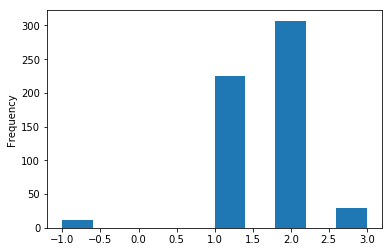

In [66]:
display(scipy.corr())
scipy['scipy_length_unweighted'].plot.hist()

## Predicting first move: 

In [67]:
display(scipy['scipy_length_weighted'].value_counts())
display(scipy['path_length_weighted'].value_counts())

0.493061       41
2.070142       39
0.393860       33
1.261404       28
0.867544       27
1.001473       25
1.425343       18
0.641789       18
1.637065       18
1.941502       13
0.694270       12
0.806653       12
1.592603       11
0.668767       11
1.075806       10
1.326142       10
0.937250        9
0.444189        9
1.325744        9
0.591130        9
1.200513        9
2.401948        9
9999.000000     9
1.156073        9
1.243205        8
0.832684        8
1.687394        7
1.232919        6
1.494534        6
0.541763        6
               ..
1.770076        2
1.378850        2
1.869017        1
1.474045        1
1.936394        1
2.089603        1
1.743903        1
1.582828        1
1.236033        1
1.085978        1
0.767968        1
2.375615        1
1.376471        1
1.574071        1
2.244203        1
1.231909        1
0.783813        1
1.549933        1
1.509333        1
1.207167        1
0.733483        1
1.443333        1
0.339623        1
2.487998        1
1.750536  

0.493061    37
0.393860    27
0.867544    24
1.001473    23
2.430535    18
0.641789    17
0.694270    12
0.000000    11
0.806653    10
0.591130     9
1.075806     9
1.156073     9
3.489915     9
3.496615     8
3.005239     7
2.414110     7
1.882458     7
1.425343     6
1.803166     6
0.541763     6
1.261404     5
1.674197     5
2.851816     4
0.832684     4
1.360604     4
1.735088     4
2.907170     4
0.719097     4
2.782625     4
3.207321     4
            ..
2.830269     1
3.881742     1
2.730144     1
2.675670     1
3.802773     1
1.443333     1
2.174406     1
3.608890     1
2.919877     1
5.427390     1
2.136323     1
2.957147     1
2.326217     1
3.982976     1
1.035649     1
2.180455     1
3.729128     1
2.193686     1
1.695743     1
0.838049     1
2.455694     1
2.075205     1
1.390852     1
1.933755     1
1.427753     1
3.138130     1
2.548889     1
1.736265     1
2.323134     1
3.912010     1
Name: path_length_weighted, Length: 235, dtype: int64

In [68]:
#extra function check whether first moves match for later use in z-test
def CheckFirstMove(row, weighted): 
    if weighted: 
        scipy = row.scipy_weighted
    else: 
        scipy = row.scipy_unweighted
    
    try: 
        if len(scipy) >= 2 and len(row.path) >= 2: 
            return scipy[1] == row.path[1]
        else: 
            print("Length error:", row.path, scipy)
            return -1
        
    except TypeError as t: 
        print("TypeError:", row.path, scipy)
        #print(t)
        return -1

scipy['first_move_unweighted'] = scipy.apply(lambda x: CheckFirstMove(x, False), axis=1)
scipy['first_move_weighted'] = scipy.apply(lambda x: CheckFirstMove(x, True), axis=1)

first_moves = scipy[scipy['first_move_weighted'] != -1]
display(first_moves['first_move_unweighted'].value_counts())
display(first_moves['first_move_weighted'].value_counts())
display(first_moves.shape)

Length error: ['Lesotho'] []
Length error: ['Moon'] []
Length error: ['Coal'] []
Length error: ['Pyramid'] []
Length error: ['Apple'] []
Length error: ['Snow_Goose'] []
Length error: ['Royal_Navy'] []
Length error: ['Abel_Tasman'] []
Length error: ['American_Samoa'] []
Length error: ['Florence_Nightingale'] []
Length error: ['William_and_Mary'] []
TypeError: ['Lesotho'] nan
Length error: ['Moon'] []
Length error: ['Coal'] []
TypeError: ['Pyramid'] nan
TypeError: ['Apple'] nan
TypeError: ['Snow_Goose'] nan
TypeError: ['Royal_Navy'] nan
TypeError: ['Abel_Tasman'] nan
TypeError: ['American_Samoa'] nan
TypeError: ['Florence_Nightingale'] nan
TypeError: ['William_and_Mary'] nan


False    356
True     205
Name: first_move_unweighted, dtype: int64

False    309
True     252
Name: first_move_weighted, dtype: int64

(561, 18)

In [71]:
#difference between proportions: 
from statsmodels.stats.proportion import proportions_ztest

#uncomment the line below to run the analyses if you're running with the FULL wiki graph 
#(won't run with the small_wiki)
# print(proportions_ztest(first_moves['first_move_unweighted'], first_moves['first_move_weighted']))

## Profiling: 

### Time:

In [ ]:
#originally timed with n = 10 for report, 
#timing with n =1 here so that it will finish in a reasonable amount of time
print("Dijkstra single process:")
%timeit DijkstraSingleProcess(small_wiki, with_wordnet, finished)

In [21]:
print("Dijkstra Parallel:")
%timeit -n 10 DFDijkstraParallel(finished, with_wordnet)

Dijkstra Parallel:
Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G
Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target 

Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G
Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or targ

Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G
Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G
Either source Lesotho or target Lesotho is not in G
Either source Py

Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G
Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G
Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or targ

Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G
Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G
Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_T

In [10]:
print("Floyd-Warshall:")
%timeit -n 10 ScipyTimeProfiler(small_wiki, with_wordnet)

Floyd-Warshall:
205 ms ± 6.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Memory: 

In [23]:
%load_ext memory_profiler
%memit -r 10 ScipyTimeProfiler(small_wiki, with_wordnet)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
peak memory: 699.60 MiB, increment: 4.47 MiB


In [76]:
%prun ScipyTimeProfiler(small_wiki, with_wordnet)

In [22]:
%memit DFDijkstraParallel(finished, with_wordnet)

Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_century not in G
Source 14th_ce

Source AIDS not in G
Source AIDS not in G
Source AIDS not in G
Source AIDS not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft not in G
Source Aircraft 

No path to Speed_of_light.
No path to Eastern_Orthodox_Church.
No path to Kuiper_belt.
No path to Eastern_Orthodox_Church.
No path to Monaco_Grand_Prix.
No path to Speed_of_light.
No path to Speed_of_light.
No path to Eastern_Orthodox_Church.
No path to Anatomy.
No path to Monaco_Grand_Prix.
No path to Anatomy.
No path to Speed_of_light.
No path to Penguin.
No path to Shelduck.
Source Animation not in G
No path to Speed_of_light.
Source Animation not in G
Source Animation not in G
No path to Anatomy.
Source Animation not in G
No path to Penguin.
Source Animation not in G
Source Animation not in G
Source Latin_alphabet not in G
No path to Mississippi_River.
Source Animation not in G
Source Latin_alphabet not in G
Source Latin_alphabet not in G
Source Latin_alphabet not in G
Source Latin_alphabet not in G
Source Latin_alphabet not in G
Source Latin_alphabet not in G
Source Old_English_language not in G
No path to United_States_Senate.
Source Old_English_language not in G
Source Old_Engli

No path to Piano.
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
No path to Mars.
Source Archbishop_of_Canterbury not in G
Source Muhammad not in G
Source Muhammad not in G
Source Music not in G
Source Music not in G
No path to Mars.
Source Music not in G
Source Music not in G
Source Music not in G
Source Music not in G
Source Music not in G
Source Music not in G
No path to Mars.
Source Music not in G
Source Music not in G
Source Music not in G
No path to Mars.
Source Music not in G
Source Music not in G
Source Music not in G
Source Music not in G
Source Music not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
Source Archbishop_of_Canterbury not in G
No path to Church_of

Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
No path to United_States_Constitution.
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Sri_Lankan_Civil_War not in G
No path to Qing_Dynasty.
Source Sri_Lankan_Civil_War not in G
Source Sri_Lankan_Civil_War not in G
No path to Flag_of_South_Africa.
Source Sri_Lankan_Civil_War not in G
No path to United_States_Constitution.
Source Sri_Lankan_Civil_War not in G
Source Sri_Lankan_Civil_War not in G
Source Sri_Lankan_Civil_War not in G
No path to Flag_of_South_Africa.
No path to United_States_Constitution.
Source Citrus not in G
No path to Flag_of_South_Africa.
Source Citrus not in G
Source Citrus not in G
No path to United_States_Constitution.
Source Citrus not in G
No path to Philosophy_of_mind.
Source Citrus not in G
Source Citrus not in G
Source Climate_change not in G
No path to United_States_Consti

Source Computer not in G
Source Computer not in G
Source Computer not in G
Source Computer not in G
Source Computer not in G
Source Computer not in G
Source Computer not in G
No path to Portuguese_language.
Source Computer not in G
Source Booby not in G
No path to Mango.
Source Booby not in G
Source Booby not in G
Source Booby not in G
No path to Mango.
Source Booby not in G
No path to Lom%C3%A9.
Source Booby not in G
No path to Mango.
Source Booby not in G
Source ASCII not in G
Source Ununhexium not in G
Source Ununhexium not in G
Source ASCII not in G
Source ASCII not in G
Source Ununhexium not in G
Source Ununhexium not in G
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
No path to Elementary_algebra.
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
No path to Nottingham.
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
Source Computer not in G
No path to Poetry.
So

Source Athens not in G
Source Continent not in G
Source Continent not in G
Source Athens not in G
Source Continent not in G
Source Visual_arts not in G
Source Athens not in G
Source Continent not in G
Source Athens not in G
Source Athens not in G
Source Continent not in G
Source Continent not in G
Source Athens not in G
Source Visual_arts not in G
Source Athens not in G
Source Continent not in G
Source Visual_arts not in G
Source Continent not in G
Source Visual_arts not in G
Source Continent not in G
Source Continent not in G
Source Visual_arts not in G
Source Continent not in G
Source Visual_arts not in G
Source Continent not in G
Source Continent not in G
Source Comics not in G
Source Nile not in G
Source Nile not in G
Source Noam_Chomsky not in G
Source Noam_Chomsky not in G
Source Noam_Chomsky not in G
Source Noam_Chomsky not in G
Source Comics not in G
Source Noam_Chomsky not in G
Source Noam_Chomsky not in G
Source Noam_Chomsky not in G
No path to Second_Congo_War.
Source Comics

Source Oceania not in G
Source Australian_Green_Tree_Frog not in G
Source One_Flew_Over_the_Cuckoo%27s_Nest_%28novel%29 not in G
Source Australian_Green_Tree_Frog not in G
Source One_Flew_Over_the_Cuckoo%27s_Nest_%28novel%29 not in G
No path to ASCII.
Source Australian_Green_Tree_Frog not in G
Source Open_source not in G
Source Australian_Green_Tree_Frog not in G
Source Open_source not in G
Source Australian_Green_Tree_Frog not in G
No path to Diego_Maradona.
Source Open_source not in G
No path to Elementary_arithmetic.
Source Australian_Green_Tree_Frog not in G
Source Australian_Green_Tree_Frog not in G
Source Australian_Green_Tree_Frog not in G
No path to Citrus.
Source Australian_Green_Tree_Frog not in G
Source Australian_Green_Tree_Frog not in G
No path to Citrus.
Source Australian_Green_Tree_Frog not in G
No path to Elementary_arithmetic.
Source Australian_Green_Tree_Frog not in G
Source Australian_Green_Tree_Frog not in G
Source Orca not in G
Source Australian_Green_Tree_Frog not

Source Backgammon not in G
Source Backgammon not in G
Source Dog not in G
Source Backgammon not in G
Source Paleontology not in G
Source Backgammon not in G
Source Paleontology not in G
Source Paleontology not in G
No path to Malaria.
Source Dog not in G
Source Paleontology not in G
Source Paleontology not in G
Source Dog not in G
No path to Malaria.
Source Dog not in G
Source Dog not in G
Source Dog not in G
Source Dog not in G
Source Bald_Eagle not in G
Source Dog not in G
Source Dog not in G
Source Bald_Eagle not in G
Source Dog not in G
Source Dog not in G
Source Dog not in G
Source Bald_Eagle not in G
Source Dog not in G
Source Bald_Eagle not in G
Source Dog not in G
Source Bald_Eagle not in G
Source Dog not in G
No path to United_Arab_Emirates.
Source Bald_Eagle not in G
No path to FIFA.
Source Bald_Eagle not in G
Source Bald_Eagle not in G
Source Bald_Eagle not in G
Source Dog not in G
No path to Winter.
No path to FIFA.
Source Bald_Eagle not in G
Source Bald_Eagle not in G
Sour

Source Batman not in G
Source Batman not in G
Source Batman not in G
No path to Interpol.
No path to The_Origin_of_Species.
No path to Phosphorus_trichloride.
Source Batman not in G
Source Batman not in G
Source Batman not in G
No path to Animation.
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
No path to Odysseus.
Source Batman not in G
No path to Animation.
Source Batman not in G
Source Batman not in G
Source Batman not in G
No path to Odysseus.
No path to Common_cold.
No path to Odysseus.
No path to Saxophone.
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
No path to Odysseus.
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
No path to Saxophone.
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
No path to Odysseus.
No path to Bean.
No path to Odysseus.
No path to Apple.
No path to Odyss

Source Batman not in G
Source Potato not in G
Source History not in G
Source Batman not in G
Source Education_in_the_United_States not in G
Source History not in G
Source Batman not in G
Source Humanities not in G
Source Batman not in G
Source Humanities not in G
Source Batman not in G
Source Education_in_the_United_States not in G
Source Potato not in G
Source Humanities not in G
Source Batman not in G
Source Potato not in G
Source Tropical_cyclone not in G
Source Batman not in G
Source Tropical_cyclone not in G
Source Batman not in G
Source Potato not in G
Source Batman not in G
Source Tropical_cyclone not in G
Source Batman not in G
No path to ASCII.
Source Potato not in G
Source Potato not in G
Source Potato not in G
Source Potato not in G
Source Potato not in G
Source Tropical_cyclone not in G
Source Potato not in G
Source Potato not in G
Source Potato not in G
Source Prime_Minister_of_the_United_Kingdom not in G
Source Prime_Minister_of_the_United_Kingdom not in G
Source Prime_Mi

Source Batman not in G
Source Pupil not in G
Source Batman not in G
Source Technology not in G
Source Pupil not in G
Source Batman not in G
Source Technology not in G
Source Batman not in G
Source Pupil not in G
Source Batman not in G
Source Pupil not in G
Source Technology not in G
Source Batman not in G
Source Pupil not in G
Source Technology not in G
Source Batman not in G
Source Pupil not in G
Source Batman not in G
Source Pupil not in G
Source Technology not in G
Source Batman not in G
No path to Anne_Frank.
Source Technology not in G
No path to Anne_Frank.
Source Technology not in G
Source Batman not in G
Source Technology not in G
Source Pupil not in G
Source Batman not in G
No path to Anne_Frank.
Source Information not in G
Source Batman not in G
Source Information not in G
Source Batman not in G
Source Information not in G
Source Batman not in G
Source Information not in G
Source Pupil not in G
Source Batman not in G
Source Information not in G
Source Batman not in G
Source Pu

No path to Quantum_mechanics.
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Batman not in G
Source Elizabeth_II_of_the_United_Kingdom not in G
Source Batman not in G
Source Batman not in G
Source Elizabeth_II_of_the_United_Kingdom not in G
Source Batman not in G
Source Elizabeth_II_of_the_United_Kingdom not in G
Source Batman not in G
Source Elizabeth_II_of_the_United_Kingdom not in G
Source Batman not in G
Source Elizabeth_II_of_the_United_Kingdom not in G
Source Batman not in G
Source Elizabeth_II_of_the_United_Kingdom not in G
Source Batman not in G
Source Emotion not in G
No path to Niagara_Falls.
Source Batman not in G
Source Emotion not in G
Source Batman not in G
No path to Erie_Canal.
Source Emotion not in G
Source Batman not in G
No path to Vitamin.
No path to Erie_Canal.
Source Emotion not in G
No path to Erie_Canal.
Source Emotion not in G
Source Emotion not in G
No path to Vitamin.
Source Emotion no

Source Beer not in G
Source Beer not in G
Source Beer not in G
Source Beer not in G
Source Beer not in G
No path to Chicago_Bears.
Source Beer not in G
Source Beer not in G
Source Beer not in G
No path to Greenland.
No path to Deity.
No path to Greenland.
No path to Deity.
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
Source Beer not in G
Source Beer not in G
No path to Blitzkrieg.
Source Beer not in G
Source Beer not in G
Source Beer not in G
Source Beer not in G
Source Beer not in G
Source Beer not in G
No path to Mark_Twain.
Source Beer not in G
Source Beer not in G
Source Beer not in G
Source Beer not in G
Source Organism not in G
Source Organism not in G
Source Organism not in G
No path to Windsor_Castle.
Source Organism not in G
Source Saffron not in G
So

Source Scooby-Doo not in G
No path to Train.
Source Scooby-Doo not in G
Source Scooby-Doo not in G
No path to Seoul.
Source Scooby-Doo not in G
No path to Akkadian_Empire.
Source Scooby-Doo not in G
Source Scooby-Doo not in G
Source FIFA not in G
Source Scooby-Doo not in G
No path to Telephone.
Source Scooby-Doo not in G
Source FIFA not in G
Source Scooby-Doo not in G
Source Scooby-Doo not in G
Source FIFA not in G
Source Scooby-Doo not in G
Source FIFA not in G
Source Scooby-Doo not in G
Source Dubai not in G
No path to French_language.
Source Scooby-Doo not in G
Source Dubai not in G
Source Dubai not in G
Source Dubai not in G
No path to Owl.
Source Dubai not in G
No path to Silicon.
Source Dubai not in G
Source Dubai not in G
No path to Silicon.
Source Dubai not in G
Source Dubai not in G
No path to Silicon.
Source Dubai not in G
Source Dubai not in G
No path to Drawing.
No path to Ice_hockey.
No path to Genoa.
No path to Spanish_Inquisition.
No path to Pablo_Picasso.
No path to Con

Source Frankenstein not in G
Source Frankenstein not in G
Source Frankenstein not in G
No path to Uzbekistan.
Source Frankenstein not in G
Source Frankenstein not in G
Source Frankenstein not in G
Source Scottish_mythology not in G
No path to Canadian_football.
Source Scottish_mythology not in G
Source Scottish_mythology not in G
No path to Life.
Source Scottish_mythology not in G
Source Scottish_mythology not in G
Source Scottish_mythology not in G
Source Scottish_mythology not in G
No path to Greek_War_of_Independence.
Source Scottish_mythology not in G
Source Scottish_mythology not in G
Source Scottish_mythology not in G
Source Scottish_mythology not in G
No path to CPU_cache.
No path to Island_Fox.
No path to Horse.
No path to Martina_Navratilova.
No path to Mississippi_River.
No path to Portsmouth.
Source Scottish_mythology not in G
Source Greek_mythology not in G
Source Greek_mythology not in G
Source Greek_mythology not in G
Source Greek_mythology not in G
Source Greek_mythology

No path to Superconductivity.
No path to Persian_Gulf.
Source Sperm_Whale not in G
Source Sperm_Whale not in G
No path to Superconductivity.
Source Sperm_Whale not in G
Source Sperm_Whale not in G
Source Sperm_Whale not in G
No path to Great_white_shark.
Source Sperm_Whale not in G
Source Sperm_Whale not in G
Source Sperm_Whale not in G
No path to Superconductivity.
Source Sperm_Whale not in G
No path to Great_white_shark.
No path to Platypus.
Source Star_anise not in G
No path to Beach.
No path to Thorium.
No path to Great_white_shark.
Source Star_anise not in G
Source Star_anise not in G
Source Star_anise not in G
No path to Great_white_shark.
Source Star_anise not in G
No path to Beach.
Source Superman not in G
No path to Periodic_table_%28large_version%29.
Source Superman not in G
Source Superman not in G
Source First_Macedonian_War not in G
Source Superman not in G
No path to Great_white_shark.
Source Superman not in G
Source First_Macedonian_War not in G
Source Superman not in G


Source Diplodocus not in G
Source Force not in G
Source Diplodocus not in G
Source Force not in G
Source Great_Rift_Valley not in G
Source Force not in G
Source Great_Rift_Valley not in G
Source Force not in G
Source Great_Rift_Valley not in G
No path to Cyclops.
No path to Great_white_shark.
No path to Cyclops.
Source Force not in G
Source Force not in G
Source Force not in G
No path to Great_white_shark.
Source Force not in G
Source Great_Rift_Valley not in G
Source Force not in G
Source Great_Rift_Valley not in G
No path to Cyclops.
Source Force not in G
Source Great_Rift_Valley not in G
No path to Great_white_shark.
Source Porto-Novo not in G
Source Porto-Novo not in G
Source Porto-Novo not in G
Source Forth not in G
Source Porto-Novo not in G
Source Forth not in G
No path to Cyclops.
Source East_Africa not in G
No path to Great_white_shark.
Source East_Africa not in G
Source Forth not in G
Source East_Africa not in G
Source Forth not in G
Source East_Africa not in G
Source Forth n

Source The_Lion_King not in G
Source Frog not in G
No path to Great_white_shark.
Source Functional_programming not in G
Source The_Lion_King not in G
Source Functional_programming not in G
Source Leon_Trotsky not in G
Source The_Lion_King not in G
Source Functional_programming not in G
Source The_Lion_King not in G
Source The_Lion_King not in G
Source Functional_programming not in G
No path to Great_white_shark.
Source The_Lion_King not in G
Source Leon_Trotsky not in G
Source Leon_Trotsky not in G
No path to Great_white_shark.
Source Leon_Trotsky not in G
Source Leon_Trotsky not in G
No path to Great_white_shark.
Source Leon_Trotsky not in G
Source Leon_Trotsky not in G
Source Leon_Trotsky not in G
Source Functional_programming not in G
Source Mexico_City not in G
Source Functional_programming not in G
Source Mexico_City not in G
Source Mexico_City not in G
Source Functional_programming not in G
Source Mexico_City not in G
Source Fungus not in G
Source Mexico_City not in G
Source Fung

Source Geology not in G
Source Timeline_of_discovery_of_solar_system_planets_and_their_natural_satellites not in G
Source The_Lord_of_the_Rings not in G
Source Geology not in G
No path to Great_white_shark.
Source Timeline_of_discovery_of_solar_system_planets_and_their_natural_satellites not in G
Source Geology not in G
Source The_Lord_of_the_Rings not in G
Source Timeline_of_discovery_of_solar_system_planets_and_their_natural_satellites not in G
Source Geology not in G
Source The_Lord_of_the_Rings not in G
Source Timeline_of_discovery_of_solar_system_planets_and_their_natural_satellites not in G
Source Geology not in G
Source The_Lord_of_the_Rings not in G
Source Geology not in G
Source Timeline_of_discovery_of_solar_system_planets_and_their_natural_satellites not in G
Source The_Lord_of_the_Rings not in G
Source Timeline_of_discovery_of_solar_system_planets_and_their_natural_satellites not in G
Source Geology not in G
No path to Great_white_shark.
Source Geology not in G
Source Timel

Source Color_blindness not in G
Source Bird_migration not in G
Source Bird_migration not in G
Source Color_blindness not in G
Source Bird_migration not in G
Source Color_blindness not in G
Source Color_blindness not in G
Source Bird_migration not in G
Source Color_blindness not in G
Source Bird_migration not in G
Source Color_blindness not in G
Source Bird_migration not in G
No path to Jerusalem.
Source Bird_migration not in G
Source Bird_migration not in G
Source Bird_migration not in G
Source Bird_migration not in G
No path to Zebra.
Source Color_blindness not in G
Source Bird_migration not in G
Source Stroke not in G
Source Bird_migration not in G
Source Stroke not in G
Source Bird_migration not in G
Source Stroke not in G
Source Bird_migration not in G
Source Stroke not in G
Source Bird_migration not in G
Source Stroke not in G
Source Bird_migration not in G
Source Stroke not in G
Source Bird_migration not in G
Source Stroke not in G
Source Bird_migration not in G
Source Bird_migra

Source University_of_Chicago not in G
Source University_of_Chicago not in G
No path to Karl_Marx.
Source University_of_Chicago not in G
Source Homer not in G
Source University_of_Chicago not in G
Source Homer not in G
Source Uranium not in G
Source Uranium not in G
Source Homer not in G
Source Uranium not in G
Source Homer not in G
Source Uranium not in G
Source Odyssey not in G
Source Odyssey not in G
Source Odyssey not in G
Source Odyssey not in G
Source Odyssey not in G
Source Odyssey not in G
Source Odyssey not in G
Source Uranium not in G
Source Odyssey not in G
Source Odyssey not in G
Source Uranium not in G
Source Odyssey not in G
Source Uranium not in G
Source Odyssey not in G
Source Uranium not in G
Source Odyssey not in G
Source Uranium not in G
Source Epic_of_Gilgamesh not in G
Source Uranium not in G
Source Uranium not in G
Source Uranium not in G
Source Uranium not in G
Source Uranium not in G
Source Uranium not in G
Source Uranium not in G
Source Uranium not in G
Source E

Source Gregorian_chant not in G
No path to Northern_Mariana_Islands.
Source Gregorian_chant not in G
Source Brothers_Grimm not in G
No path to London_Underground.
Source Gregorian_chant not in G
No path to Alphabet.
Source Guangzhou not in G
Source Guangzhou not in G
Source Calculus not in G
No path to London_Underground.
Source Guangzhou not in G
Source Calculus not in G
Source Calculus not in G
Source Guangzhou not in G
No path to Alphabet.
Source Calculus not in G
Source Guangzhou not in G
No path to London_Underground.
Source Guinea not in G
Source Calculus not in G
Source Calculus not in G
Source Guinea not in G
No path to London_Underground.
No path to Alphabet.
Source Calculus not in G
No path to Malcolm_III_of_Scotland.
Source Calculus not in G
Source Calculus not in G
Source Calculus not in G
Source Guinea not in G
No path to Sumatra.
Source Calculus not in G
Source Guinea not in G
Source Calculus not in G
No path to Windows_Vista.
Source Calculus not in G
Source Guinea not in

Source Ho_Chi_Minh_City not in G
Source Antoine_Lavoisier not in G
Source Ho_Chi_Minh_City not in G
Source Antoine_Lavoisier not in G
Source Ho_Chi_Minh_City not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Honduras not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Honduras not in G
Source Star_Trek__Deep_Space_Nine not in G
No path to Wine.
Source Star_Trek__Deep_Space_Nine not in G
No path to Pyramid.
Source Honduras not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Honduras not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Honduras not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Honduras not in G
Source Star_Trek__Deep_Space_Nine not in G
No path to Pyramid.
Source Honduras not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Honduras not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Star_Trek__Deep_Space_Nine not in G
Source Honduras n

No path to Bee.
Source Wikipedia not in G
Source Wikipedia not in G
Source Wikipedia not in G
Source Wikipedia not in G
No path to Ocean.
Source Wikipedia not in G
No path to Heracles.
Source Wikipedia not in G
Source Wikipedia not in G
No path to Cooperative.
Source Wikipedia not in G
Source Wikipedia not in G
No path to Heracles.
No path to Swiss_Federal_Council.
No path to Fidel_Castro.
Source Wikipedia not in G
Source Humanism not in G
Source Wikipedia not in G
Source Humanism not in G
No path to Coccinellidae.
No path to Birmingham.
Source Humanism not in G
Source Humanism not in G
Source Wikipedia not in G
No path to Coccinellidae.
Source Humanism not in G
Source Wikipedia not in G
Source Humanism not in G
Source Wikipedia not in G
Source Humanism not in G
No path to Canadian_football.
Source Humanism not in G
Source Wikipedia not in G
Source Wikipedia not in G
Source Wikipedia not in G
No path to Coccinellidae.
Source Wikipedia not in G
No path to Canadian_football.
Source Wikip

Source World_Wide_Web not in G
Source Cat not in G
No path to Dubai.
No path to Rabat.
Source World_Wide_Web not in G
No path to Los_Angeles%2C_California.
Source World_Wide_Web not in G
Source World_Wide_Web not in G
No path to Antelope.
Source Cat not in G
Source World_Wide_Web not in G
Source Cat not in G
Source World_Wide_Web not in G
Source World_Wide_Web not in G
Source Cat not in G
Source World_Wide_Web not in G
Source Cat not in G
Source World_Wide_Web not in G
Source Cat not in G
Source Zinc not in G
Source Zinc not in G
Source Zinc not in G
Source Cat not in G
No path to Seychelles.
No path to Banjul.
Source Cat not in G
No path to Seychelles.
Source Cat not in G
Source Cat not in G
No path to Nepal.
Source Cat not in G
No path to 55_Cancri_b.
Source Cat not in G
Source Cat not in G
Source Cat not in G
Source Zinc not in G
No path to Francium.
Source Cat not in G
Source Zinc not in G
Source Cat not in G
Source Zinc not in G
Source Cat not in G
Source Zinc not in G
Source Cat 

Source Genetics not in G
Source Cat not in G
Source Burkina_Faso not in G
Source Genetics not in G
Source Burkina_Faso not in G
Source Cat not in G
Source Burkina_Faso not in G
Source Genetics not in G
Source Cat not in G
Source Set not in G
Source Set not in G
Source Genetics not in G
Source Cat not in G
Source Set not in G
Source Cat not in G
Source Genetics not in G
Source Graphic_novel not in G
No path to Monaco.
Source Set not in G
Source Cat not in G
Source Set not in G
Source Graphic_novel not in G
Source Cat not in G
No path to Alpaca.
Source Cat not in G
Source Graphic_novel not in G
Source Cat not in G
Source Cat not in G
Source Graphic_novel not in G
Source Cat not in G
Source Graphic_novel not in G
Source Cat not in G
Source Set not in G
No path to Banana.
Source Graphic_novel not in G
Source Cat not in G
Source Graphic_novel not in G
Source Cat not in G
Source Graphic_novel not in G
Source Cat not in G
Source Cat not in G
Source Graphic_novel not in G
Source Set not in G
S

Source Paul_McCartney not in G
Source Chemistry not in G
Source British_Virgin_Islands not in G
Source Paul_McCartney not in G
Source Chemistry not in G
Source British_Virgin_Islands not in G
Source British_Virgin_Islands not in G
No path to Northwest_Africa.
Source Paul_McCartney not in G
Source Paul_McCartney not in G
No path to Continent.
Source Paul_McCartney not in G
Source British_Virgin_Islands not in G
Source Hurricane_Dennis not in G
Source British_Virgin_Islands not in G
Source Hurricane_Dennis not in G
Source Hurricane_Dennis not in G
Source British_Virgin_Islands not in G
Source Hurricane_Dennis not in G
Source Hurricane_Dennis not in G
Source British_Virgin_Islands not in G
Source Hurricane_Dennis not in G
Source Hurricane_Dennis not in G
Source Diamond not in G
Source Asteroid not in G
Source Diamond not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Diamond not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid 

Source Asteroid not in G
No path to Civilization.
Source Asteroid not in G
No path to The_Legend_of_Zelda_series.
No path to War.
No path to Sputnik_1.
No path to War.
Source Asteroid not in G
Source Asteroid not in G
No path to Palm_oil.
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
No path to War.
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
No path to Telephone.
Source Asteroid not in G
No path to Freetown.
No path to Telephone.
No path to Yugoslavia.
Source Asteroid not in G
Source Asteroid not in G
No path to Telephone.
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
No path to Alcibiades.
Source Asteroid not in G
Source Khan_Wali_Khan not in G
Source Khan_Wali_Khan not in G
Source Asteroid not in G
Source Asteroid not in G
Source Khan_Wali_Khan not in G
Source Asteroid not in G
Source Khan_Wali_Khan not in G
Source Asteroid not in G
Source Asteroid not in G
No path to Te

Source Asteroid not in G
Source Nutmeg not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Nutmeg not in G
Source Asteroid not in G
Source Asteroid not in G
Source Nutmeg not in G
No path to Electric_charge.
Source Nutmeg not in G
Source Asteroid not in G
Source Nutmeg not in G
Source Asteroid not in G
Source Nutmeg not in G
Source Asteroid not in G
No path to Wine.
Source Asteroid not in G
Source Nutmeg not in G
Source Nutmeg not in G
Source Asteroid not in G
Source Nutmeg not in G
Source Asteroid not in G
Source High_German_consonant_shift not in G
No path to Wine.
Source High_German_consonant_shift not in G
Source Asteroid not in G
Source Asteroid not in G
Source High_German_consonant_shift not in G
No path to Wine.
Source Asteroid not in G
Source High_German_consonant_shift not in G
Source Asteroid not in G
Source High_German_consonant_shift not in G
No path to Roman_law.
Source Asteroid not in G
Source Asteroid not in G
No path to DNA.
Source

Source 16th_century not in G
Source Kazakhstan not in G
Source Asteroid not in G
Source Kazakhstan not in G
Source Asteroid not in G
Source 16th_century not in G
Source Kazakhstan not in G
Source Asteroid not in G
Source 16th_century not in G
Source Kazakhstan not in G
Source 16th_century not in G
Source Asteroid not in G
Source 16th_century not in G
Source 16th_century not in G
Source 16th_century not in G
Source 16th_century not in G
Source Kazakhstan not in G
Source 16th_century not in G
Source Kazakhstan not in G
Source 15th_century not in G
Source Asteroid not in G
Source 15th_century not in G
Source Kazakhstan not in G
Source 15th_century not in G
Source Kazakhstan not in G
Source 15th_century not in G
Source Kazakhstan not in G
Source 15th_century not in G
Source Asteroid not in G
Source 15th_century not in G
Source Asteroid not in G
Source 15th_century not in G
Source Asteroid not in G
Source 15th_century not in G
Source Kazakhstan not in G
Source 15th_century not in G
Source 1

Source Asteroid not in G
Source Lake_Tanganyika not in G
Source Ganesha not in G
Source Asteroid not in G
Source Ganesha not in G
Source Asteroid not in G
Source Ganesha not in G
Source Asteroid not in G
Source Lake_Tanganyika not in G
Source Ganesha not in G
Source Asteroid not in G
Source Lake_Tanganyika not in G
Source Asteroid not in G
Source Lake_Tanganyika not in G
Source Asteroid not in G
No path to Nairobi.
Source Asteroid not in G
Source Asteroid not in G
Source Lake_Tanganyika not in G
Source Asteroid not in G
Source Lake_Tanganyika not in G
Source Asteroid not in G
No path to Yemen.
No path to Apollo.
Source Lake_Tanganyika not in G
Source Lake_Tanganyika not in G
No path to Yemen.
Source Lake_Tanganyika not in G
Source Lake_Tanganyika not in G
Source Lake_Tanganyika not in G
No path to Apollo.
Source Asteroid not in G
No path to 1755_Lisbon_earthquake.
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
No path to 1755_Lisbon_earthquake.
Source Astero

No path to Polonium.
Source 17th_century not in G
Source 17th_century not in G
Source 17th_century not in G
Source 17th_century not in G
No path to Sand.
Source Johann_Sebastian_Bach not in G
Source Johann_Sebastian_Bach not in G
Source Linguistics not in G
Source Johann_Sebastian_Bach not in G
No path to Sand.
Source Johann_Sebastian_Bach not in G
Source Linguistics not in G
Source Johann_Sebastian_Bach not in G
Source Asteroid not in G
Source Johann_Sebastian_Bach not in G
Source Asteroid not in G
Source Linguistics not in G
Source Johann_Sebastian_Bach not in G
Source Asteroid not in G
Source Johann_Sebastian_Bach not in G
Source Linguistics not in G
Source Johann_Sebastian_Bach not in G
Source Asteroid not in G
Source Johann_Sebastian_Bach not in G
Source Asteroid not in G
Source Johann_Sebastian_Bach not in G
Source Linguistics not in G
Source Johann_Sebastian_Bach not in G
Source Asteroid not in G
No path to Zambia.
Source Johann_Sebastian_Bach not in G
Source Asteroid not in G
S

Source Piano not in G
Source Asteroid not in G
Source Piano not in G
Source Lost_%28TV_series%29 not in G
Source Asteroid not in G
Source Lost_%28TV_series%29 not in G
Source Asteroid not in G
Source Lost_%28TV_series%29 not in G
Source Piano not in G
Source Asteroid not in G
Source Piano not in G
Source Love not in G
Source Asteroid not in G
Source Piano not in G
Source Love not in G
No path to Buenos_Aires.
Source Asteroid not in G
Source Love not in G
Source Piano not in G
Source Asteroid not in G
Source Piano not in G
Source Love not in G
Source Love not in G
Source Piano not in G
Source Asteroid not in G
Source Love not in G
No path to Pond.
Source Asteroid not in G
Source Piano not in G
Source Musical_instrument not in G
Source Love not in G
No path to Trichinosis.
Source Musical_instrument not in G
Source Love not in G
Source Musical_instrument not in G
Source Love not in G
No path to Uruguay.
Source Love not in G
Source Asteroid not in G
Source Love not in G
Source Asteroid not

Source Manchester not in G
Source Metallurgy not in G
Source Manchester not in G
Source Metallurgy not in G
Source Manchester not in G
Source Metallurgy not in G
Source Manchester not in G
Source Manchester not in G
Source Metallurgy not in G
Source Manchester not in G
No path to Gulf_of_Mexico.
Source Manchester not in G
No path to Wellington.
Source Manchester not in G
Source Manchester not in G
Source Manchester not in G
No path to Crystal.
Source Manchester not in G
Source Manchester not in G
Source Manchester not in G
Source Manchester not in G
No path to Tokyo.
Source Manchester not in G
Source Manchester not in G
Source Manchester not in G
No path to British_House_of_Commons.
No path to Tokyo.
No path to Triassic.
No path to Fedora_Core.
Source Manchester not in G
No path to Triassic.
Source Manchester not in G
No path to Bull_shark.
Source Manchester not in G
No path to Triassic.
Source Manchester not in G
Source Manchester not in G
No path to Amsterdam.
Source Manchester not i

Source Caribbean_Sea not in G
Source Caribbean_Sea not in G
Source Bah%C3%A1%27%C3%AD_Faith not in G
Source Drought not in G
Source Caribbean_Sea not in G
Source Drought not in G
Source Drought not in G
Source Caribbean_Sea not in G
No path to Alfred_Nobel.
Source Drought not in G
Source Drought not in G
No path to Summer.
Source Effects_of_global_warming not in G
Source Effects_of_global_warming not in G
No path to Mississippi_River.
Source Effects_of_global_warming not in G
Source Effects_of_global_warming not in G
Source Effects_of_global_warming not in G
Source Effects_of_global_warming not in G
Source Effects_of_global_warming not in G
No path to Stonehenge.
Source Effects_of_global_warming not in G
Source Fossil_fuel not in G
Source Fossil_fuel not in G
Source Fossil_fuel not in G
Source Fossil_fuel not in G
Source Fossil_fuel not in G
No path to Stonehenge.
Source Fossil_fuel not in G
No path to Stonehenge.
Source Fossil_fuel not in G
Source Fossil_fuel not in G
No path to Sputn

No path to Johannesburg.
Source Universe not in G
Source Suffrage not in G
Source Universe not in G
Source Suffrage not in G
Source Universe not in G
Source Suffrage not in G
Source Universe not in G
Source Suffrage not in G
Source Universe not in G
Source Suffrage not in G
No path to Oat.
Source Universe not in G
Source Anarchism not in G
Source Anarchism not in G
Source Universe not in G
Source Anarchism not in G
Source Universe not in G
Source Anarchism not in G
Source Universe not in G
Source Universe not in G
Source Anarchism not in G
Source Universe not in G
Source Anarchism not in G
No path to Sichuan_Pepper.
Source GNU not in G
Source GNU not in G
Source GNU not in G
Source GNU not in G
Source Universe not in G
Source GNU not in G
Source GNU not in G
Source Screw not in G
Source GNU not in G
Source Screw not in G
Source GNU not in G
Source GNU not in G
Source Screw not in G
Source GNU not in G
Source Screw not in G
Source GNU not in G
Source Anarchism not in G
Source Screw not 

Source Felix_the_Cat not in G
Source Raney_nickel not in G
Source Felix_the_Cat not in G
Source Albert_Einstein not in G
Source Raney_nickel not in G
Source Felix_the_Cat not in G
Source Felix_the_Cat not in G
Source Raney_nickel not in G
Source Raney_nickel not in G
Source Felix_the_Cat not in G
Source Weapon not in G
Source Felix_the_Cat not in G
Source Albert_Einstein not in G
Source Felix_the_Cat not in G
Source Weapon not in G
Source Felix_the_Cat not in G
Source Weapon not in G
Source Albert_Einstein not in G
Source Felix_the_Cat not in G
Source Weapon not in G
Source Felix_the_Cat not in G
Source Albert_Einstein not in G
Source Weapon not in G
Source Felix_the_Cat not in G
Source Albert_Einstein not in G
Source Weapon not in G
Source Felix_the_Cat not in G
Source Weapon not in G
Source Albert_Einstein not in G
Source Felix_the_Cat not in G
Source Weapon not in G
Source James_Clerk_Maxwell not in G
Source Muscat%2C_Oman not in G
Source Weapon not in G
Source Weapon not in G
Sourc

Source Corrosion not in G
Source Vladimir_Lenin not in G
Source Nineteen_Eighty-Four not in G
Source Flood not in G
Source Corrosion not in G
Source North_Sea not in G
Source Cadmium not in G
Source North_Sea not in G
Source Cadmium not in G
Source North_Sea not in G
Source Cadmium not in G
Source Rhythm_and_blues not in G
Source Cadmium not in G
Source North_Sea not in G
Source North_Sea not in G
Source Cadmium not in G
Source Vladimir_Lenin not in G
Source Cadmium not in G
Source Rhythm_and_blues not in G
Source North_Sea not in G
Source Rhythm_and_blues not in G
Source Cadmium not in G
Source North_Sea not in G
Source Cadmium not in G
Source Cadmium not in G
Source North_Sea not in G
Source Cadmium not in G
Source Rhythm_and_blues not in G
Source North_Sea not in G
Source Cadmium not in G
Source Lead not in G
Source Vladimir_Lenin not in G
Source Lead not in G
Source Vladimir_Lenin not in G
Source Lead not in G
Source Lead not in G
Source Vladimir_Lenin not in G
Source North_Sea not

Source Essential_oil not in G
Source World_Health_Organization not in G
Source Tyrannosaurus not in G
No path to Juice.
Source Essential_oil not in G
Source World_Health_Organization not in G
Source Ecology not in G
Source World_Health_Organization not in G
Source World_Health_Organization not in G
Source World_Health_Organization not in G
Source Ecology not in G
Source Essential_oil not in G
Source World_Health_Organization not in G
Source Ecology not in G
Source World_Health_Organization not in G
Source Ecology not in G
Source Essential_oil not in G
Source World_Health_Organization not in G
Source Ancient_Egypt not in G
Source Essential_oil not in G
Source Horse not in G
Source Horse not in G
Source Essential_oil not in G
Source Horse not in G
Source Ancient_Egypt not in G
Source Horse not in G
Source Essential_oil not in G
Source Horse not in G
No path to Lemon.
Source Essential_oil not in G
No path to Pea.
Source Ancient_Egypt not in G
Source Gray_Wolf not in G
Source Gray_Wolf not

Source Photosynthesis not in G
Source Gas not in G
Source Star_Trek not in G
Source Photosynthesis not in G
Source Archaeopteryx not in G
Source Star_Trek not in G
Source Gas not in G
Source Archaeopteryx not in G
Source Photosynthesis not in G
Source Star_Trek not in G
Source Photosynthesis not in G
Source Gas not in G
Source Electromagnetic_radiation not in G
Source Gas not in G
Source Star_Trek not in G
Source Electromagnetic_radiation not in G
Source Photosynthesis not in G
Source Owl not in G
Source Gas not in G
Source Electromagnetic_radiation not in G
Source Owl not in G
Source Gas not in G
Source Electromagnetic_radiation not in G
Source Photosynthesis not in G
Source Gas not in G
Source Owl not in G
Source Electromagnetic_radiation not in G
Source Photosynthesis not in G
Source Owl not in G
Source Gas not in G
Source Electromagnetic_radiation not in G
Source Owl not in G
Source Gas not in G
Source Photosynthesis not in G
Source Electromagnetic_radiation not in G
Source Owl not

Source Quantum_chemistry not in G
Source Mississippi_River not in G
Source Microsoft_Windows not in G
Source Quantum_chemistry not in G
Source Bread not in G
Source Mississippi_River not in G
Source Microsoft_Windows not in G
Source Quantum_chemistry not in G
Source Bread not in G
Source Mississippi_River not in G
Source Microsoft_Windows not in G
Source Quantum_chemistry not in G
Source Bread not in G
Source Microsoft_Windows not in G
Source Mississippi_River not in G
Source Quantum_chemistry not in G
Source Bread not in G
Source Mississippi_River not in G
Source Microsoft_Windows not in G
Source Quantum_chemistry not in G
Source Bread not in G
Source Mississippi_River not in G
Source Microsoft not in G
Source Quantum_chemistry not in G
Source Bread not in G
Source Microsoft not in G
Source Mississippi_River not in G
Source Salt not in G
Source Bread not in G
Source Mississippi_River not in G
Source Microsoft not in G
Source Salt not in G
Source Bread not in G
Source Mississippi_River

Source La_Paz not in G
Source Spanish_language not in G
Source La_Paz not in G
Source Spanish_language not in G
No path to Saxophone.
Source La_Paz not in G
Source 18th_century not in G
Source 18th_century not in G
No path to Ho_Chi_Minh_City.
No path to Republic_of_China.
Source La_Paz not in G
Source 18th_century not in G
Source La_Paz not in G
No path to Republic_of_China.
Source La_Paz not in G
Source 18th_century not in G
No path to Ho_Chi_Minh_City.
Source La_Paz not in G
Source 18th_century not in G
Source Sea not in G
Source 18th_century not in G
Source Sea not in G
Source 18th_century not in G
Source Sea not in G
Source Sea not in G
Source 18th_century not in G
Source Sea not in G
Source Beijing not in G
Source Sea not in G
Source Beijing not in G
Source Axe not in G
Source Beijing not in G
Source Axe not in G
No path to Republic_of_China.
Source Beijing not in G
No path to Joseph_Stalin.
Source Beijing not in G
No path to Tunis.
No path to Republic_of_China.
Source Axe not in

Source Erie_Canal not in G
Source Coventry not in G
Source Oregano not in G
No path to Pythagorean_theorem.
Source Coventry not in G
Source Erie_Canal not in G
Source Oregano not in G
Source Oregano not in G
Source Erie_Canal not in G
Source Coventry not in G
Source Coventry not in G
Source Oregano not in G
Source Erie_Canal not in G
Source Oregano not in G
Source Oregano not in G
Source Canterbury not in G
Source Parsley not in G
No path to Bruce_Springsteen.
Source Erie_Canal not in G
Source Canterbury not in G
Source Parsley not in G
Source Erie_Canal not in G
Source Parsley not in G
Source Canterbury not in G
Source Erie_Canal not in G
Source Parsley not in G
No path to Cologne.
Source Parsley not in G
Source Canterbury not in G
Source Parsley not in G
Source Erie_Canal not in G
Source Parsley not in G
Source Canterbury not in G
No path to Denver%2C_Colorado.
Source Parsley not in G
Source Erie_Canal not in G
Source Parsley not in G
Source Erie_Canal not in G
Source James_Bond not 

Source Rocky_Mountains not in G
Source Kyoto_Protocol not in G
Source Rocky_Mountains not in G
Source Kyoto_Protocol not in G
Source Rocky_Mountains not in G
Source Celine_Dion not in G
No path to Mount_Everest.
Source Rocky_Mountains not in G
Source Celine_Dion not in G
Source Rocky_Mountains not in G
Source Celine_Dion not in G
Source Rocky_Mountains not in G
Source Rocky_Mountains not in G
Source Celine_Dion not in G
Source Video not in G
No path to Matter.
Source Celine_Dion not in G
Source Celine_Dion not in G
No path to Mount_Everest.
No path to Mahatma_Gandhi.
Source Celine_Dion not in G
Source Celine_Dion not in G
No path to Real_tennis.
Source Celine_Dion not in G
No path to Paraguay.
Source Celine_Dion not in G
Source Western_Roman_Empire not in G
Source Celine_Dion not in G
Source Western_Roman_Empire not in G
Source Video not in G
Source Celine_Dion not in G
Source Western_Roman_Empire not in G
Source Celine_Dion not in G
Source Western_Roman_Empire not in G
Source Video no

Source Sigmund_Freud not in G
Source Book not in G
Source Stefan_Edberg not in G
Source Book not in G
Source Compact_Disc not in G
Source Book not in G
Source Stefan_Edberg not in G
Source Compact_Disc not in G
Source Book not in G
Source Stefan_Edberg not in G
Source Compact_Disc not in G
Source Formic_acid not in G
Source Stefan_Edberg not in G
No path to Lawn.
Source Formic_acid not in G
Source Stefan_Edberg not in G
Source Formic_acid not in G
Source Stefan_Edberg not in G
Source Compact_Disc not in G
Source Formic_acid not in G
Source Compact_Disc not in G
Source Formic_acid not in G
Source Compact_Disc not in G
Source Formic_acid not in G
Source Compact_Disc not in G
Source Formic_acid not in G
Source Compact_Disc not in G
Source Stefan_Edberg not in G
Source Formic_acid not in G
Source Flemish_people not in G
Source Compact_Disc not in G
Source Formic_acid not in G
Source Flemish_people not in G
Source Compact_Disc not in G
Source Formic_acid not in G
Source Compact_Disc not in 

Source Carrot not in G
Source Invasive_species not in G
Source Brain not in G
Source Geography not in G
Source Invasive_species not in G
Source Brain not in G
Source Geography not in G
Source Carrot not in G
Source Brain not in G
Source Invasive_species not in G
Source Geography not in G
Source Carrot not in G
Source Carrot not in G
Source Dallas%2C_Texas not in G
Source Geography not in G
Source Brain not in G
Source Geography not in G
Source Dallas%2C_Texas not in G
Source Carrot not in G
Source Brain not in G
Source Carrot not in G
Source Dallas%2C_Texas not in G
Source Brain not in G
Source Geography not in G
Source Geography not in G
Source Dallas%2C_Texas not in G
Source Brain not in G
Source Carrot not in G
Source Dallas%2C_Texas not in G
Source Carrot not in G
Source Brain not in G
Source Marco_Polo not in G
Source Dallas%2C_Texas not in G
Source Carrot not in G
Source Dallas%2C_Texas not in G
Source Brain not in G
Source Marco_Polo not in G
Source Carrot not in G
Source Dallas

Source Pyramid not in G
Source The_Hobbit not in G
Source Glass not in G
Source Brain not in G
Source Pyramid not in G
Source Glass not in G
Source The_Hobbit not in G
Source Brain not in G
Source Pyramid not in G
Source Glass not in G
Source The_Hobbit not in G
Source Brain not in G
Source Pyramid not in G
Source Glass not in G
Source Brain not in G
Source The_Hobbit not in G
Source Pyramid not in G
Source Glass not in G
Source Brain not in G
Source The_Hobbit not in G
Source Glass not in G
Source Pyramid not in G
Source The_Hobbit not in G
Source Brain not in G
Source Brain not in G
Source The_Hobbit not in G
Source Glass not in G
Source Brain not in G
Source Glass not in G
Source Pyramid not in G
Source Brain not in G
Source Glass not in G
Source The_Hobbit not in G
Source Pyramid not in G
Source Brain not in G
Source The_Hobbit not in G
Source Glass not in G
Source Pyramid not in G
Source Brain not in G
Source The_Hobbit not in G
Source Glass not in G
Source Brain not in G
Source P

No path to Romeo_and_Juliet.
Source Pyramid not in G
Source Brain not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
No path to The_Ashes.
Source Brain not in G
Source Pyramid not in G
No path to Falcon.
Source Ghana not in G
Source Pyramid not in G
Source Ghana not in G
Source Ghana not in G
Source Pyramid not in G
Source Ghana not in G
No path to Genghis_Khan.
Source Ghana not in G
Source Pyramid not in G
Source Ghana not in G
Source Pyramid not in G
Source Ghana not in G
Source Pyramid not in G
Source Ghana not in G
Source Pyramid not in G
Source Ghana not in G
Source Pyramid not in G
Source Brain not in G
Source Ghana not in G
Source Pyramid not in G
Source Brain not in G
Source Ghana not in G
Source Pyramid not in G
Source Brain not in G
Source Pyramid not in G
No path to Ch

Source Brain not in G
Source Vitamin_D not in G
Source Pyramid not in G
Source Brain not in G
Source Vitamin_D not in G
Source The_Brothers_Karamazov not in G
Source The_Brothers_Karamazov not in G
Source Vitamin_D not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Vitamin_D not in G
Source Pyramid not in G
Source The_Brothers_Karamazov not in G
Source Brain not in G
Source Tide not in G
Source Tide not in G
Source Tide not in G
Source Brain not in G
Source Vitamin_D not in G
Source Brain not in G
Source Tide not in G
Source Vitamin_D not in G
Source Tide not in G
Source Brain not in G
Source Vitamin_D not in G
Source Brain not in G
Source Tide not in G
Source Vitamin_D not in G
Source Pyramid not in G
Source Tide not in G
Source Vitamin_D not in G
Source Brain not in G
Source Pyramid not in G
Source Tide not in G
Source Brain not in G
Source Vitamin_D not in G
Source Sea_level_rise not in G
Source Pyramid not in G
Source Brain not in G
Source Sea_level

Source Lettuce not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
No path to Osama_bin_Laden.
Source Brain not in G
Source Lettuce not in G
No path to Theatre.
Source Lettuce not in G
Source Pyramid not in G
Source Lettuce not in G
Source Brain not in G
No path to Theatre.
Source Brain not in G
Source Arugula not in G
Source Pyramid not in G
Source Brain not in G
Source Arugula not in G
Source Pyramid not in G
Source Arugula not in G
Source Brain not in G
No path to Theatre.
Source Arugula not in G
Source Pyramid not in G
Source Brain not in G
Source Arugula not in G
Source Brain not in G
Source Pyramid not in G
Source Basil not in G
Source Brain not in G
Source Pyramid not in G
Source Brain not in G
Source Basil not in G
Source Pyramid not in G
Source Brain not in G
Source Basil not in G
Source Pyramid not in G
Source Basil not in G
Source Brain not in G
Source Pyramid not in G
Source Basil not in G
Source Brain not in G
Source Pyramid not in G
No path to Hus

Source Brain not in G
Source Hirohito not in G
Source Barn_Owl not in G
Source Brain not in G
Source Hirohito not in G
Source Barn_Owl not in G
Source Brain not in G
No path to International_human_rights_instruments.
Source Barn_Owl not in G
Source Hirohito not in G
Source Brain not in G
Source Barn_Owl not in G
Source Hirohito not in G
Source Brain not in G
Source Brain not in G
No path to Butter.
Source Brain not in G
Source Brain not in G
Source Brain not in G
Source Brain not in G
Source Barn_Owl not in G
Source Brain not in G
Source Brain not in G
Source Cholera not in G
Source Hirohito not in G
Source Brain not in G
Source Brain not in G
Source Hirohito not in G
No path to The_Last_Supper_%28Leonardo%29.
Source Cholera not in G
Source Brain not in G
Source Brain not in G
Source Cholera not in G
Source Elvis_Presley not in G
Source Brain not in G
Source Cholera not in G
Source Elvis_Presley not in G
Source Brain not in G
Source Cholera not in G
Source Elvis_Presley not in G
No pat

Source Equatorial_Guinea not in G
Source United_States_Constitution not in G
Source Stage_%28theatre%29 not in G
Source Equatorial_Guinea not in G
Source Stage_%28theatre%29 not in G
Source United_States_Constitution not in G
Source 19th_century not in G
Source Equatorial_Guinea not in G
Source Mountain_Gorilla not in G
Source United_States_Constitution not in G
Source 19th_century not in G
Source Equatorial_Guinea not in G
Source 19th_century not in G
Source United_States_Constitution not in G
Source Viking not in G
No path to Weather_forecasting.
No path to Ancient_Rome.
Source Viking not in G
No path to Weather_forecasting.
Source Viking not in G
Source Viking not in G
No path to Ancient_Rome.
Source Viking not in G
No path to Corundum.
Source Viking not in G
No path to Ancient_Rome.
Source Viking not in G
Source Viking not in G
No path to Islamic_republic.
Source Viking not in G
Source Viking not in G
No path to Gauss%27s_law.
Source Viking not in G
No path to Tawny_Owl.
No path to

Source Rainforest not in G
Source Karl_Marx not in G
Source Karl_Marx not in G
Source Windows_XP not in G
Source Thrasybulus not in G
Source Rainforest not in G
Source Karl_Marx not in G
Source Thrasybulus not in G
Source Rainforest not in G
Source Karl_Marx not in G
Source Thrasybulus not in G
Source Karl_Marx not in G
Source Rainforest not in G
Source Thrasybulus not in G
Source Rainforest not in G
Source Windows_XP not in G
Source Karl_Marx not in G
Source Plasma_%28physics%29 not in G
Source BASIC not in G
Source Thrasybulus not in G
Source Rainforest not in G
Source Plasma_%28physics%29 not in G
Source Rainforest not in G
Source Cape_Porcupine not in G
Source BASIC not in G
Source Bridge not in G
Source BASIC not in G
Source Yangtze_River not in G
Source Rainforest not in G
Source Bridge not in G
Source BASIC not in G
Source Yangtze_River not in G
Source Bridge not in G
Source BASIC not in G
Source Yangtze_River not in G
Source BASIC not in G
Source Yangtze_River not in G
Source R

Source Samuel_Beckett not in G
Source Gustav_Holst not in G
Source Venus not in G
Source Samuel_Beckett not in G
Source Gustav_Holst not in G
Source Cryptography not in G
Source Hydrochloric_acid not in G
Source Venus not in G
Source Hydrochloric_acid not in G
Source Hydrochloric_acid not in G
Source Gustav_Holst not in G
Source Venus not in G
Source Cryptography not in G
Source Hydrochloric_acid not in G
Source Venus not in G
Source Hydrochloric_acid not in G
Source Gustav_Holst not in G
Source Venus not in G
Source Hydrochloric_acid not in G
Source Gustav_Holst not in G
Source Cryptography not in G
Source Venus not in G
Source Hydrochloric_acid not in G
Source Gustav_Holst not in G
Source Hydrochloric_acid not in G
Source Venus not in G
Source Nuclear_power not in G
Source Gustav_Holst not in G
Source Venus not in G
Source Nuclear_power not in G
Source Cryptography not in G
Source Nuclear_power not in G
Source Venus not in G
Source Gustav_Holst not in G
Source Nuclear_power not in G


Source Keira_Knightley not in G
Source Last_Supper not in G
Source American_Revolutionary_War not in G
Source Last_Supper not in G
Source Keira_Knightley not in G
Source Last_Supper not in G
Source Keira_Knightley not in G
Source Last_Supper not in G
Source Keira_Knightley not in G
Source Last_Supper not in G
Source Keira_Knightley not in G
Source Last_Supper not in G
Source Keira_Knightley not in G
Source Yeast not in G
Source Keira_Knightley not in G
Source Yeast not in G
Source Keira_Knightley not in G
Source Yeast not in G
Source Fatty_acid not in G
Source Yeast not in G
Source Fatty_acid not in G
Source American_Revolutionary_War not in G
Source Yeast not in G
Source Fatty_acid not in G
Source American_Revolutionary_War not in G
Source Yeast not in G
Source Fatty_acid not in G
Source Yeast not in G
Source Fatty_acid not in G
Source American_Revolutionary_War not in G
Source Fatty_acid not in G
Source Metamorphic_rock not in G
Source American_Revolutionary_War not in G
Source Fatty

Source Ancient_history not in G
Source Ruthenium not in G
Source Ancient_history not in G
No path to Milk.
Source Ruthenium not in G
Source Ancient_history not in G
Source Ruthenium not in G
Source Ancient_history not in G
Source Ruthenium not in G
Source Ancient_history not in G
No path to Milk.
Source Ancient_history not in G
Source Ruthenium not in G
Source Ancient_history not in G
Source Ruthenium not in G
Source Ancient_history not in G
Source Ruthenium not in G
Source Ancient_history not in G
Source Goose not in G
Source The_Hague not in G
Source Magellanic_Penguin not in G
Source Goose not in G
Source The_Hague not in G
Source Magellanic_Penguin not in G
Source Goose not in G
Source Magellanic_Penguin not in G
No path to Milk.
Source The_Hague not in G
Source Goose not in G
Source Typhoon_Saomai_%282006%29 not in G
Source The_Hague not in G
Source Canada_Goose not in G
Source Typhoon_Saomai_%282006%29 not in G
Source The_Hague not in G
Source Canada_Goose not in G
Source Typhoon

Source Voting not in G
Source Wheat not in G
Source Voting not in G
Source Wheat not in G
Source Voting not in G
Source Santa_Claus not in G
Source Voting not in G
Source Wheat not in G
Source Santa_Claus not in G
Source Voting not in G
Source 1st_century not in G
Source Santa_Claus not in G
Source 1st_century not in G
Source Voting not in G
Source 1st_century not in G
Source Voting not in G
Source Santa_Claus not in G
Source 1st_century not in G
Source Voting not in G
Source Santa_Claus not in G
Source 1st_century not in G
Source Voting not in G
Source Santa_Claus not in G
Source Santa_Claus not in G
Source Santa_Claus not in G
Source Santa_Claus not in G
Source Santa_Claus not in G
Source 1st_century not in G
Source Santa_Claus not in G
Source Voting not in G
Source Santa_Claus not in G
Source 1st_century not in G
Source Voting not in G
Source Santa_Claus not in G
Source 1st_century not in G
Source Voting not in G
Source Santa_Claus not in G
Source 1st_century not in G
Source Voting 

Source Thunderstorm not in G
Source Thunderstorm not in G
No path to Season.
Source Thunderstorm not in G
Source Thunderstorm not in G
Source Trinidad_and_Tobago not in G
Source Thunderstorm not in G
Source Thunderstorm not in G
Source Quartz not in G
Source Buffy_the_Vampire_Slayer not in G
Source Buffy_the_Vampire_Slayer not in G
Source Quartz not in G
Source Buffy_the_Vampire_Slayer not in G
Source Quartz not in G
Source Buffy_the_Vampire_Slayer not in G
Source Quartz not in G
No path to Marshall_Islands.
Source Quartz not in G
Source Quartz not in G
Source Quartz not in G
No path to Marshall_Islands.
Source Quartz not in G
Source Quartz not in G
Source Buffy_the_Vampire_Slayer not in G
Source Quartz not in G
Source Buffy_the_Vampire_Slayer not in G
No path to Bran.
Source Quartz not in G
Source Buffy_the_Vampire_Slayer not in G
Source British_Isles_%28terminology%29 not in G
Source Buffy_the_Vampire_Slayer not in G
Source British_Isles_%28terminology%29 not in G
No path to Bran.
So

Source Bee not in G
Source Ganges_River not in G
Source Protoceratops not in G
Source Bee not in G
Source Ganges_River not in G
Source Bee not in G
Source Derby not in G
Source Derby not in G
Source Bee not in G
Source Bee not in G
Source Guatemala not in G
Source Protoceratops not in G
Source Derby not in G
Source Bee not in G
Source Derby not in G
Source Protoceratops not in G
Source Bee not in G
Source Derby not in G
Source Protoceratops not in G
Source Bee not in G
Source Derby not in G
Source Protoceratops not in G
Source Guatemala not in G
Source Bee not in G
Source J._M._W._Turner not in G
Source Protoceratops not in G
Source Bee not in G
Source J._M._W._Turner not in G
Source Bee not in G
Source J._M._W._Turner not in G
Source Protoceratops not in G
Source Guatemala not in G
Source J._M._W._Turner not in G
Source Bee not in G
Source Guatemala not in G
Source J._M._W._Turner not in G
Source Guatemala not in G
Source Bee not in G
Source Protoceratops not in G
Source J._M._W._Turn

Source Fundamental_theorem_of_arithmetic not in G
Source Battle_of_Amiens not in G
Source Beriberi not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Berkelium not in G
Source Paprika not in G
Source Battle_of_Amiens not in G
Source Berkelium not in G
Source Paprika not in G
Source Battle_of_Amiens not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Paprika not in G
Source Battle_of_Amiens not in G
Source Berkelium not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Battle_of_Amiens not in G
Source Paprika not in G
Source Battle_of_Amiens not in G
Source Berkelium not in G
Source Paprika not in G
Source Battle_of_Amiens not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Helicobacter_pylori not in G
Source Paprika not in G
Source Fundamental_theorem_of_arithmetic not in G
Source Japanese_yen not in G
Source Berkelium not in G
Source Paprika not in G
Source Japanese_yen not in G
Source Bernard_Hinault not in G
Source Fundamental_t

Source Potassium_iodide not in G
Source Parsnip not in G
Source History_of_computing_hardware not in G
Source Potassium_iodide not in G
Source History_of_computing_hardware not in G
Source Parsnip not in G
Source History_of_computing_hardware not in G
Source Potassium_iodide not in G
Source Bird_of_prey not in G
Source History_of_computing_hardware not in G
Source Potassium_iodide not in G
Source Parsnip not in G
Source Bird_of_prey not in G
Source Parsnip not in G
Source Bird_of_prey not in G
Source Bologna not in G
Source Parsnip not in G
Source Bologna not in G
Source Parsnip not in G
Source Bird_of_prey not in G
Source History_of_computing_hardware not in G
Source Hasekura_Tsunenaga not in G
Source Bologna not in G
Source Bird_of_prey not in G
Source Hasekura_Tsunenaga not in G
Source Bologna not in G
Source Birmingham not in G
Source Hasekura_Tsunenaga not in G
Source History_of_computing_hardware not in G
Source Birmingham not in G
Source Bologna not in G
Source Hasekura_Tsunenag

Source Black_panther not in G
Source Safflower not in G
Source Marie_Curie not in G
Source Saint_Helena not in G
Source Safflower not in G
Source Black_panther not in G
Source Marie_Curie not in G
Source Saint_Helena not in G
Source Safflower not in G
Source Black_panther not in G
Source Marie_Curie not in G
Source DNA_repair not in G
Source Marie_Curie not in G
Source Black_panther not in G
Source Saint_Helena not in G
Source DNA_repair not in G
Source Black_panther not in G
Source Saint_Helena not in G
Source Marie_Curie not in G
Source DNA_repair not in G
Source Black_panther not in G
Source Saint_Helena not in G
Source DNA_repair not in G
Source Marie_Curie not in G
Source Blackcap not in G
Source Saint_Helena not in G
Source DNA_repair not in G
Source Blackcap not in G
Source Saint_Helena not in G
Source Marie_Curie not in G
Source Blackcap not in G
Source Saint_Helena not in G
Source DNA_repair not in G
Source Marie_Curie not in G
Source Saint_Helena not in G
Source Blackcap not 

Source Baseball not in G
Source League_of_Nations not in G
Source Blue_Wildebeest not in G
Source Mustard_plant not in G
Source Blue_shark not in G
Source League_of_Nations not in G
Source Baseball not in G
Source Bran not in G
Source African_Brush-tailed_Porcupine not in G
Source Baseball not in G
Source Blue_shark not in G
Source African_Brush-tailed_Porcupine not in G
Source Baseball not in G
Source Bran not in G
Source Proxima_Centauri not in G
Source Blue_shark not in G
Source Baseball not in G
Source Proxima_Centauri not in G
Source Blue_shark not in G
Source Bran not in G
Source Proxima_Centauri not in G
Source Baseball not in G
Source Blue_shark not in G
Source Proxima_Centauri not in G
Source Blue_shark not in G
Source Baseball not in G
Source Bran not in G
Source Proxima_Centauri not in G
Source Baseball not in G
Source Bran not in G
Source Blue_shark not in G
Source Proxima_Centauri not in G
Source Blue_shark not in G
Source Baseball not in G
Source Proxima_Centauri not in G

Source British_English not in G
Source Bobcat not in G
Source British_English not in G
Source Butter not in G
Source South_China_Sea not in G
Source Body_mass_index not in G
Source South_China_Sea not in G
Source Body_mass_index not in G
Source South_China_Sea not in G
Source South_China_Sea not in G
Source Body_mass_index not in G
Source South_China_Sea not in G
Source Body_mass_index not in G
Source Body_mass_index not in G
Source South_China_Sea not in G
Source Body_mass_index not in G
Source South_China_Sea not in G
Source Butter not in G
Source Isambard_Kingdom_Brunel not in G
Source Body_mass_index not in G
Source Sardar_Vallabhbhai_Patel not in G
Source Bodyline not in G
Source Isambard_Kingdom_Brunel not in G
Source Bodyline not in G
Source Isambard_Kingdom_Brunel not in G
Source Butter not in G
Source Isambard_Kingdom_Brunel not in G
Source Sardar_Vallabhbhai_Patel not in G
Source Bodyline not in G
Source Isambard_Kingdom_Brunel not in G
Source Bodyline not in G
Source Butter 

Source Buddhist_art not in G
Source Cricket not in G
Source Weasel not in G
Source Flamingo not in G
Source Cricket not in G
Source Weasel not in G
Source Flamingo not in G
Source Buddhist_art not in G
Source Cricket not in G
Source Black_Seminoles not in G
Source Flamingo not in G
Source Black_Seminoles not in G
Source Cricket not in G
Source Flamingo not in G
Source Buddhist_art not in G
Source Black_Seminoles not in G
Source Cricket not in G
Source Flamingo not in G
Source Black_Seminoles not in G
Source Buddhist_art not in G
Source Cricket not in G
Source Flamingo not in G
Source Andrew_Jackson not in G
Source Cricket not in G
Source Flamingo not in G
Source Buddhist_art not in G
Source Cricket not in G
Source Andrew_Jackson not in G
Source Flamingo not in G
Source Andrew_Jackson not in G
Source Buddhist_art not in G
Source List_of_Oceanian_countries not in G
Source Ferdinand_Magellan not in G
Source Thomas_Jefferson not in G
Source Buddhist_art not in G
Source Flamingo not in G
So

Source Mark_Twain_House not in G
Source Cai_Lun not in G
Source Cambrian not in G
Source Cai_Lun not in G
Source Mark_Twain_House not in G
Source Cambrian not in G
Source Cai_Lun not in G
Source Mark_Twain_House not in G
Source Hurricane_Ivan not in G
Source Calligraphy not in G
Source Mark_Twain_House not in G
Source Calligraphy not in G
Source Mark_Twain_House not in G
Source Hurricane_Ivan not in G
No path to Trojan_War.
Source Mark_Twain_House not in G
Source Calligraphy not in G
Source Hurricane_Ivan not in G
Source Meningitis not in G
Source Calligraphy not in G
Source Hurricane_Ivan not in G
Source Calligraphy not in G
Source Meningitis not in G
Source Hurricane_Ivan not in G
Source Meningitis not in G
Source Calligraphy not in G
Source Hurricane_Ivan not in G
Source Meningitis not in G
Source Calligraphy not in G
Source Hurricane_Ivan not in G
Source Meningitis not in G
Source Calligraphy not in G
Source Hurricane_Ivan not in G
Source Calligraphy not in G
Source Meningitis not 

Source Seychelles not in G
Source Wood_fuel not in G
Source Wood_fuel not in G
Source The_Lion%2C_the_Witch_and_the_Wardrobe not in G
Source Canadian_House_of_Commons not in G
Source Seychelles not in G
Source Adam_Smith not in G
Source The_Lion%2C_the_Witch_and_the_Wardrobe not in G
Source Wood_fuel not in G
Source Canadian_House_of_Commons not in G
Source Adam_Smith not in G
Source The_Lion%2C_the_Witch_and_the_Wardrobe not in G
Source Wood_fuel not in G
Source Canadian_Pacific_Railway not in G
Source Adam_Smith not in G
Source The_Lion%2C_the_Witch_and_the_Wardrobe not in G
Source Wood_fuel not in G
Source Canadian_Pacific_Railway not in G
Source The_Lion%2C_the_Witch_and_the_Wardrobe not in G
Source Drum_and_bass not in G
Source Adam_Smith not in G
Source Canadian_Pacific_Railway not in G
Source Adam_Smith not in G
Source The_Lion%2C_the_Witch_and_the_Wardrobe not in G
Source Canadian_Pacific_Railway not in G
Source Drum_and_bass not in G
Source Canadian_Senate not in G
Source Adam

Source Alexander_Graham_Bell not in G
Source Dante_Alighieri not in G
Source Community not in G
Source Colima_%28volcano%29 not in G
Source Alexander_Graham_Bell not in G
Source Colima_%28volcano%29 not in G
Source Community not in G
Source Dante_Alighieri not in G
Source Alexander_Graham_Bell not in G
Source Community not in G
Source Colima_%28volcano%29 not in G
Source Alexander_Hamilton not in G
Source Community not in G
Source Colima_%28volcano%29 not in G
Source Dante_Alighieri not in G
Source Community not in G
Source Alexander_Hamilton not in G
Source Interpol not in G
Source Alexander_Hamilton not in G
Source Community not in G
Source Interpol not in G
Source Dante_Alighieri not in G
Source Alexander_Hamilton not in G
Source Community not in G
Source Interpol not in G
Source Alexander_Hamilton not in G
Source Community not in G
Source Alexander_Hamilton not in G
Source Interpol not in G
Source Dante_Alighieri not in G
Source Alexander_Hamilton not in G
Source Community not in G

Source Alpaca not in G
Source Contact_lens not in G
Source Paraguay not in G
Source African_American_literature not in G
Source Alpaca not in G
Source African_American_literature not in G
Source Contact_lens not in G
Source Alpaca not in G
Source African_American_literature not in G
Source Alpaca not in G
Source Alpaca not in G
Source African_American_literature not in G
Source Contact_lens not in G
Source Alpaca not in G
Source Alpaca not in G
Source African_American_literature not in G
Source Paraguay not in G
Source Continental_crust not in G
Source Alpaca not in G
Source Alpaca not in G
Source Continental_crust not in G
Source U2 not in G
Source Alpaca not in G
Source Continental_crust not in G
Source Alpaca not in G
Source U2 not in G
Source U2 not in G
Source Continental_crust not in G
Source Alpaca not in G
Source Paraguay not in G
Source Alpaca not in G
Source Continental_crust not in G
Source U2 not in G
Source Alpaca not in G
Source Continental_crust not in G
Source U2 not in

Source Corporate_finance not in G
Source Amur not in G
Source Kookaburra not in G
Source Martinique not in G
Source Corporate_finance not in G
Source Kookaburra not in G
Source Martinique not in G
Source Amur not in G
Source Amur not in G
Source Kookaburra not in G
Source Martinique not in G
Source Corporate_finance not in G
Source Kookaburra not in G
Source Amur not in G
Source Martinique not in G
Source Martinique not in G
Source Kookaburra not in G
Source Corporate_finance not in G
Source Analytical_Marxism not in G
Source Analytical_Marxism not in G
Source Kookaburra not in G
Source Mickey_Mantle not in G
Source Kookaburra not in G
Source Corporate_finance not in G
Source Mickey_Mantle not in G
Source Analytical_Marxism not in G
Source Corporate_finance not in G
Source Analytical_Marxism not in G
Source Mickey_Mantle not in G
Source Corporate_finance not in G
Source Kookaburra not in G
Source Analytical_Marxism not in G
Source Corporate_finance not in G
Source Mickey_Mantle not in 

Source Crab_Nebula not in G
Source Angel_shark not in G
Source Gibraltar not in G
Source Extinct_birds not in G
Source Crab_Nebula not in G
Source Angel_shark not in G
Source Crab_Nebula not in G
Source Angel_shark not in G
Source Extinct_birds not in G
Source Angel_shark not in G
Source Extinct_birds not in G
Source Gibraltar not in G
Source Crab_Nebula not in G
Source Angel_shark not in G
Source Gibraltar not in G
Source Extinct_birds not in G
Source Crash_test_dummy not in G
Source Angel_shark not in G
Source Crash_test_dummy not in G
Source Extinct_birds not in G
Source Gibraltar not in G
Source Crash_test_dummy not in G
Source Angel_shark not in G
Source Extinct_birds not in G
Source Angel_shark not in G
Source Crash_test_dummy not in G
Source Gibraltar not in G
Source Angel_shark not in G
Source Crash_test_dummy not in G
Source Extinct_birds not in G
Source Gibraltar not in G
Source Angel_shark not in G
Source Crash_test_dummy not in G
Source Extinct_birds not in G
Source Angel_s

Source Cuckmere_Haven not in G
Source BP not in G
Source Lanthanum not in G
Source Antananarivo not in G
Source BP not in G
Source Peter_Grimes not in G
Source Cuckmere_Haven not in G
Source BP not in G
Source Antananarivo not in G
Source BP not in G
Source Cuckmere_Haven not in G
Source BP not in G
Source Antananarivo not in G
Source Cultural_diversity not in G
Source Peter_Grimes not in G
Source BP not in G
Source Antananarivo not in G
Source BP not in G
Source Peter_Grimes not in G
Source Cultural_diversity not in G
Source Antananarivo not in G
Source BP not in G
Source Cultural_diversity not in G
Source Peter_Grimes not in G
Source Henry_VIII_of_England not in G
Source Antarctic_Treaty_System not in G
Source Henry_VIII_of_England not in G
Source Cultural_diversity not in G
Source Antarctic_Treaty_System not in G
Source Rook_%28bird%29 not in G
Source Rook_%28bird%29 not in G
Source Cultural_diversity not in G
Source Rook_%28bird%29 not in G
Source Cyanocobalamin not in G
Source Cya

Source Arctic_Monkeys not in G
Source Daniel_Day-Lewis not in G
Source Arctic_Monkeys not in G
Source Daniel_Day-Lewis not in G
Source Arctic_Monkeys not in G
Source Daniel_Day-Lewis not in G
Source Arctic_Monkeys not in G
Source Lutetium not in G
Source Daniel_Day-Lewis not in G
Source Daniel_Day-Lewis not in G
Source Arctic_Monkeys not in G
Source Daniel_Ellsberg not in G
Source Arctic_Monkeys not in G
Source Lutetium not in G
Source Arctic_Monkeys not in G
Source Daniel_Ellsberg not in G
Source Lutetium not in G
Source Danske_Statsbaner not in G
Source Lutetium not in G
Source Thulium not in G
Source Thulium not in G
Source Thulium not in G
Source Arctic_Monkeys not in G
Source Erbium not in G
Source Danske_Statsbaner not in G
Source Erbium not in G
Source Arctic_Monkeys not in G
Source Danske_Statsbaner not in G
Source Erbium not in G
Source Arctic_Monkeys not in G
Source Erbium not in G
Source Arctic_Monkeys not in G
Source Erbium not in G
Source Danske_Statsbaner not in G
Source 

Source Economy_of_the_Iroquois not in G
Source Death_Valley_National_Park not in G
Source Economy_of_the_Iroquois not in G
Source Death_Valley_National_Park not in G
Source Xenon not in G
Source Death_Valley_National_Park not in G
Source Arsenic not in G
Source Xenon not in G
Source Death_Valley_National_Park not in G
Source Xenon not in G
Source Arsenic not in G
Source Death_Valley_National_Park not in G
Source Arsenic not in G
Source Xenon not in G
Source Death_Valley_National_Park not in G
Source Xenon not in G
Source Death_Valley_National_Park not in G
Source Arsenic not in G
Source Tern not in G
Source Death_Valley_National_Park not in G
Source Arsenic not in G
Source Decade_Volcanoes not in G
Source Tern not in G
Source Arsenic not in G
Source Decade_Volcanoes not in G
Source Arsenic not in G
Source Arsenic not in G
Source Decade_Volcanoes not in G
Source Arsenic not in G
Source Decade_Volcanoes not in G
Source Arsenic not in G
Source Toluene not in G
Source Decade_Volcanoes not 

Source Attention-deficit_hyperactivity_disorder not in G
Source Diego_Maradona not in G
Source Attention-deficit_hyperactivity_disorder not in G
Source Enzyme_kinetics not in G
Source Famine not in G
Source Attention-deficit_hyperactivity_disorder not in G
Source Diego_Maradona not in G
Source Attention-deficit_hyperactivity_disorder not in G
Source Diego_Maradona not in G
Source Differential_equation not in G
Source Attention-deficit_hyperactivity_disorder not in G
Source Enzyme_kinetics not in G
Source Enzyme_kinetics not in G
Source Famine not in G
Source Attention-deficit_hyperactivity_disorder not in G
Source Famine not in G
Source Differential_equation not in G
Source Attention-deficit_hyperactivity_disorder not in G
Source Famine not in G
Source Eocene not in G
Source Attila_the_Hun not in G
Source Famine not in G
Source Attila_the_Hun not in G
Source Famine not in G
Source Differential_equation not in G
Source Eocene not in G
Source Differential_equation not in G
Source Attila_

Source Euphrates not in G
Source Donald_Duck not in G
Source Autism not in G
Source Euphrates not in G
Source Euphrates not in G
Source Autism not in G
Source Donald_Duck not in G
Source Eurasian_Collared_Dove not in G
Source Autism not in G
Source Donald_Duck not in G
Source Eurasian_Collared_Dove not in G
Source Autism not in G
Source Donald_Duck not in G
Source Eurasian_Collared_Dove not in G
Source Autism not in G
Source Donald_Duck not in G
Source Autism not in G
Source Eurasian_Collared_Dove not in G
Source Donald_Duck not in G
Source Autism not in G
Source Eurasian_Collared_Dove not in G
Source Donald_Duck not in G
Source Autism not in G
Source Eurasian_Eagle_Owl not in G
Source Donald_Duck not in G
Source Autocracy not in G
Source Eurasian_Eagle_Owl not in G
Source Autocracy not in G
Source Donald_Duck not in G
Source Eurasian_Eagle_Owl not in G
Source Automated_teller_machine not in G
Source Donald_Duck not in G
Source Eurasian_Eagle_Owl not in G
Source Donald_Duck not in G
So

Source Korea not in G
Source Korea not in G
Source Drosophila_melanogaster not in G
Source Drosophila_melanogaster not in G
Source Korea not in G
Source F-4_Phantom_II not in G
Source Korea not in G
Source Drosophila_melanogaster not in G
Source F-4_Phantom_II not in G
Source Du_Fu not in G
Source Korea not in G
Source F-4_Phantom_II not in G
Source Du_Fu not in G
Source Korea not in G
Source Babe_Ruth not in G
Source F-4_Phantom_II not in G
Source Du_Fu not in G
Source Korea not in G
Source Fair_Isle not in G
Source Du_Fu not in G
Source Korea not in G
Source Fair_Isle not in G
Source Du_Fu not in G
Source Korea not in G
Source Du_Fu not in G
Source Koryaksky not in G
Source Dubnium not in G
Source Fair_Isle not in G
Source Babe_Ruth not in G
Source Fair_Isle not in G
Source Koryaksky not in G
Source Dundee_United_F.C. not in G
Source Koryaksky not in G
Source Babe_Ruth not in G
Source Dundee_United_F.C. not in G
Source Fair_Isle not in G
Source Babe_Ruth not in G
Source Dundee_United

Source Ku_Klux_Klan not in G
Source EMD_F7 not in G
Source Firearm not in G
Source Ku_Klux_Klan not in G
Source EMD_F7 not in G
Source Banana not in G
Source First_Council_of_Nicaea not in G
Source Banana not in G
Source First_Council_of_Nicaea not in G
Source EMD_F7 not in G
Source Ku_Klux_Klan not in G
Source Banana not in G
Source First_Council_of_Nicaea not in G
Source EMD_F7 not in G
Source Ku_Klux_Klan not in G
Source First_Council_of_Nicaea not in G
Source Banana not in G
Source EMD_F7 not in G
Source First_Council_of_Nicaea not in G
Source Banana not in G
Source EMD_F7 not in G
Source Banana not in G
Source First_Crusade not in G
Source EMD_F7 not in G
Source Ku_Klux_Klan not in G
Source Banana not in G
Source EMD_F7 not in G
Source First_Crusade not in G
Source Banana not in G
Source First_Crusade not in G
Source Banana not in G
Source Earl_of_Shaftesbury not in G
Source First_Crusade not in G
Source Banana not in G
Source Earl_of_Shaftesbury not in G
Source Banana not in G
So

Source Economy_of_India not in G
Source Labor_Day_Hurricane_of_1935 not in G
Source Economy_of_India not in G
Source Barley not in G
Source Labor_Day_Hurricane_of_1935 not in G
Source Economy_of_India not in G
Source Barley not in G
Source Labor_Day_Hurricane_of_1935 not in G
Source Economy_of_Pakistan not in G
Source Barnacle not in G
Source Labor_Day_Hurricane_of_1935 not in G
Source Barnacle not in G
Source Economy_of_Pakistan not in G
Source Barnacle not in G
Source Labor_Day_Hurricane_of_1935 not in G
Source Barnacle not in G
Source Economy_of_Pakistan not in G
Source Barnacle not in G
Source Ladysmith_Black_Mambazo not in G
Source Economy_of_Pakistan not in G
Source Barnacle not in G
Source Ladysmith_Black_Mambazo not in G
Source Economy_of_Pakistan not in G
Source Barracuda not in G
Source Flag_of_South_Africa not in G
Source Ladysmith_Black_Mambazo not in G
Source Economy_of_Pakistan not in G
Source Ladysmith_Black_Mambazo not in G
Source Barracuda not in G
Source Economy_of_Pa

Source Edward_Jenner not in G
Source Lake_Tahoe not in G
Source Forrest_Gump not in G
Source Edward_Jenner not in G
Source Forrest_Gump not in G
Source Lake_Tahoe not in G
Source Edward_Jenner not in G
Source Lake_Tahoe not in G
Source Forrest_Gump not in G
Source Forrest_Gump not in G
Source Lake_Tahoe not in G
Source Forrest_Gump not in G
Source Lake_Tahoe not in G
Source Fox not in G
Source Lake_Tahoe not in G
Source Fox not in G
Source Edward_Jenner not in G
Source Lake_Tahoe not in G
Source Fox not in G
Source Lake_Tahoe not in G
Source Edward_Jenner not in G
Source Fox not in G
Source Edward_Teller not in G
Source Fox not in G
Source Lake_Titicaca not in G
Source Fox not in G
Source Edward_Teller not in G
Source Lake_Titicaca not in G
Source Fox not in G
Source Edward_Teller not in G
Source Lake_Titicaca not in G
Source Fox not in G
Source Edward_Teller not in G
Source Lake_Titicaca not in G
Source Fox not in G
Source Edward_Teller not in G
Source Lake_Titicaca not in G
Source Fo

Source Election not in G
Source Frederick_Douglass not in G
Source Election not in G
Source Lawrencium not in G
Source Election not in G
Source Lawrencium not in G
Source French_Guiana not in G
Source Election not in G
Source Lawrencium not in G
Source French_Guiana not in G
Source Election not in G
Source Lawrencium not in G
Source French_Guiana not in G
Source Election not in G
Source Lawrencium not in G
Source French_Guiana not in G
Source Election not in G
Source Layla not in G
Source French_Guiana not in G
Source Election not in G
Source Layla not in G
Source French_Guiana not in G
Source Election not in G
Source French_Polynesia not in G
Source Layla not in G
Source French_Polynesia not in G
Source Election not in G
Source Layla not in G
Source French_Polynesia not in G
Source Election not in G
Source French_Polynesia not in G
Source Leeds not in G
Source Electrical_resistance not in G
Source Funchal not in G
Source Leeds not in G
Source Funchal not in G
Source Electrical_resista

Source Pheidippides not in G
Source Emirate not in G
Source Gas_metal_arc_welding not in G
Source Pheidippides not in G
Source Library not in G
Source Pheidippides not in G
Source Emirate not in G
Source Gas_metal_arc_welding not in G
Source Philadelphia not in G
Source Gas_metal_arc_welding not in G
Source Library not in G
Source Emirate not in G
Source Gas_metal_arc_welding not in G
Source Emirate not in G
Source Gas_metal_arc_welding not in G
Source Gas_turbine-electric_locomotive not in G
Source Emirate not in G
Source Gas_turbine-electric_locomotive not in G
Source Library not in G
Source Gas_turbine-electric_locomotive not in G
Source Gas_turbine-electric_locomotive not in G
Source Emperor_Penguin not in G
Source Gas_turbine-electric_locomotive not in G
Source Library not in G
Source Gas_turbine-electric_locomotive not in G
Source Emperor_Penguin not in G
Source Philadelphia not in G
Source Gas_turbine-electric_locomotive not in G
Source Library not in G
Source Emperor_Penguin no

Source Linus_Torvalds not in G
Source Linus_Torvalds not in G
Source Photosynthetic_reaction_centre not in G
Source Linus_Torvalds not in G
Source Photosynthetic_reaction_centre not in G
Source Liquid_crystal not in G
Source Liquid_crystal not in G
Source Physical_paradox not in G
Source Liquid_crystal not in G
Source Physical_paradox not in G
Source Liquid_crystal not in G
Source Physical_paradox not in G
Source Liquid_crystal not in G
Source Liquid_crystal not in G
Source Physical_paradox not in G
Source Liquid_crystal not in G
Source George_IV_of_the_United_Kingdom not in G
Source Lisbon not in G
Source George_IV_of_the_United_Kingdom not in G
Source Lisbon not in G
Source Physical_paradox not in G
Source Lisbon not in G
Source Physical_paradox not in G
Source George_IV_of_the_United_Kingdom not in G
Source Lisbon not in G
Source Lisbon not in G
Source George_IV_of_the_United_Kingdom not in G
Source Physical_paradox not in G
Source List_of_European_Union_member_states_by_accession n

Source Glaciology not in G
Source Pikachu not in G
Source Llywelyn_the_Great not in G
Source Glaciology not in G
Source Glaciology not in G
Source Glaciology not in G
Source Glaciology not in G
Source Glaciology not in G
Source Llywelyn_the_Great not in G
Source Glaciology not in G
Source Glaciology not in G
Source Glaciology not in G
Source Glaciology not in G
Source Llywelyn_the_Great not in G
Source Glasses not in G
Source Pikachu not in G
Source Glasses not in G
Source Glasses not in G
Source Pikachu not in G
Source Glasses not in G
Source Pikachu not in G
Source Glasses not in G
Source Llywelyn_the_Great not in G
Source Gliding not in G
Source Pikachu not in G
Source Llywelyn_the_Great not in G
Source Pikachu not in G
Source Llywelyn_the_Great not in G
Source Pikachu not in G
Source Logistics not in G
Source Pikachu not in G
Source Logistics not in G
Source Pikachu not in G
Source Pikachu not in G
Source London_Bridge not in G
Source Pikachu not in G
Source London_Bridge not in G


Source Louis_XIV_of_France not in G
Source Louis_XIV_of_France not in G
Source Goldfish not in G
Source Louis_XIV_of_France not in G
Source Plymouth not in G
Source Goldfish not in G
Source Lovage not in G
Source Plymouth not in G
Source Goldfish not in G
Source Lovage not in G
Source Plymouth not in G
Source Goldfish not in G
Source Lovage not in G
Source Lovage not in G
Source Goldfish not in G
Source Lovage not in G
Source Plymouth not in G
Source Goldfish not in G
Source Goldfish not in G
Source Lovage not in G
Source Plymouth not in G
Source Goldfish not in G
Source Plymouth not in G
Source Plymouth not in G
Source Goldfish not in G
Source Pochard not in G
Source Pochard not in G
Source Goldfish not in G
Source Pochard not in G
Source Goldfish not in G
Source Podcasting not in G
Source Goldfish not in G
Source Podcasting not in G
Source Gordon_Brown not in G
Source Luminiferous_aether not in G
Source Gordon_Brown not in G
Source Podcasting not in G
Source Gordon_Brown not in G
Sou

Source The_Dandy not in G
Source Great_Cormorant not in G
Source Poor_Law not in G
Source The_Dandy not in G
Source Great_Crested_Grebe not in G
Source The_Dandy not in G
Source Popular_culture_studies not in G
Source Popular_culture_studies not in G
Source The_Fairy-Queen not in G
Source Madama_Butterfly not in G
Source Great_Crested_Grebe not in G
Source The_Fairy-Queen not in G
Source Popular_culture_studies not in G
Source Great_Crested_Grebe not in G
Source Popular_culture_studies not in G
Source The_Fairy-Queen not in G
Source Great_Crested_Grebe not in G
Source Madama_Butterfly not in G
Source The_Fairy-Queen not in G
Source Port_Louis not in G
Source Great_Crested_Grebe not in G
Source Port_Louis not in G
Source The_Fens not in G
Source Great_Crested_Grebe not in G
Source Madama_Butterfly not in G
Source The_Fens not in G
Source Madama_Butterfly not in G
Source Great_Lakes_Storm_of_1913 not in G
Source Port_Louis not in G
Source Great_Lakes_Storm_of_1913 not in G
Source Madrid 

Source Pride_and_Prejudice not in G
Source Pride_and_Prejudice not in G
Source Great_Yarmouth not in G
Source The_Picture_of_Dorian_Gray not in G
Source The_Picture_of_Dorian_Gray not in G
Source Great_Yarmouth not in G
Source Pride_and_Prejudice not in G
Source Pride_and_Prejudice not in G
Source Magnet not in G
Source Great_comet not in G
Source Pride_and_Prejudice not in G
Source Magnet not in G
Source The_Quatermass_Experiment not in G
Source Great_comet not in G
Source Magnet not in G
Source Pride_and_Prejudice not in G
Source Great_comet not in G
Source Magnet not in G
Source Pride_and_Prejudice not in G
Source Great_comet not in G
Source Magnet not in G
Source The_Quatermass_Experiment not in G
Source Great_comet not in G
Source Pride_and_Prejudice not in G
Source Magnet not in G
Source Great_comet not in G
Source Pride_and_Prejudice not in G
Source The_Quatermass_Experiment not in G
Source Magnet not in G
Source Great_comet not in G
Source Magpie not in G
Source Pride_and_Preju

Source Guglielmo_Marconi not in G
Source The_X-Files not in G
Source Guglielmo_Marconi not in G
Source Protactinium not in G
Source Manganese not in G
Source The_X-Files not in G
Source Protactinium not in G
Source Guglielmo_Marconi not in G
Source The_X-Files not in G
Source Protactinium not in G
Source Guinness not in G
Source The_X-Files not in G
Source Protactinium not in G
Source The_X-Files not in G
Source Guinness not in G
Source Manganese not in G
Source Protactinium not in G
Source The_X-Files not in G
Source Protactinium not in G
Source Mango not in G
Source Guinness not in G
Source Protactinium not in G
Source Guinness not in G
Source Theatre not in G
Source Mango not in G
Source Theatre not in G
Source Guinness not in G
Source Proton not in G
Source Theatre not in G
Source Proton not in G
Source Guinness not in G
Source Mango not in G
Source Theatre not in G
Source Guinness not in G
Source Proton not in G
Source Mango not in G
Source Guinness not in G
Source Mango not in G


Source Theatre not in G
Source Haemophilia not in G
Source Mario not in G
Source Theatre not in G
Source Halloween not in G
Source Punctuated_equilibrium not in G
Source Mario not in G
Source Pyongyang not in G
Source Halloween not in G
Source Theatre not in G
Source Mario not in G
Source Theatre not in G
Source Pyongyang not in G
Source Halloween not in G
Source Pyongyang not in G
Source Mario not in G
Source Theatre not in G
Source Halloween not in G
Source Pyongyang not in G
Source Halloween not in G
Source Mario not in G
Source Theatre not in G
Source Pyongyang not in G
Source Halloween not in G
Source Pyongyang not in G
Source Mario not in G
Source Theatre not in G
Source Halloween not in G
Source Pyongyang not in G
Source Theatre not in G
Source Mario not in G
Source Halloween not in G
Source Pyongyang not in G
Source Mario not in G
Source Theatre not in G
Source Pyongyang not in G
Source Hamburg not in G
Source Mario not in G
Source Theatre not in G
Source Pyrite not in G
Source

Source Theatre not in G
Source Rama not in G
Source Meander not in G
Source Hawk-Eye not in G
Source Theatre not in G
Source Ramayana not in G
Source Meander not in G
Source Ramayana not in G
Source Theatre not in G
Source Measles not in G
Source Hawk-Eye not in G
Source Theatre not in G
Source Measles not in G
Source Ramayana not in G
Source Hawk-Eye not in G
Source Theatre not in G
Source Measles not in G
Source Hawk-Eye not in G
Source Ramayana not in G
Source Theatre not in G
Source Measles not in G
Source Ramayana not in G
Source Theatre not in G
Source Hawk-Eye not in G
Source Measles not in G
Source Ramesses_II not in G
Source Theatre not in G
Source Hawk-Eye not in G
Source Measles not in G
Source Ramesses_II not in G
Source Ramesses_II not in G
Source Measles not in G
Source Hawk-Eye not in G
Source Theatre not in G
Source Theatre not in G
Source Ramesses_II not in G
Source Measles not in G
Source Hawk-Eye not in G
Source Ramesses_II not in G
Source Hawk-Eye not in G
Source Th

Source Helsinki not in G
Source Theatre not in G
Source Mentha not in G
Source Refining not in G
Source Helsinki not in G
Source Mentha not in G
Source Theatre not in G
Source Helsinki not in G
Source Theatre not in G
Source Mentha not in G
Source Helsinki not in G
Source Refining not in G
Source Menthol not in G
Source Theatre not in G
Source Helsinki not in G
Source Menthol not in G
Source Helsinki not in G
Source Theatre not in G
Source Refining not in G
Source Menthol not in G
Source Henipavirus not in G
Source Theatre not in G
Source Reggae not in G
Source Menthol not in G
Source Theatre not in G
Source Henipavirus not in G
Source Reggae not in G
Source Menthol not in G
Source Reggae not in G
Source Henipavirus not in G
Source Menthol not in G
Source Reggae not in G
Source Henipavirus not in G
Source Theatre not in G
Source Menthol not in G
Source Reggae not in G
Source Theatre not in G
Source Reggae not in G
Source Mercantilism not in G
Source Henipavirus not in G
Source Theatre 

Source Richard_II_of_England not in G
Source Miguel_de_Cervantes not in G
Source Theatre not in G
Source Henry_IV_of_England not in G
Source Richard_II_of_England not in G
Source Theatre not in G
Source Miguel_de_Cervantes not in G
Source Henry_IV_of_England not in G
Source Henry_IV_of_England not in G
Source Milan not in G
Source Richard_II_of_England not in G
Source Henry_IV_of_England not in G
Source Milan not in G
Source Theatre not in G
Source Richard_II_of_England not in G
Source Milan not in G
Source Theatre not in G
Source Henry_IV_of_England not in G
Source Richard_II_of_England not in G
Source Theatre not in G
Source Milan not in G
Source Henry_IV_of_England not in G
Source Richard_II_of_England not in G
Source Theatre not in G
Source Henry_I_of_England not in G
Source Milan not in G
Source Theatre not in G
Source Milan not in G
Source Richard_II_of_England not in G
Source Henry_I_of_England not in G
Source Richard_II_of_England not in G
Source Theatre not in G
Source Milan n

Source Herbert_Hoover not in G
Source Theatre not in G
Source Minimum_wage not in G
Source Herbert_Hoover not in G
Source Theatre not in G
Source Herbert_Hoover not in G
Source Minimum_wage not in G
Source Herbig-Haro_object not in G
Source Herbig-Haro_object not in G
Source Minimum_wage not in G
Source Herbig-Haro_object not in G
Source Minstrel_show not in G
Source Herbig-Haro_object not in G
Source Theatre not in G
Source Robert_Oppenheimer not in G
Source Hero_of_the_Russian_Federation not in G
Source Theatre not in G
Source Robert_Oppenheimer not in G
Source Robert_Oppenheimer not in G
Source Theatre not in G
Source Theatre not in G
Source Minstrel_show not in G
Source Robert_Oppenheimer not in G
Source Theatre not in G
Source Robert_Oppenheimer not in G
Source Theatre not in G
Source Robert_Owen not in G
Source Minstrel_show not in G
Source Theatre not in G
Source Robert_Owen not in G
Source Theatre not in G
Source Robert_Owen not in G
Source Miranda_Otto not in G
Source Theatre 

Source Theatre not in G
Source Roman_villa not in G
Source Monarchies_in_the_European_Union not in G
Source History_of_Buddhism not in G
Source Theatre not in G
Source Monarchies_in_the_European_Union not in G
Source History_of_Central_Asia not in G
Source Roman_villa not in G
Source History_of_Central_Asia not in G
Source History_of_Central_Asia not in G
Source Roman_villa not in G
Source Roman_villa not in G
Source History_of_Central_Asia not in G
Source History_of_Greece not in G
Source Monarchies_in_the_European_Union not in G
Source Roman_villa not in G
Source Theatre not in G
Source Monarchies_in_the_European_Union not in G
Source History_of_Greece not in G
Source Roman_villa not in G
Source History_of_Greece not in G
Source Roman_villa not in G
Source Mongol_Empire not in G
Source Roman_villa not in G
Source History_of_Greece not in G
Source Roman_villa not in G
Source Mongol_Empire not in G
Source History_of_Greece not in G
Source Roman_villa not in G
Source Theatre not in G
So

Source Monty_Python not in G
Source Rosemary not in G
Source Rosemary not in G
Source Monty_Python not in G
Source Theatre not in G
Source Monty_Python not in G
Source Monty_Python not in G
Source Theatre not in G
Source History_of_democracy not in G
Source Theatre not in G
Source Moon_landing not in G
Source Rosemary not in G
Source History_of_democracy not in G
Source Rosetta_Stone not in G
Source Theatre not in G
Source Moon_landing not in G
Source History_of_post-Soviet_Russia not in G
Source History_of_post-Soviet_Russia not in G
Source Theatre not in G
Source Moon_landing not in G
Source Rosetta_Stone not in G
Source Rosetta_Stone not in G
Source Moon_landing not in G
Source History_of_post-Soviet_Russia not in G
Source Theatre not in G
Source Rosetta_Stone not in G
Source Theatre not in G
Source History_of_post-Soviet_Russia not in G
Source Moon_landing not in G
Source History_of_post-Soviet_Russia not in G
Source Moon_landing not in G
Source Theatre not in G
Source History_of_p

Source Russian_constitutional_crisis_of_1993 not in G
Source House not in G
Source Mount_Rushmore not in G
Source Theatre not in G
Source House not in G
Source Mount_Rushmore not in G
Source Russian_constitutional_crisis_of_1993 not in G
Source House not in G
Source Russian_constitutional_crisis_of_1993 not in G
Source Theatre not in G
Source Mount_Rushmore not in G
Source Theatre not in G
Source Russian_constitutional_crisis_of_1993 not in G
Source Mount_Rushmore not in G
Source Theatre not in G
Source Russian_constitutional_crisis_of_1993 not in G
Source Theatre not in G
Source Russian_constitutional_crisis_of_1993 not in G
Source Theatre not in G
Source Russian_constitutional_crisis_of_1993 not in G
Source Mount_Rushmore not in G
Source Theatre not in G
Source Russian_constitutional_crisis_of_1993 not in G
Source Theatre not in G
Source Russian_constitutional_crisis_of_1993 not in G
Source Theatre not in G
Source Mount_Rushmore not in G
Source Theatre not in G
Source Russian_constit

Source Theodore_Roosevelt not in G
Source San_Diegan not in G
Source Music_of_New_Zealand not in G
Source Theodore_Roosevelt not in G
Source Hurricane_Charley not in G
Source San_Diegan not in G
Source Hurricane_Charley not in G
Source Music_of_New_Zealand not in G
Source Hurricane_Charley not in G
Source San_Marino not in G
Source Hurricane_David not in G
Source San_Marino not in G
Source Music_of_New_Zealand not in G
Source Hurricane_David not in G
Source San_Marino not in G
Source Hurricane_David not in G
Source Music_of_New_Zealand not in G
Source Theodore_Roosevelt not in G
Source Hurricane_David not in G
Source San_Marino not in G
Source Music_of_New_Zealand not in G
Source Hurricane_David not in G
Source Music_of_New_Zealand not in G
Source Sand not in G
Source Hurricane_David not in G
Source Sand not in G
Source Music_of_New_Zealand not in G
Source Hurricane_David not in G
Source Sand not in G
Source Hurricane_David not in G
Source Music_of_New_Zealand not in G
Source Music_of_

Source Ike_Altgens not in G
Source Scelidosaurus not in G
Source Three_Laws_of_Robotics not in G
Source Three_Laws_of_Robotics not in G
Source Ike_Altgens not in G
Source Mysticism not in G
Source Scelidosaurus not in G
Source Ike_Altgens not in G
Source Imagism not in G
Source Mysticism not in G
Source Scelidosaurus not in G
Source Mysticism not in G
Source Scelidosaurus not in G
Source Mysticism not in G
Source Tiger_shark not in G
Source Scelidosaurus not in G
Source Mysticism not in G
Source Scelidosaurus not in G
Source Tiger_shark not in G
Source Mysticism not in G
Source Schizophrenia not in G
Source Mysticism not in G
Source Tiger_shark not in G
Source Schizophrenia not in G
Source Myxobolus_cerebralis not in G
Source Imagism not in G
Source Tiger_shark not in G
Source Myxobolus_cerebralis not in G
Source Schizophrenia not in G
Source Myxobolus_cerebralis not in G
Source Schizophrenia not in G
Source Myxobolus_cerebralis not in G
Source Tiger_shark not in G
Source Schizophrenia

Source Number not in G
Source Snowdonia_National_Park not in G
Source Uruguay not in G
Source Number not in G
Source Jerusalem not in G
Source Number not in G
Source Uruguay not in G
Source Snowdonia_National_Park not in G
Source Uruguay not in G
Source Number not in G
Source Jerusalem not in G
Source Social_anxiety not in G
Source Uruguay not in G
Source Number not in G
Source Social_anxiety not in G
Source Jerusalem not in G
Source Uruguay not in G
Source Number not in G
Source Jerusalem not in G
Source Social_anxiety not in G
Source Number not in G
Source Uruguay not in G
Source Jerusalem not in G
Source Uruguay not in G
Source Numismatics not in G
Source Social_anxiety not in G
Source Jerusalem not in G
Source Numismatics not in G
Source Uruguay not in G
Source Social_anxiety not in G
Source Uruguay not in G
Source Numismatics not in G
Source Social_anxiety not in G
Source Jerusalem not in G
Source Uruguay not in G
Source Numismatics not in G
Source Social_capital not in G
Source U

Source John_Adams not in G
Source Vestigial_structure not in G
Source Vestigial_structure not in G
Source John_Adams not in G
Source Oil_refinery not in G
Source John_Adams not in G
Source Vestigial_structure not in G
Source John_Cabot not in G
Source Soil_pH not in G
Source Vestigial_structure not in G
Source Oil_refinery not in G
Source John_Cabot not in G
Source Vincent_van_Gogh not in G
Source Vincent_van_Gogh not in G
Source John_Cabot not in G
Source Oil_refinery not in G
Source Vincent_van_Gogh not in G
Source Soil_pH not in G
Source Oil_refinery not in G
Source Soil_profile not in G
Source Oil_refinery not in G
Source Soil_profile not in G
Source Oil_refinery not in G
Source Okapi not in G
Source Soil_profile not in G
Source John_Cabot not in G
Source Okapi not in G
Source Soil_profile not in G
Source Soil_profile not in G
Source Okapi not in G
Source John_Cabot not in G
Source Soil_profile not in G
Source John_Cabot not in G
Source Okapi not in G
Source Vincent_van_Gogh not in

Source Volt not in G
Source Optical_telescope not in G
Source John_Maynard_Keynes not in G
Source Volt not in G
Source Southern_United_States not in G
Source Optical_telescope not in G
Source John_Maynard_Keynes not in G
Source Southern_United_States not in G
Source Optical_telescope not in G
Source Volt not in G
Source John_Maynard_Keynes not in G
Source Volt not in G
Source Southern_United_States not in G
Source Optical_telescope not in G
Source John_Maynard_Keynes not in G
Source Volt not in G
Source Southern_United_States not in G
Source Optical_telescope not in G
Source Southern_United_States not in G
Source Optical_telescope not in G
Source John_Maynard_Keynes not in G
Source Volt not in G
Source Southern_United_States not in G
Source Volt not in G
Source Optical_telescope not in G
Source John_Maynard_Keynes not in G
Source Volt not in G
Source Optical_telescope not in G
Source John_Maynard_Keynes not in G
Source Space_Invaders not in G
Source Space_Invaders not in G
Source Opus_

Source Jordan not in G
Source Oroonoko not in G
Source Space_suit not in G
Source Oroonoko not in G
Source Jordan not in G
Source Space_suit not in G
Source Jordan not in G
Source Oroonoko not in G
Source Oroonoko not in G
Source Jordan not in G
No path to Australian_English.
Source Space_suit not in G
Source Jordan not in G
Source Oroonoko not in G
Source Space_suit not in G
Source Oroonoko not in G
Source Jordan not in G
Source Spanish_conquest_of_the_Inca_Empire not in G
Source Oroonoko not in G
Source Jordan not in G
Source Spanish_conquest_of_the_Inca_Empire not in G
No path to Australian_English.
Source Spanish_conquest_of_the_Inca_Empire not in G
Source Wallaby not in G
Source Spanish_conquest_of_the_Inca_Empire not in G
Source Wallaby not in G
Source Wallaby not in G
Source Wallaby not in G
Source Jordan not in G
Source Osaka not in G
Source Spanish_conquest_of_the_Inca_Empire not in G
Source Spanish_conquest_of_the_Inca_Empire not in G
Source Osaka not in G
Source Wallaby not 

Source Wars_of_the_Roses not in G
Source Kangaroo not in G
Source Otter not in G
Source Sputnik_2 not in G
Source Otter not in G
Source Wars_of_the_Roses not in G
Source Sputnik_2 not in G
Source Kangaroo not in G
Source Wars_of_the_Roses not in G
Source Otter not in G
Source Sputnik_2 not in G
Source Wars_of_the_Roses not in G
Source Sputnik_2 not in G
Source Otter not in G
Source Wars_of_the_Roses not in G
Source Stained_glass not in G
Source Otter not in G
Source Stained_glass not in G
Source Wars_of_the_Roses not in G
Source Kangaroo not in G
Source Kangaroo not in G
Source Wars_of_the_Roses not in G
Source Kangaroo not in G
Source Otter not in G
Source Kangaroo not in G
Source Otter not in G
Source Kangaroo not in G
Source Otter not in G
Source Kangaroo not in G
Source Kangaroo not in G
Source Ouagadougou not in G
Source Kangaroo not in G
Source Wars_of_the_Roses not in G
Source Warsaw not in G
Source Kangaroo not in G
Source Ouagadougou not in G
Source Kangaroo not in G
Source Ou

Source Stephen_Harper not in G
Source West_Flemish not in G
Source Khartoum not in G
Source Stephen_Harper not in G
Source West_Flemish not in G
Source Khazars not in G
Source Stephen_Harper not in G
Source West_Flemish not in G
Source Khazars not in G
Source Westminster_Abbey not in G
Source Pac-Man not in G
Source Stephen_Harper not in G
Source Westminster_Abbey not in G
Source Stephen_Harper not in G
Source Pac-Man not in G
Source Pac-Man not in G
Source Stephen_of_England not in G
Source Khazars not in G
Source Pac-Man not in G
Source Stephen_of_England not in G
Source Pac-Man not in G
Source Stockholm not in G
Source Westminster_Abbey not in G
Source Kiev not in G
Source Pac-Man not in G
Source Stockholm not in G
Source Pac-Man not in G
Source Kiev not in G
Source Westminster_Abbey not in G
Source Stockholm not in G
Source Stockholm not in G
Source Westminster_Abbey not in G
Source Pac-Man not in G
Source Kiev not in G
Source Stockholm not in G
Source Pac-Man not in G
Source Pac-M

Source William_Gladstone not in G
Source Sumer not in G
Source William_Harvey not in G
Source William_Harvey not in G
Source William_Harvey not in G
Source William_Harvey not in G
Source Parliament_of_Canada not in G
Source Sumer not in G
Source William_Harvey not in G
Source Sumer not in G
Source Parliament_of_Canada not in G
Source William_Henry_Harrison not in G
Source Sumer not in G
Source William_Henry_Harrison not in G
Source Parliament_of_Canada not in G
Source Sumer not in G
Source William_Hogarth not in G
Source Parliament_of_Canada not in G
Source Sumer not in G
Source William_Hogarth not in G
Source Parliament_of_Canada not in G
Source Sun_Tzu not in G
Source William_Hogarth not in G
Source Parliament_of_Canada not in G
Source Sun_Tzu not in G
Source William_Hogarth not in G
Source Parliament_of_Canada not in G
Source William_Hogarth not in G
Source Parthenon not in G
Source Sun_Tzu not in G
Source Sun_Tzu not in G
Source Parthenon not in G
Source William_III_of_England not 

Source Pedagogy not in G
Source Super_Mario_Bros. not in G
Source Super_Mario_Bros. not in G
Source Pedagogy not in G
Source Windows_Vista not in G
Source Super_Mario_Bros. not in G
Source Pedagogy not in G
Source Pelagic_zone not in G
Source Super_Mario_Bros. not in G
Source Super_Mario_Bros. not in G
Source Pelagic_zone not in G
Source Windows_Vista not in G
Source Super_Mario_Bros. not in G
Source Pelagic_zone not in G
Source Super_Mario_Bros. not in G
Source Windows_Vista not in G
Source Pelagic_zone not in G
Source Super_Mario_Bros. not in G
Source Pelagic_zone not in G
Source Wrench not in G
Source Taipei not in G
Source Wright_brothers not in G
Source Taipei not in G
Source Taj_Mahal not in G
Source Wright_brothers not in G
Source Wright_brothers not in G
Source Taj_Mahal not in G
Source Wright_brothers not in G
Source Taj_Mahal not in G
Source Wright_brothers not in G
Source Taj_Mahal not in G
Source Wright_brothers not in G
Source Talc not in G
Source Talc not in G
Source Wrig

Source Telephone_exchange not in G
Source Telephone_exchange not in G
Source Robert_Baden-Powell%2C_1st_Baron_Baden-Powell not in G
Source Telephone_exchange not in G
Source Lens_%28anatomy%29 not in G
Source Hundred_Years%27_War not in G
Source Telephone_exchange not in G
Source Tellurium not in G
Source Hundred_Years%27_War not in G
Source Basilica_of_San_Francesco_d%27Assisi not in G
Source Tellurium not in G
Source C%2B%2B not in G
Source Tellurium not in G
Source Temple_of_Artemis not in G
Source C%2B%2B not in G
Source Temple_of_Artemis not in G
Source C%2B%2B not in G
Source Temple_of_Artemis not in G
Source Richmond%2C_Virginia not in G
Source Temple_of_Artemis not in G
Source Richmond%2C_Virginia not in G
Source Temple_of_Artemis not in G
Source Turkey_%28bird%29 not in G
Source Temple_of_Artemis not in G
Source Turkey_%28bird%29 not in G
Source Temple_of_Artemis not in G
Source U.S._Open_%28tennis%29 not in G
Source Temple_of_Artemis not in G
Source U.S._Open_%28tennis%29 not

Source Women%27s_rights not in G
Source Women%27s_rights not in G
Source Women%27s_rights not in G
Source Work_%28thermodynamics%29 not in G
Source Yagan not in G
Source Yagan not in G
Source Yarralumla%2C_Australian_Capital_Territory not in G
Source Ziad_Jarrah not in G
peak memory: 767.77 MiB, increment: 53.62 MiB


In [195]:
%memit DijkstraSingleProcess(small_wiki, with_wordnet, finished)

Source Aberdeen not in G
Source Acceleration not in G
Source Acceleration not in G
Source Acceleration not in G
Source Acceleration not in G
Source Acceleration not in G
Source Acceleration not in G
Source Acceleration not in G
Source Acceleration not in G
Source Acceleration not in G
Source Acceleration not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in G
Source Achilles_tendon not in

No path to Robinson_Crusoe.
No path to United_States_Constitution.
No path to United_States_Constitution.
No path to United_States_Constitution.
No path to United_States_Constitution.
No path to Double_bass.
No path to Double_bass.
No path to Double_bass.
No path to Double_bass.
No path to Double_bass.
No path to Double_bass.
No path to Double_bass.
No path to Double_bass.
No path to Double_bass.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
No path to Mango.
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
Source ASCII not in G
No path to Ichthyosaur.
No path to Neil_Armstrong.
No path to Neil_Armstrong.
No path to Neil_Armstrong.
No path to Arctic.
No path to Semic

No path to Seoul.
No path to Owl.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No path to Great_white_shark.
No pat

No path to Anatomy.
No path to Anatomy.
No path to Anatomy.
No path to United_States_Senate.
No path to Beijing.
No path to Beijing.
No path to Birth_control.
No path to Birth_control.
No path to Nobelium.
No path to Taiwan.
No path to Jesse_Owens.
No path to Jesse_Owens.
No path to Jordan.
No path to Jordan.
No path to Jordan.
No path to Jordan.
No path to Jordan.
No path to Jordan.
No path to Sea.
No path to Mount_Vesuvius.
No path to Mount_Vesuvius.
No path to Mount_Vesuvius.
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Chromium not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Source Citrus not in G
Sourc

No path to Odysseus.
No path to Odysseus.
No path to Universe.
No path to Jupiter.
No path to Barley.
No path to Croatia.
No path to Croatia.
No path to Croatia.
No path to Croatia.
No path to Croatia.
No path to Krill.
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
Source Edgar_Allan_Poe not in G
No path to ASCII.
No path to Nile.
No path to Lake_Victoria.
No path to Juice.
No path to Canal.
No path to Cairo.
No path to Wolfgang_Amadeus_Mozart.
No path to Wolfgang_Amadeus_Mozart.
No path to Wolfgang_Amadeus_Mozart.
No path to Goa.
No path to Goa.
No path to Goa.
No path to Goa.
No path to Confucius.
No path to Scandium.
So

No path to Ant.
No path to Magma.
No path to Magma.
No path to Magma.
No path to Magma.
No path to Rhode_Island.
No path to Deity.
No path to Brunei.
No path to Brunei.
No path to Karl_Marx.
No path to Apple.
No path to Apple.
No path to Apple.
No path to Apple.
No path to Cretaceous.
No path to Aztec.
No path to Aztec.
No path to Aztec.
No path to Aztec.
No path to Aztec.
No path to Aztec.
No path to Terrorism.
No path to Leicester.
No path to Allah.
No path to Pig.
Source Great_Lakes not in G
Source Great_Lakes not in G
Source Great_Lakes not in G
Source Great_Lakes not in G
Source Great_Lakes not in G
Source Great_Lakes not in G
Source Gregorian_chant not in G
Source Gregorian_chant not in G
Source Gregorian_chant not in G
Source Gregorian_chant not in G
Source Gregorian_chant not in G
Source Gregorian_chant not in G
Source Gregorian_chant not in G
Source Gregorian_chant not in G
Source Guangzhou not in G
Source Guangzhou not in G
Source Guinea not in G
Source Guinea not in G
Source

No path to AIDS.
No path to AIDS.
No path to Arithmetic.
No path to Juice.
No path to Juice.
No path to Juice.
No path to Juice.
No path to Juice.
No path to Wombat.
Source Mauritius not in G
Source Mauritius not in G
Source Mauritius not in G
Source Mauritius not in G
Source Medicine not in G
Source Medicine not in G
No path to Lesotho.
No path to Dolphin.
No path to Yellow_River.
No path to Alfred_Nobel.
No path to Fresh_water.
No path to Physical_science.
No path to Physical_science.
No path to Physical_science.
No path to Prague.
No path to Prague.
No path to Prague.
No path to Prague.
No path to Prague.
No path to Prague.
No path to Prague.
No path to Prague.
No path to Prague.
No path to Prague.
No path to Bantu.
No path to Mongolia.
No path to Mongolia.
No path to Mongolia.
No path to Mongolia.
No path to Mongolia.
No path to Mongolia.
No path to Cheetah.
No path to Cheetah.
No path to Cheetah.
No path to Cheetah.
No path to League_of_Nations.
No path to Speed_of_light.
No path 

No path to Charles_Darwin.
No path to Charles_Darwin.
No path to Himalayas.
No path to Logic.
No path to Neon.
No path to Neon.
No path to Piano.
No path to Neodymium.
No path to Cologne.
No path to Vertebrate.
No path to Niagara_Falls.
No path to Vitamin.
No path to Vitamin.
No path to Baseball.
No path to Gas_giant.
No path to Gas_giant.
Source Rhode_Island not in G
Source Rhode_Island not in G
Source Rhode_Island not in G
Source Rhode_Island not in G
Source Rhode_Island not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Rhodium not in G
Source Right_whale not in G
Source Right_whale not in G
Source Right_whale not in G
Source River not in G
Source River not in G
Source River not in G
Source River not in G
Source River not in G
Source River not in G
Source River not in G
Source Rive

No path to Alphabet.
No path to Alphabet.
No path to Alphabet.
No path to Alphabet.
No path to Alphabet.
No path to Alphabet.
No path to Alphabet.
No path to Alphabet.
No path to Mars.
Source Walrus not in G
Source Walrus not in G
No path to Colombia.
No path to Colombia.
No path to Life.
No path to River.
No path to River.
No path to Multiculturalism.
No path to Fire.
No path to Fire.
No path to Horse.
No path to Wine.
No path to Ice.
No path to Bicycle.
No path to Bicycle.
No path to Chicken.
No path to Chicken.
No path to Chicken.
No path to Chicken.
No path to Chicken.
Source Welding not in G
Source Welding not in G
Source Welding not in G
Source Welding not in G
Source Welding not in G
Source Wellington not in G
Source Wellington not in G
Source Wellington not in G
Source Wellington not in G
Source Wellington not in G
Source Wellington not in G
Source Wellington not in G
Source Whale not in G
Source Whale not in G
Source Whale not in G
Source Whale not in G
Source Whale not in G
S

No path to Sperm_Whale.
No path to Sperm_Whale.
No path to Sperm_Whale.
No path to Lemon.
No path to Lemon.
No path to Lemon.
No path to Lemon.
No path to Lemon.
No path to Atheism.
No path to Sand.
No path to Sand.
No path to Zambia.
No path to Zambia.
Source Tower_of_London not in G
Source Tower_of_London not in G
Source Tower_of_London not in G
Source Lilongwe not in G
Source Lilongwe not in G
Source Lilongwe not in G
Source Lilongwe not in G
Source Mozambique not in G
Source Mozambique not in G
Source Mozambique not in G
Source Mozambique not in G
Source Mozambique not in G
Source Mozambique not in G
Source Mozambique not in G
Source Malawi not in G
Source Malawi not in G
Source Malawi not in G
Source Malawi not in G
Source Malawi not in G
Source Piano not in G
Source Piano not in G
Source Piano not in G
Source Piano not in G
Source Piano not in G
Source Piano not in G
Source Piano not in G
Source Piano not in G
Source Musical_instrument not in G
No path to Tunisia.
No path to Miss

No path to Bald_Eagle.
No path to Diamond.
No path to Liberia.
No path to Liberia.
No path to Quantum_mechanics.
No path to Erie_Canal.
No path to Erie_Canal.
No path to Erie_Canal.
No path to Chad.
No path to Antananarivo.
No path to Laos.
Source Light not in G
Source Light not in G
Source Light not in G
Source Light not in G
Source Light not in G
Source Light not in G
Source Light not in G
Source Light not in G
Source Light not in G
Source Light not in G
Source Light not in G
Source Star not in G
Source Star not in G
Source Star not in G
Source Star not in G
Source Star not in G
Source Star not in G
Source Star not in G
Source Star not in G
Source Star not in G
Source English_Channel not in G
Source English_Channel not in G
Source English_Channel not in G
Source English_Channel not in G
Source English_Channel not in G
Source English_Channel not in G
No path to Helium.
No path to Leonardo_da_Vinci.
No path to Leonardo_da_Vinci.
No path to Leonardo_da_Vinci.
No path to Leonardo_da_Vinc

No path to French_Revolution.
No path to New_moon.
No path to Benito_Mussolini.
Source Congo_River not in G
Source Congo_River not in G
Source Congo_River not in G
Source Congo_River not in G
Source Congo_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Amazon_River not in G
Source Biodiversity not in G
Source Ho_Chi_Minh not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Olive_oil not in G
Source Color_blindness not i

Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G
Source Asteroid not in G


No path to BASIC.
No path to BASIC.
No path to Quartz.
No path to Red_giant.
No path to Woodrow_Wilson.
No path to Woodrow_Wilson.
No path to Woodrow_Wilson.
No path to Emotion.
No path to Guinness.
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Tyrannosaurus not in G
Source Ecology not in G
Source Ecology not in G
No path to Climate_change.
No path to Dinosaur.
No path to Dinosaur.
No path to World_Wide_Web.
No path to World_Wide_Web.
No path to Tower_of_London.
No path to Drought.
No path to Alchemy.
No path to Tern.
No path to Accra.
Source Gas not in G
Source Gas not in G
Source Gas not in G
Source Gas not in G
Source Gas not in G
Source Gas not in G
Source Gas not in G
Source Gas not in G
Source Alternating_current not in G
Source Electric_field not in G


No path to Socialism.
No path to Rabat.
No path to Genetic_code.
No path to Grand_Canyon.
No path to Grand_Canyon.
No path to Ozone.
No path to Rio_de_Janeiro.
Source Maldives not in G
Source Maldives not in G
Source Maldives not in G
Source Maldives not in G
Source Maldives not in G
Source Gulf_of_Mexico not in G
Source Gulf_of_Mexico not in G
Source Gulf_of_Mexico not in G
Source Gulf_of_Mexico not in G
Source Gulf_of_Mexico not in G
Source Gulf_of_Mexico not in G
Source Gulf_of_Mexico not in G
Source Electric_charge not in G
Source Electric_charge not in G
Source Electric_charge not in G
Source Electric_charge not in G
Source Weather not in G
Source Weather not in G
Source Weather not in G
Source Weather not in G
Source Weather not in G
Source Weather not in G
Source Weather not in G
Source Cerium not in G
Source Cerium not in G
Source Cerium not in G
Source Ethanol not in G
Source Ethanol not in G
Source Ethanol not in G
Source Ethanol not in G
Source Ethanol not in G
Source Ethano

No path to Oat.
No path to Oat.
Source Weapon not in G
Source Weapon not in G
Source Weapon not in G
Source Weapon not in G
Source Weapon not in G
Source Weapon not in G
Source Weapon not in G
Source Weapon not in G
Source Weapon not in G
Source Weapon not in G
Source Fiberglass not in G
Source Steam_engine not in G
Source Steam_engine not in G
Source Steam_engine not in G
Source Steam_engine not in G
Source Steam_engine not in G
Source Steam_engine not in G
Source Steam_engine not in G
Source Steam_engine not in G
Source Steam_engine not in G
Source Wood not in G
Source Wood not in G
Source Wood not in G
Source Wood not in G
Source Wood not in G
Source Wood not in G
Source Wood not in G
Source Wood not in G
Source Wood not in G
Source Corrosion not in G
Source Corrosion not in G
Source Corrosion not in G
Source Corrosion not in G
Source Cadmium not in G
Source Cadmium not in G
Source Cadmium not in G
Source Cadmium not in G
Source Cadmium not in G
Source Cadmium not in G
Source Cadmiu

No path to Italian_Renaissance.
No path to Olympic_Games.
No path to Bill_Clinton.
No path to Bill_Clinton.
No path to Bill_Clinton.
No path to East_Timor.
No path to Gadolinium.
No path to Gadolinium.
Source Augustus not in G
Source Augustus not in G
Source Augustus not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Crystal not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Glass not in G
Source Gl

No path to Manufacturing.
No path to Michelangelo.
No path to Michelangelo.
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Photography not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Cloud not in G
Source Winter not in G
Source Winter not in G
Source Winter not in G
Source Winter not in G
Source Winter not in G
Source Winter not in G
Source Winter not in G
Source Winter not in G
Source Winter not in G
Source Winter not in G
Source

No path to Republic_of_China.
No path to Republic_of_China.
No path to Republic_of_China.
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Blue_Whale not in G
Source Writing not in G
Source Writing not in G
Source Writing not in G
Source Marshall_Islands not in G
Source Marshall_Islands not in G
Source Marshall_Islands not in G
Source Marshall_Islands not in G
Source Marshall_Islands not in G
Source Marshall_Islands not in G
Source Marshall_Islands not in G
Source Marshall_Islands not in G
Source Federated_States_of_Micronesia not in G
Source Federated_States_of_Micronesia not in G
Source Comoros not in G
Source Cultivar not in G
Source Cultivar not in G
Source Cultivar not in G
Source Cultivar not in G
Source Cultivar not in G
Source 

Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid not in G
Source Pyramid n

No path to Mahatma_Gandhi.
Source William_Howard_Taft not in G
Source William_Howard_Taft not in G
Source William_Howard_Taft not in G
Source William_Howard_Taft not in G
Source William_Howard_Taft not in G
Source Coconut_oil not in G
Source Coconut_oil not in G
Source Coconut_oil not in G
Source Coconut_oil not in G
Source Coconut_oil not in G
Source Coconut_oil not in G
Source Irish_people not in G
Source Irish_people not in G
Source Irish_people not in G
Source Irish_people not in G
Source Irish_people not in G
Source Irish_people not in G
Source Irish_people not in G
Source Irish_people not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Tooth_enamel not in G
Source Cataract not in G
Source Cataract not in G
Source Cataract not in G
Source Cataract not in G
Sou

No path to Ant.
No path to Winston_Churchill.
No path to Winston_Churchill.
No path to History.
No path to Zeus.
No path to Joseph_Stalin.
No path to Luxembourg.
No path to Alphabet.
No path to Alphabet.
No path to Rainbow.
No path to Ultraviolet.
No path to Spanish_Inquisition.
No path to Suriname.
No path to Mahatma_Gandhi.
No path to Mahatma_Gandhi.
No path to Milk.
No path to Milk.
No path to Milk.
No path to Milk.
No path to Uzbekistan.
No path to Fidel_Castro.
No path to Henry_Ford.
No path to Tiger_shark.
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Vampire_bat not in G
Source Wheat not in G
Source Wheat not in G
Source Wheat not in G
Source Wheat not in G
So

No path to Whale.
No path to Whale.
No path to La_Paz.
No path to Crystal.
No path to Dark_Ages.
No path to Football.
No path to Helsinki.
No path to Siege.
Source Lima not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Menstrual_cycle not in G
Source Rhine not in G
Source Rhine not in G
Source Rhine not in G
Source Rhine not in G
Source Rhine not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not in G
Source Apple not i

Source Isaac_Newton not in G
Source Weather_forecasting not in G
Source Weather_forecasting not in G
Source Weather_forecasting not in G
Source Equatorial_Guinea not in G
Source Equatorial_Guinea not in G
Source Equatorial_Guinea not in G
Source Redshift not in G
Source Redshift not in G
No path to Lilongwe.
No path to Luxembourg.
No path to Apple.
No path to Baroque.
No path to Amsterdam.
No path to Croatia.
No path to John_Tyler.
No path to Red_giant.
Source Halfbeak not in G
Source Thomas_Hobbes not in G
Source Thomas_Hobbes not in G
Source Thomas_Hobbes not in G
Source Snow_Goose not in G
Source Snow_Goose not in G
Source Snow_Goose not in G
Source Snow_Goose not in G
Source Bottlenose_Dolphin not in G
Source Bottlenose_Dolphin not in G
Source Bottlenose_Dolphin not in G
Source Bottlenose_Dolphin not in G
Source Bottlenose_Dolphin not in G
Source Bottlenose_Dolphin not in G
Source Bottlenose_Dolphin not in G
Source Euclidean_geometry not in G
Source Euclidean_geometry not in G
Sour

No path to Himalayas.
No path to Himalayas.
No path to Himalayas.
No path to Himalayas.
No path to Weed.
No path to Semiconductor_device.
Source Aggregator not in G
Source Aggregator not in G
Source Aggregator not in G
Source Aggregator not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Sound not in G
Source Black_hole not in G
Source Black_hole not in G
Source Black_hole not in G
Source Black_hole not in G
Source Black_hole not in G
Source Black_hole not in G
Source Black_hole not in G
Source Black_hole not in G
Source Black_hole not in G
Source Cod not in G
Source Cod not in G
Source Cod not in G
Source Cod not in G
Source Cod not in G
Source Cod not in G
Source Cod not in G
Source IPod not in G
Source IPod not in G
Source Applied_mathematics not in G
Source 

No path to Fossil_fuel.
No path to Interpol.
No path to Odin.
No path to Eyelid.
Source South_China_Sea not in G
Source South_China_Sea not in G
Source South_China_Sea not in G
Source South_China_Sea not in G
Source South_China_Sea not in G
Source South_China_Sea not in G
Source South_China_Sea not in G
Source South_China_Sea not in G
Source Montreal not in G
Source Montreal not in G
Source Montreal not in G
Source Montreal not in G
Source Montreal not in G
Source Montreal not in G
Source Montreal not in G
Source Montreal not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Ice_hockey not in G
Source Biosphere not in G
Source Biosphere not in G
Source Biosphere not in G
Source Biosphere not in G
Source Biosphere not in G
No path to Dinosaur.
No path to Ches

No path to Ocean.
No path to Season.
No path to Marshall_Islands.
No path to Marshall_Islands.
No path to Bran.
No path to Bran.
No path to Bran.
No path to Camel.
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Horn_of_Africa not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Western_Sahara not in G
Source Yemen not in G
Source Yemen not in G
Source Yemen not in G
Source Yemen not in G
Source Yemen not in G
Source Yemen not in G
Source Yemen not in G


No path to Internet_Explorer.
Source Manila not in G
Source Manila not in G
Source Manila not in G
Source Manila not in G
Source Manila not in G
Source Manila not in G
Source Costa_Rica not in G
Source Costa_Rica not in G
Source Costa_Rica not in G
Source Costa_Rica not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source American_football not in G
Source Recycling not in G
Source Recycling not in G
Source Recycling not in G
Source Recycling not in G
Source Pompeii not in G
Source Pompeii not in G
Source Pompeii not in G
Source Pompeii not in G
Source Pompeii not in G
Source Pompeii not in G
Source Pompeii not in G
Source Pompeii not in G
Source Pompeii not in G
Source Pompeii not in G
Source

Source Afrikaans not in G
Source Afrikaans not in G
Source Afrikaans not in G
Source Afrikaans not in G
Source Afrikaans not in G
Source Afrikaans not in G
Source Agamemnon not in G
Source Agamemnon not in G
Source Agamemnon not in G
Source Agamemnon not in G
Source Agnosticism not in G
Source Akhenaten not in G
Source Akhenaten not in G
Source Akira_Kurosawa not in G
Source Alcibiades not in G
Source Alcibiades not in G
Source Alexander_Graham_Bell not in G
Source Alexander_Graham_Bell not in G
Source Alexander_Graham_Bell not in G
Source Alexander_Graham_Bell not in G
Source Alexander_Graham_Bell not in G
Source Alexander_Hamilton not in G
Source Alexander_Hamilton not in G
Source Alexander_Hamilton not in G
Source Alexander_Hamilton not in G
Source Alexander_Hamilton not in G
Source Alexander_Hamilton not in G
Source Alfred_the_Great not in G
Source Alfred_the_Great not in G
Source Alfred_the_Great not in G
Source Algol not in G
Source Algol not in G
Source Algol not in G
Source Alg

Source Chaffinch not in G
Source Chartism not in G
Source Chartism not in G
Source Chartism not in G
Source Chartism not in G
Source Che_Guevara not in G
Source Che_Guevara not in G
Source Chicken not in G
Source Chicken not in G
Source Chicken not in G
Source Chicken not in G
Source Chicken not in G
Source Chicken not in G
Source Chicken not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G
Source Chocolate not in G


Source House not in G
Source House not in G
Source House not in G
Source House not in G
Source House not in G
Source House not in G
Source House_Martin not in G
Source House_Martin not in G
Source Hovercraft not in G
Source Hovercraft not in G
Source Hovercraft not in G
Source Humpback_Whale not in G
Source Humpback_Whale not in G
Source Humpback_Whale not in G
Source Humpback_Whale not in G
Source Humpback_Whale not in G
Source Humpback_Whale not in G
Source Humus not in G
Source Humus not in G
Source Humus not in G
Source Humus not in G
Source Humus not in G
Source Humus not in G
Source Humus not in G
Source Hunger not in G
Source Hunger not in G
Source Hunger not in G
Source Hunger not in G
Source Hunger not in G
Source Hunger not in G
Source Hunger not in G
Source Hunger not in G
Source Hunger not in G
Source Hutu not in G
Source Hutu not in G
Source Hutu not in G
Source Hutu not in G
Source Hutu not in G
Source Hydrogen_peroxide not in G
Source Hydrogen_peroxide not in G
Source Hy

Source Mustard_seed not in G
Source Mustard_seed not in G
Source Mustard_seed not in G
Source Mysticism not in G
Source Nash_equilibrium not in G
Source Nash_equilibrium not in G
Source Nash_equilibrium not in G
Source Nash_equilibrium not in G
Source Nash_equilibrium not in G
Source Nash_equilibrium not in G
Source Nash_equilibrium not in G
Source Nash_equilibrium not in G
Source Nash_equilibrium not in G
Source Nauru not in G
Source Necktie not in G
Source Necktie not in G
Source Necktie not in G
Source Necktie not in G
Source Necktie not in G
Source Necktie not in G
Source Necktie not in G
Source Necktie not in G
Source Necktie not in G
Source Nematode not in G
Source Nematode not in G
Source Nematode not in G
Source Nematode not in G
Source Nematode not in G
Source Nematode not in G
Source Nematode not in G
Source Neon not in G
Source Neptunium not in G
Source Neptunium not in G
Source Neptunium not in G
Source Neptunium not in G
Source Netball not in G
Source Netball not in G
Sour

Source Schizophrenia not in G
Source Schizophrenia not in G
Source Schizophrenia not in G
Source Schizophrenia not in G
Source Schizophrenia not in G
Source Schizophrenia not in G
Source Scouting not in G
Source Scouting not in G
Source Seaborgium not in G
Source Seaborgium not in G
Source Second_Crusade not in G
Source Second_Crusade not in G
Source Second_Crusade not in G
Source Second_Crusade not in G
Source Second_Crusade not in G
Source Serbia_and_Montenegro not in G
Source Serbia_and_Montenegro not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sesame not in G
Source Sheffield not in G
Source Sheffield not in G
Source Sheffield not in G
Source Sheffield not in G
Source Sheffield not in G
Source Shetland not in G
Source Shining_Path not in G
So

Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre not in G
Source Theatre n

peak memory: 656.38 MiB, increment: 30.86 MiB


### Line profiling:

In [72]:
%lprun -f ScipyTimeProfiler ScipyTimeProfiler(small_wiki, with_wordnet)

In [73]:
%lprun -f DFDijkstraParallel DFDijkstraParallel(finished, with_wordnet)

Either source Lesotho or target Lesotho is not in G
Either source Pyramid or target Pyramid is not in G
Either source Apple or target Apple is not in G
Either source Snow_Goose or target Snow_Goose is not in G
Either source Royal_Navy or target Royal_Navy is not in G
Either source Abel_Tasman or target Abel_Tasman is not in G
Either source American_Samoa or target American_Samoa is not in G
Either source Florence_Nightingale or target Florence_Nightingale is not in G
Either source William_and_Mary or target William_and_Mary is not in G


In [74]:
%lprun -f DijkstraSingleProcess DijkstraSingleProcess(small_wiki, with_wordnet, finished)

In [75]:
%lprun -f ScipyShortestPaths ScipyShortestPaths(small_wiki)